In [32]:
# Code to evaluate EPMC annotation to the Manual Annotation
# Code to compare results from ML methods and EPMC annotation

# (c) EMBL-EBI, September 2019
#
# Started: 23 Septmember  2019
# Updated: 24 Septmember  2019

_author_ = 'Santosh Tirunagari'

import os
import pandas as pd
import glob
import json
import csv
import sys

import multiprocessing

import numpy as np
import re

from nltk.tokenize import wordpunct_tokenize

import requests
# from pprint import pprint
import pandas as pd

from collections import defaultdict, Counter
import time
from requests.compat import urljoin

from tqdm import tqdm

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence, Token
from flair.models import SequenceTagger

flair_models = '/nfs/gns/literature/Santosh_Tirunagari/GitHub/flair_models/ner/multi_bio_ner_model/EBI/300/'
# load the model you trained
model = SequenceTagger.load(flair_models+'best-model.pt')



In [ ]:
import capo_tools_lib
import evaluation_epmc_lib

json_path = '/nfs/gns/literature/machine-learning/cleaned_dataset/'
result_path = '/nfs/gns/literature/machine-learning/Santosh/test_ml_ner/'

percentage_split = 0.70

all_files = glob.glob(json_path + '*.json*')
trainPMCids, devPMCids, testPMCids =  capo_tools_lib.create_train_dev_test_splits(json_path, percentage_split)

In [ ]:
text_temp = 'Brief inactivation of c-Myc is not sufficient for sustained regression of c-Myc-induced tumours of pancreatic islets and skin epidermis'

sentence = ' '.join(wordpunct_tokenize(text_temp))
sentence = Sentence(sentence)
model.predict(sentence)
ml_ner = sentence.get_spans('ner')

In [ ]:
ml_ner

In [ ]:
def get_ents(ml_ent_type):
    all_ents = []
    for each_ents in ml_ent_type:
#     print(each_ents)
        ents_tags = re.findall(r'"(.*?)"', str(each_ents))
        if re.search(r'\bGP-span\b',str(each_ents)):
            all_ents.append([' '.join(ents_tags), 'GP'])
        if re.search(r'\bDS-span\b',str(each_ents)):
            all_ents.append([' '.join(ents_tags), 'DS'])
        if re.search(r'\bOG-span\b',str(each_ents)):
            all_ents.append([' '.join(ents_tags), 'OG'])
        
    return all_ents

# get_ents(ml_ner)

def find_sub_list(sl,l):
    results=[]
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            results.append((ind,ind+sll))

    return results


def convert2IOB_dict(text_data, ner_tags):
    tokens = []
    ners = []

    split_text = wordpunct_tokenize(text_data)
    # for each word token append 'O'
    arr = ['O'] * len(split_text)

    
    if not isinstance(ner_tags, float):
        for each_tag in ner_tags:
#             print(each_tag)
            token_list = wordpunct_tokenize(each_tag[0])
            ner_list = wordpunct_tokenize(each_tag[1])

            if (len(token_list) > len(ner_list)):
                ner_list = len(token_list) * ner_list

            for i in range(0, len(ner_list)):
                # The logic here is look for the first B-tag and then append I-tag next
                if (i == 0):
                    ner_list[i] = 'B-' + ner_list[i]
                else:
                    ner_list[i] = 'I-' + ner_list[i]

            tokens.append(token_list)
            ners.append(ner_list)

        for i in range(0, len(tokens)):
            spans = find_sub_list(tokens[i], split_text)
            for each_span in spans:
                arr[each_span[0]:each_span[1]] = ners[i]

    return zip(split_text, arr)
 

In [ ]:
from ast import literal_eval

epmc_annotations_2000 = '/nfs/gns/literature/machine-learning/EPMC_annotations/2000 articles/full_sentences/Europe_PMC_annotation.csv'

result_path = '/nfs/gns/literature/machine-learning/EPMC_annotations/2000 articles/IOB_formats/'


df_2000 = pd.read_csv(epmc_annotations_2000, sep = '\t', names = ['pmcid', 'sentence','ner'], error_bad_lines=False)

with open(result_path + 'ml_2000_iob.csv', 'a', newline='\n') as f1, open(result_path+'empc_2000_iob.csv','w', newline='\n') as f2, open(result_path+'ml_annotations.csv','w', newline='\n') as f3:  
    ml_writer = csv.writer(f1, delimiter='\t', lineterminator='\n')
    epmc_writer = csv.writer(f2, delimiter='\t', lineterminator='\n')
    ml_annot_writer = csv.writer(f3, delimiter='\t', lineterminator='\n')
    
    for index, row in tqdm(df_2000.iterrows(), total=df_2000.shape[0]):
#         print(row['ner'])
        text_temp = row['sentence'].encode('utf-8').decode('utf-8')
        text = ' '.join(wordpunct_tokenize(text_temp))
        sentence = Sentence(text)
        model.predict(sentence)
        ml_ner = sentence.get_spans('ner')
        tagged_tokens = convert2IOB_dict(text, get_ents(ml_ner))

        for each_word in tagged_tokens:
            ml_writer.writerow(list(each_word))
        ml_writer.writerow('')

        if isinstance(row['ner'], float):
            epmc_tagged_tokens = convert2IOB_dict(text, row['ner'])
        else:
            epmc_tagged_tokens = convert2IOB_dict(text, literal_eval(row['ner']))
            
            
        for each_word in epmc_tagged_tokens:
            epmc_writer.writerow(list(each_word))
        epmc_writer.writerow('')
        
        ml_annot_writer.writerow([text_temp, get_ents(ml_ner)])

In [ ]:
df_2000 = pd.read_csv(epmc_annotations_2000, sep = '\t', names = ['pmcid', 'sentence','ner'], error_bad_lines=False)

with open(result_path + 'europepmcAPI_2000_iob.csv', 'a', newline='\n') as f2:  
    epmc_writer = csv.writer(f2, delimiter='\t', lineterminator='\n')
   
    for index, row in tqdm(df_2000.iterrows(), total=df_2000.shape[0]):
#         print(row['ner'])
        text_temp = row['sentence'].encode('utf-8').decode('utf-8')
        text = ' '.join(wordpunct_tokenize(text_temp))
        
        if isinstance(row['ner'], float):
            epmc_tagged_tokens = convert2IOB_dict(text, row['ner'])
        else:
            epmc_tagged_tokens = convert2IOB_dict(text, literal_eval(row['ner']))
            
        for each_word in epmc_tagged_tokens: # make it to manual annotation format for easy comparison
            epmc_tokens = list(each_word)
#             print(epmc_tokens)
            if epmc_tokens[1] == 'B-Diseases':
                epmc_tokens[1] = 'B-DS'
            elif epmc_tokens[1] == 'I-Diseases':
                epmc_tokens[1] = 'I-DS'
            elif epmc_tokens[1] == 'B-Organisms':
                epmc_tokens[1] = 'B-OG'
            elif epmc_tokens[1] == 'I-Organisms':
                epmc_tokens[1] = 'I-OG'  
            elif epmc_tokens[1] == 'B-Gene_Proteins':
                epmc_tokens[1] = 'B-GP'   
            elif epmc_tokens[1] == 'I-Gene_Proteins':
                epmc_tokens[1] = 'I-GP'  
            else:
                epmc_tokens[1] = 'O'
            epmc_writer.writerow(list(epmc_tokens))
        epmc_writer.writerow('')


In [3]:
import pandas as pd
epmc_annotations_2000 = '/mnt/droplet/nfs/gns/literature/machine-learning/EPMC_annotations/2000 articles/full_sentences/Europe_PMC_annotation.csv'
ml_annotations_2000 = '/mnt/droplet/nfs/gns/literature/machine-learning/EPMC_annotations/2000 articles/full_sentences/pcse_ml_annotations.csv'
ml_assoc_2000 = '/mnt/droplet/nfs/gns/literature/machine-learning/EPMC_annotations/2000 articles/ML_Associations/ml_2000_associations.csv'


eurpmc_2000 = pd.read_csv(epmc_annotations_2000, sep = '\t', names = ['pmcid', 'sentence','ner'], error_bad_lines=False)
ml_2000 = pd.read_csv(ml_annotations_2000, sep = '\t', names = ['sentence','ner'], error_bad_lines=False)
# ml_assoc_2000 = pd.read_csv(ml_assoc_2000, sep = '\t', names = ['sentence','ner'], error_bad_lines=False)

In [7]:
len(ml_assoc_2000['sentence'].tolist())
eurpmc_1000 = eurpmc_2000.head(len(ml_assoc_2000['sentence'].tolist()))
ml_1000 = ml_2000.head(len(ml_assoc_2000['sentence'].tolist()))
ml_assoc_1000 = ml_assoc_2000

In [10]:
from tqdm import tqdm
eurpmc_1000_otar = []
for index, row in tqdm(eurpmc_1000.iterrows(), total=eurpmc_1000.shape[0]):
    try:
        if "'Diseases'" in row['ner'] and "'Gene_Proteins'" in row['ner']:
            eurpmc_1000_otar.append(index)
    except:
        pass
        

100%|██████████| 464560/464560 [00:21<00:00, 21224.23it/s]


In [25]:
ml_1000_otar = []
for index, row in tqdm(ml_1000.iterrows(), total=ml_1000.shape[0]):
    try:
        if "'DS'" in row['ner'] and "'GP'" in row['ner']:
            ml_1000_otar.append(index)
    except:
        pass
        

100%|██████████| 464560/464560 [00:21<00:00, 21273.66it/s]


In [16]:
ml_assoc_1000 = '/mnt/droplet/nfs/gns/literature/machine-learning/EPMC_annotations/2000 articles/ML_Associations/ml_2000_associations.csv'

ml_assoc_1000 = pd.read_csv(ml_assoc_1000, sep = '\t', names = ['sentence','ner','score'], error_bad_lines=False)
ml_assoc_1000.head(10)

,sentence,ner,score
0,Mathematical model describing erythrocyte sedi...,NGD,1.000
1,Implications for blood viscosity changes in tr...,YGD,0.699
2,Background,NGD,0.884
3,The erythrocyte sedimentation rate (ESR) is a ...,NGD,1.000
4,This work addresses the theoretical and experi...,NGD,1.000
5,Methods,NGD,0.831
6,The equation system has been solved numerically.,NGD,1.000
7,To choose finite analogs of derivatives we use...,NGD,1.000
8,Results,NGD,0.786
9,(1) Our model takes into account the influence...,NGD,1.000


In [24]:
ml_1000_assoc_otar = []
for index, row in tqdm(ml_assoc_1000.iterrows(), total=ml_assoc_1000.shape[0]):
    try:
        if 'YGD' in row['ner']:
            ml_1000_assoc_otar.append(index)
    except:
        pass

100%|██████████| 467614/467614 [00:21<00:00, 21579.48it/s]


In [23]:
ml_1000_otar

[1250,
 1263,
 1267,
 1275,
 1278,
 1279,
 1288,
 1289,
 1290,
 1386,
 1424,
 1425,
 1463,
 1465,
 1466,
 1467,
 1471,
 1478,
 1492,
 1494,
 1496,
 1498,
 1499,
 1503,
 1507,
 1511,
 1518,
 1529,
 1536,
 1549,
 1550,
 1553,
 1554,
 1556,
 2259,
 2849,
 3664,
 3691,
 4226,
 4228,
 4298,
 4304,
 4323,
 4659,
 4703,
 4715,
 4781,
 4785,
 4797,
 4806,
 4807,
 4821,
 4944,
 4958,
 4959,
 4960,
 4961,
 4970,
 4987,
 5000,
 5001,
 5032,
 5037,
 5041,
 5061,
 5075,
 5076,
 5077,
 6398,
 6407,
 6522,
 6524,
 6532,
 6638,
 8669,
 8702,
 8703,
 8708,
 8717,
 8731,
 8732,
 8757,
 8763,
 8774,
 8796,
 8878,
 9667,
 9729,
 10260,
 10306,
 10340,
 10792,
 11353,
 11361,
 11362,
 11364,
 11365,
 11459,
 11460,
 11461,
 11466,
 11470,
 11471,
 11472,
 11473,
 11487,
 11492,
 11574,
 11575,
 11598,
 11640,
 11643,
 11946,
 11958,
 11972,
 11973,
 11974,
 11975,
 11976,
 11983,
 11984,
 11989,
 11990,
 11991,
 11992,
 11995,
 11996,
 11998,
 11999,
 12000,
 12001,
 12002,
 12003,
 12004,
 12005,
 12006,


In [20]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
%matplotlib inline  





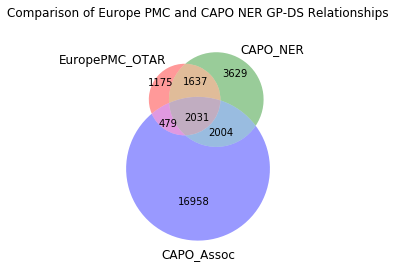

In [26]:
# Second way
plt.title('Comparison of Europe PMC and CAPO NER GP-DS Relationships\n')
venn3([set(eurpmc_1000_otar), set(ml_1000_otar),set(ml_1000_assoc_otar)], set_labels = ('EuropePMC_OTAR', 'CAPO_NER','CAPO_Assoc'))
plt.show()


In [30]:
len(ml_2000_otar)

19831

In [40]:
epmc_annotations_2000 = '/nfs/gns/literature/machine-learning/EPMC_annotations/2000 articles/IOB_formats/europepmcAPI_2000_iob.csv'
ml_annotations_2000 = '/nfs/gns/literature/machine-learning/EPMC_annotations/2000 articles/IOB_formats/ml_2000_iob.csv'



eurpmc_2000 = pd.read_csv(epmc_annotations_2000, sep = '\t', names = ['token','ner'], error_bad_lines=False)
ml_2000 = pd.read_csv(ml_annotations_2000, sep = '\t', names = ['token','ner'], error_bad_lines=False)


In [46]:
E_B_GP = eurpmc_2000.index[eurpmc_2000['ner'] == 'B-GP'].tolist()

In [54]:
E_B_GP = eurpmc_2000.index[eurpmc_2000['ner'] == 'B-GP'].tolist()
E_I_GP = eurpmc_2000.index[eurpmc_2000['ner'] == 'I-GP'].tolist()

M_B_GP = ml_2000.index[ml_2000['ner'] == 'B-GP'].tolist()
M_I_GP = ml_2000.index[ml_2000['ner'] == 'I-GP'].tolist()


E_B_DS = eurpmc_2000.index[eurpmc_2000['ner'] == 'B-DS'].tolist()
E_I_DS = eurpmc_2000.index[eurpmc_2000['ner'] == 'I-DS'].tolist()

M_B_DS = ml_2000.index[ml_2000['ner'] == 'B-DS'].tolist()
M_I_DS = ml_2000.index[ml_2000['ner'] == 'I-DS'].tolist()




In [55]:
EGP = E_B_GP+E_I_GP
MGP = M_B_GP+M_I_GP

In [59]:
EDS = E_B_DS+E_I_DS
MDS = M_B_DS+M_I_DS

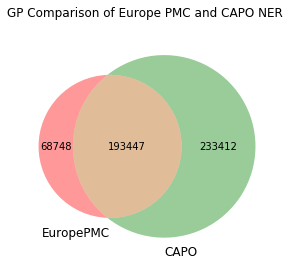

In [67]:
# Second way
plt.title('GP Comparison of Europe PMC and CAPO NER \n')
venn2([set(EGP), set(MGP)], set_labels = ('EuropePMC', 'CAPO'))
plt.show()



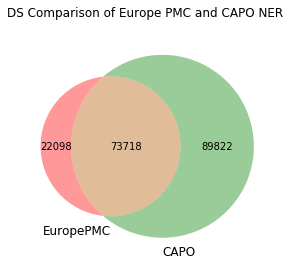

In [60]:
# Second way
plt.title('DS Comparison of Europe PMC and CAPO NER \n')
venn2([set(EDS), set(MDS)], set_labels = ('EuropePMC', 'CAPO'))
plt.show()


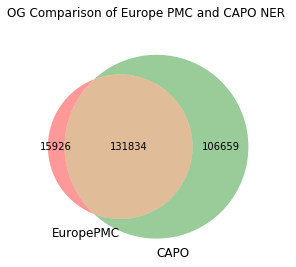

In [61]:
E_B_OG = eurpmc_2000.index[eurpmc_2000['ner'] == 'B-OG'].tolist()
E_I_OG = eurpmc_2000.index[eurpmc_2000['ner'] == 'I-OG'].tolist()

M_B_OG = ml_2000.index[ml_2000['ner'] == 'B-OG'].tolist()
M_I_OG = ml_2000.index[ml_2000['ner'] == 'I-OG'].tolist()

EOG = E_B_OG+E_I_OG
MOG = M_B_OG+M_I_OG

# Second way
plt.title('OG Comparison of Europe PMC and CAPO NER \n')
venn2([set(EOG), set(MOG)], set_labels = ('EuropePMC', 'CAPO'))
plt.show()



In [ ]:
pred_path = '/nfs/gns/literature/machine-learning/Santosh/test_ml_ner/'
manual_path = '/nfs/gns/literature/machine-learning/NER_Datasets/EBI_standard-IOB/'


true_lbs = pd.read_csv(manual_path+'test.csv', sep='\t', names=['tokens','tags'])
pred_lbs = pd.read_csv(pred_path+'test_manual_annotated_on_ml.csv', sep='\t', names=['tokens','tags'])

y_true = true_lbs['tags'].values
y_pred =  pred_lbs['tags'].values


class_labels = sorted([tag for tag in set(y_true) if tag != 'O'], key=lambda name: (name[1:], name[0]))

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, labels = class_labels))

# Run Associations

In [70]:
from flair.models import TextClassifier
from flair.data import Sentence, Token


flair_models = '/nfs/gns/literature/Santosh_Tirunagari/GitHub/flair_models/text_classification/association_model/v-01'
# load the model you trained
from flair.models import TextClassifier
from flair.data import Sentence

classifier = TextClassifier.load(flair_models+'/best-model.pt')

2019-11-11 17:51:05,074 loading file /nfs/gns/literature/Santosh_Tirunagari/GitHub/flair_models/text_classification/association_model/v-01/best-model.pt


In [83]:
sentence = Sentence('Our findings suggest a role for ANP in PDR')
classifier.predict(sentence)
# str(sentence.labels[0]).split()[1]
round(float(str(sentence.labels[0]).split()[1].split('(', 1)[1].split(')')[0]),3)

0.973

In [ ]:
from ast import literal_eval

epmc_annotations_2000 = '/nfs/gns/literature/machine-learning/EPMC_annotations/2000 articles/full_sentences/Europe_PMC_annotation.csv'

result_path = '/nfs/gns/literature/machine-learning/EPMC_annotations/2000 articles/ML_Associations/'


df_2000 = pd.read_csv(epmc_annotations_2000, sep = '\t', names = ['pmcid', 'sentence','ner'], error_bad_lines=False)

with open(result_path + 'ml_2000_associations.csv', 'a', newline='\n') as f1:  
    ml_writer = csv.writer(f1, delimiter='\t', lineterminator='\n')
    
    for index, row in tqdm(df_2000.iterrows(), total=df_2000.shape[0]):
#         print(row['ner'])
        text_temp = row['sentence'].encode('utf-8').decode('utf-8')
        sentence = Sentence(text_temp)
        classifier.predict(sentence)
        try:
            label = str(sentence.labels[0]).split()[0]
            score = round(float(str(sentence.labels[0]).split()[1].split('(', 1)[1].split(')')[0]),3)
        except:
            label = ''
            score = ''
        ml_writer.writerow([text_temp,label,score])


  0%|          | 44/972548 [00:06<47:08:12,  5.73it/s]

2019-11-11 18:08:04,167 Ignore 1 sentence(s) with no tokens.


  0%|          | 49/972548 [00:07<44:25:16,  6.08it/s]

2019-11-11 18:08:04,722 Ignore 1 sentence(s) with no tokens.


  0%|          | 55/972548 [00:08<45:59:40,  5.87it/s]

2019-11-11 18:08:05,496 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:05,498 Ignore 1 sentence(s) with no tokens.


  0%|          | 62/972548 [00:10<74:42:04,  3.62it/s]

2019-11-11 18:08:07,719 Ignore 1 sentence(s) with no tokens.


  0%|          | 65/972548 [00:10<63:08:21,  4.28it/s]

2019-11-11 18:08:08,137 Ignore 1 sentence(s) with no tokens.


  0%|          | 69/972548 [00:11<42:05:20,  6.42it/s]

2019-11-11 18:08:08,644 Ignore 1 sentence(s) with no tokens.


  0%|          | 76/972548 [00:12<51:17:31,  5.27it/s]

2019-11-11 18:08:09,675 Ignore 1 sentence(s) with no tokens.


  0%|          | 97/972548 [00:16<47:31:54,  5.68it/s]

2019-11-11 18:08:14,069 Ignore 1 sentence(s) with no tokens.


  0%|          | 99/972548 [00:16<38:01:54,  7.10it/s]

2019-11-11 18:08:14,186 Ignore 1 sentence(s) with no tokens.


  0%|          | 107/972548 [00:17<29:56:42,  9.02it/s]

2019-11-11 18:08:14,926 Ignore 1 sentence(s) with no tokens.


  0%|          | 113/972548 [00:18<42:50:58,  6.30it/s]

2019-11-11 18:08:15,938 Ignore 1 sentence(s) with no tokens.


  0%|          | 116/972548 [00:18<33:58:13,  7.95it/s]

2019-11-11 18:08:16,003 Ignore 1 sentence(s) with no tokens.


  0%|          | 118/972548 [00:18<27:54:48,  9.68it/s]

2019-11-11 18:08:16,105 Ignore 1 sentence(s) with no tokens.


  0%|          | 120/972548 [00:18<23:52:59, 11.31it/s]

2019-11-11 18:08:16,482 Ignore 1 sentence(s) with no tokens.


  0%|          | 124/972548 [00:19<24:51:47, 10.86it/s]

2019-11-11 18:08:16,619 Ignore 1 sentence(s) with no tokens.


  0%|          | 126/972548 [00:19<22:13:41, 12.15it/s]

2019-11-11 18:08:16,738 Ignore 1 sentence(s) with no tokens.


  0%|          | 129/972548 [00:19<19:33:42, 13.81it/s]

2019-11-11 18:08:16,887 Ignore 1 sentence(s) with no tokens.


  0%|          | 137/972548 [00:20<23:26:19, 11.52it/s]

2019-11-11 18:08:17,551 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:17,582 Ignore 1 sentence(s) with no tokens.


  0%|          | 141/972548 [00:20<22:35:27, 11.96it/s]

2019-11-11 18:08:17,888 Ignore 1 sentence(s) with no tokens.


  0%|          | 144/972548 [00:20<21:24:33, 12.62it/s]

2019-11-11 18:08:18,063 Ignore 1 sentence(s) with no tokens.


  0%|          | 146/972548 [00:20<22:21:10, 12.08it/s]

2019-11-11 18:08:18,245 Ignore 1 sentence(s) with no tokens.


  0%|          | 149/972548 [00:21<21:47:51, 12.39it/s]

2019-11-11 18:08:18,473 Ignore 1 sentence(s) with no tokens.


  0%|          | 152/972548 [00:21<18:03:18, 14.96it/s]

2019-11-11 18:08:18,641 Ignore 1 sentence(s) with no tokens.


  0%|          | 157/972548 [00:21<19:18:57, 13.98it/s]

2019-11-11 18:08:18,915 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:18,986 Ignore 1 sentence(s) with no tokens.


  0%|          | 161/972548 [00:21<16:47:05, 16.09it/s]

2019-11-11 18:08:19,076 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:19,156 Ignore 1 sentence(s) with no tokens.


  0%|          | 165/972548 [00:21<13:56:45, 19.37it/s]

2019-11-11 18:08:19,184 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:19,272 Ignore 1 sentence(s) with no tokens.


  0%|          | 169/972548 [00:21<13:23:09, 20.18it/s]

2019-11-11 18:08:19,363 Ignore 1 sentence(s) with no tokens.


  0%|          | 179/972548 [00:23<30:05:45,  8.97it/s]

2019-11-11 18:08:20,571 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:20,573 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:20,637 Ignore 1 sentence(s) with no tokens.


  0%|          | 184/972548 [00:23<23:06:30, 11.69it/s]

2019-11-11 18:08:20,697 Ignore 1 sentence(s) with no tokens.


  0%|          | 187/972548 [00:23<22:34:17, 11.97it/s]

2019-11-11 18:08:20,934 Ignore 1 sentence(s) with no tokens.


  0%|          | 190/972548 [00:23<19:37:17, 13.77it/s]

2019-11-11 18:08:21,075 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:21,134 Ignore 1 sentence(s) with no tokens.


  0%|          | 194/972548 [00:23<16:56:45, 15.94it/s]

2019-11-11 18:08:21,234 Ignore 1 sentence(s) with no tokens.


  0%|          | 201/972548 [00:24<34:33:30,  7.82it/s]

2019-11-11 18:08:22,312 Ignore 1 sentence(s) with no tokens.


  0%|          | 206/972548 [00:25<27:23:22,  9.86it/s]

2019-11-11 18:08:22,831 Ignore 1 sentence(s) with no tokens.


  0%|          | 208/972548 [00:25<24:59:52, 10.80it/s]

2019-11-11 18:08:22,988 Ignore 1 sentence(s) with no tokens.


  0%|          | 212/972548 [00:25<29:02:51,  9.30it/s]

2019-11-11 18:08:23,525 Ignore 1 sentence(s) with no tokens.


  0%|          | 214/972548 [00:26<29:44:27,  9.08it/s]

2019-11-11 18:08:23,638 Ignore 1 sentence(s) with no tokens.


  0%|          | 216/972548 [00:26<25:23:32, 10.64it/s]

2019-11-11 18:08:23,943 Ignore 1 sentence(s) with no tokens.


  0%|          | 218/972548 [00:26<30:09:09,  8.96it/s]

2019-11-11 18:08:23,947 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:23,949 Ignore 1 sentence(s) with no tokens.


  0%|          | 228/972548 [00:28<50:23:34,  5.36it/s]

2019-11-11 18:08:25,666 Ignore 1 sentence(s) with no tokens.


  0%|          | 232/972548 [00:28<35:39:17,  7.58it/s]

2019-11-11 18:08:25,968 Ignore 1 sentence(s) with no tokens.


  0%|          | 248/972548 [00:30<28:36:46,  9.44it/s]

2019-11-11 18:08:27,806 Ignore 1 sentence(s) with no tokens.


  0%|          | 253/972548 [00:30<31:49:27,  8.49it/s]

2019-11-11 18:08:28,346 Ignore 1 sentence(s) with no tokens.


  0%|          | 255/972548 [00:31<27:52:14,  9.69it/s]

2019-11-11 18:08:28,484 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:28,486 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:28,487 Ignore 1 sentence(s) with no tokens.


  0%|          | 261/972548 [00:31<28:38:21,  9.43it/s]

2019-11-11 18:08:29,230 Ignore 1 sentence(s) with no tokens.


  0%|          | 263/972548 [00:31<27:33:13,  9.80it/s]

2019-11-11 18:08:29,353 Ignore 1 sentence(s) with no tokens.


  0%|          | 265/972548 [00:31<24:16:36, 11.12it/s]

2019-11-11 18:08:29,357 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:29,359 Ignore 1 sentence(s) with no tokens.


  0%|          | 272/972548 [00:32<24:23:46, 11.07it/s]

2019-11-11 18:08:30,100 Ignore 1 sentence(s) with no tokens.


  0%|          | 274/972548 [00:32<24:43:28, 10.92it/s]

2019-11-11 18:08:30,265 Ignore 1 sentence(s) with no tokens.


  0%|          | 294/972548 [00:35<36:50:12,  7.33it/s]

2019-11-11 18:08:32,619 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:32,675 Ignore 1 sentence(s) with no tokens.


  0%|          | 298/972548 [00:35<28:41:52,  9.41it/s]

2019-11-11 18:08:32,763 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:32,765 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:32,849 Ignore 1 sentence(s) with no tokens.


  0%|          | 303/972548 [00:35<27:43:03,  9.74it/s]

2019-11-11 18:08:33,234 Ignore 1 sentence(s) with no tokens.


  0%|          | 305/972548 [00:35<24:33:20, 11.00it/s]

2019-11-11 18:08:33,361 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:33,410 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:33,412 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:33,414 Ignore 1 sentence(s) with no tokens.


  0%|          | 311/972548 [00:36<18:46:54, 14.38it/s]

2019-11-11 18:08:33,552 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:33,554 Ignore 1 sentence(s) with no tokens.


  0%|          | 315/972548 [00:36<16:18:55, 16.55it/s]

2019-11-11 18:08:33,635 Ignore 1 sentence(s) with no tokens.


  0%|          | 318/972548 [00:36<16:41:39, 16.18it/s]

2019-11-11 18:08:33,830 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:33,914 Ignore 1 sentence(s) with no tokens.


  0%|          | 327/972548 [00:37<22:52:10, 11.81it/s]

2019-11-11 18:08:34,638 Ignore 1 sentence(s) with no tokens.


  0%|          | 330/972548 [00:37<21:09:24, 12.76it/s]

2019-11-11 18:08:34,829 Ignore 1 sentence(s) with no tokens.


  0%|          | 332/972548 [00:37<19:49:00, 13.63it/s]

2019-11-11 18:08:34,953 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:34,954 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:34,956 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:35,044 Ignore 1 sentence(s) with no tokens.


  0%|          | 338/972548 [00:37<16:34:15, 16.30it/s]

2019-11-11 18:08:35,153 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:08:35,227 Ignore 1 sentence(s) with no tokens.


  0%|          | 348/972548 [00:38<22:05:59, 12.22it/s]

2019-11-11 18:08:35,914 Ignore 1 sentence(s) with no tokens.


  0%|          | 351/972548 [00:38<19:12:27, 14.06it/s]

2019-11-11 18:08:36,052 Ignore 1 sentence(s) with no tokens.


  0%|          | 733/972548 [01:32<15:32:32, 17.37it/s]

2019-11-11 18:09:30,272 Ignore 1 sentence(s) with no tokens.


  0%|          | 749/972548 [01:33<9:07:49, 29.56it/s] 

2019-11-11 18:09:30,520 Ignore 1 sentence(s) with no tokens.


  0%|          | 759/972548 [01:33<7:54:25, 34.14it/s]

2019-11-11 18:09:30,812 Ignore 1 sentence(s) with no tokens.


  0%|          | 774/972548 [01:33<7:06:04, 38.01it/s]

2019-11-11 18:09:31,225 Ignore 1 sentence(s) with no tokens.


  0%|          | 870/972548 [01:40<8:47:00, 30.73it/s] 

2019-11-11 18:09:38,131 Ignore 1 sentence(s) with no tokens.


  0%|          | 878/972548 [01:40<9:15:36, 29.15it/s]

2019-11-11 18:09:38,420 Ignore 1 sentence(s) with no tokens.


  0%|          | 934/972548 [01:42<8:43:58, 30.91it/s]

2019-11-11 18:09:40,143 Ignore 1 sentence(s) with no tokens.


  0%|          | 938/972548 [01:42<8:14:56, 32.72it/s]

2019-11-11 18:09:40,285 Ignore 1 sentence(s) with no tokens.


  0%|          | 1020/972548 [01:45<8:22:28, 32.22it/s]

2019-11-11 18:09:43,464 Ignore 1 sentence(s) with no tokens.


  0%|          | 1029/972548 [01:46<9:17:09, 29.06it/s]

2019-11-11 18:09:43,722 Ignore 1 sentence(s) with no tokens.


  0%|          | 1199/972548 [02:04<21:14:50, 12.70it/s]

2019-11-11 18:10:02,414 Ignore 1 sentence(s) with no tokens.


  0%|          | 1358/972548 [02:31<35:02:11,  7.70it/s]

2019-11-11 18:10:28,907 Ignore 1 sentence(s) with no tokens.


  0%|          | 1715/972548 [03:19<14:56:08, 18.06it/s]

2019-11-11 18:11:16,801 Ignore 1 sentence(s) with no tokens.


  0%|          | 1757/972548 [03:22<30:25:36,  8.86it/s]

2019-11-11 18:11:19,491 Ignore 1 sentence(s) with no tokens.


  0%|          | 1793/972548 [03:23<20:01:59, 13.46it/s]

2019-11-11 18:11:21,369 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:11:21,371 Ignore 1 sentence(s) with no tokens.


  0%|          | 1831/972548 [03:25<19:10:14, 14.07it/s]

2019-11-11 18:11:23,301 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:11:23,303 Ignore 1 sentence(s) with no tokens.


  0%|          | 1923/972548 [03:31<36:05:05,  7.47it/s]

2019-11-11 18:11:28,707 Ignore 1 sentence(s) with no tokens.


  0%|          | 1926/972548 [03:31<28:10:26,  9.57it/s]

2019-11-11 18:11:28,795 Ignore 1 sentence(s) with no tokens.


  0%|          | 1988/972548 [03:34<26:15:21, 10.27it/s]

2019-11-11 18:11:31,698 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:11:31,782 Ignore 1 sentence(s) with no tokens.


  0%|          | 2353/972548 [04:23<37:30:08,  7.19it/s] 

2019-11-11 18:12:20,883 Ignore 1 sentence(s) with no tokens.


  0%|          | 2406/972548 [04:24<8:01:05, 33.61it/s] 

2019-11-11 18:12:22,287 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:12:22,312 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:12:22,382 Ignore 1 sentence(s) with no tokens.


  0%|          | 2413/972548 [04:24<7:04:36, 38.08it/s]

2019-11-11 18:12:22,511 Ignore 1 sentence(s) with no tokens.


  0%|          | 2465/972548 [04:26<8:30:02, 31.70it/s]

2019-11-11 18:12:23,942 Ignore 1 sentence(s) with no tokens.


  0%|          | 2512/972548 [04:27<7:50:10, 34.39it/s]

2019-11-11 18:12:25,308 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:12:25,334 Ignore 1 sentence(s) with no tokens.


  0%|          | 2519/972548 [04:27<7:01:37, 38.34it/s]

2019-11-11 18:12:25,408 Ignore 1 sentence(s) with no tokens.


  0%|          | 2524/972548 [04:28<6:48:07, 39.61it/s]

2019-11-11 18:12:25,537 Ignore 1 sentence(s) with no tokens.


  0%|          | 2668/972548 [04:50<68:46:40,  3.92it/s]

2019-11-11 18:12:47,867 Ignore 1 sentence(s) with no tokens.


  0%|          | 2771/972548 [05:08<43:47:29,  6.15it/s]

2019-11-11 18:13:05,959 Ignore 1 sentence(s) with no tokens.


  0%|          | 3186/972548 [06:05<9:29:13, 28.38it/s] 

2019-11-11 18:14:02,885 Ignore 1 sentence(s) with no tokens.


  0%|          | 3466/972548 [06:29<18:24:29, 14.62it/s]

2019-11-11 18:14:26,460 Ignore 1 sentence(s) with no tokens.


  0%|          | 3476/972548 [06:29<12:46:32, 21.07it/s]

2019-11-11 18:14:26,853 Ignore 1 sentence(s) with no tokens.


  0%|          | 3480/972548 [06:29<11:23:13, 23.64it/s]

2019-11-11 18:14:26,895 Ignore 1 sentence(s) with no tokens.


  0%|          | 3484/972548 [06:29<10:00:55, 26.88it/s]

2019-11-11 18:14:27,055 Ignore 1 sentence(s) with no tokens.


  0%|          | 3576/972548 [06:44<30:36:08,  8.80it/s]

2019-11-11 18:14:42,414 Ignore 1 sentence(s) with no tokens.


  0%|          | 3783/972548 [07:19<29:25:10,  9.15it/s]

2019-11-11 18:15:16,954 Ignore 1 sentence(s) with no tokens.


  0%|          | 3883/972548 [07:32<26:15:22, 10.25it/s]

2019-11-11 18:15:29,799 Ignore 1 sentence(s) with no tokens.


  0%|          | 4002/972548 [07:51<30:55:55,  8.70it/s]

2019-11-11 18:15:48,962 Ignore 1 sentence(s) with no tokens.


  0%|          | 4213/972548 [08:17<22:22:28, 12.02it/s]

2019-11-11 18:16:14,522 Ignore 1 sentence(s) with no tokens.


  0%|          | 4616/972548 [09:05<9:20:57, 28.76it/s] 

2019-11-11 18:17:03,415 Ignore 1 sentence(s) with no tokens.


  1%|          | 5219/972548 [10:38<40:40:03,  6.61it/s]

2019-11-11 18:18:35,784 Ignore 1 sentence(s) with no tokens.


  1%|          | 5407/972548 [10:44<37:51:53,  7.09it/s]

2019-11-11 18:18:42,428 Ignore 1 sentence(s) with no tokens.


  1%|          | 5709/972548 [10:58<6:08:32, 43.72it/s] 

2019-11-11 18:18:56,213 Ignore 1 sentence(s) with no tokens.


  1%|          | 5719/972548 [10:59<7:39:51, 35.04it/s]

2019-11-11 18:18:56,512 Ignore 1 sentence(s) with no tokens.


  1%|          | 6134/972548 [11:22<37:41:18,  7.12it/s]

2019-11-11 18:19:20,384 Ignore 1 sentence(s) with no tokens.


  1%|          | 6240/972548 [11:30<15:12:53, 17.64it/s]

2019-11-11 18:19:28,024 Ignore 1 sentence(s) with no tokens.


  1%|          | 7590/972548 [14:08<35:47:56,  7.49it/s]

2019-11-11 18:22:05,769 Ignore 1 sentence(s) with no tokens.


  1%|          | 8100/972548 [15:30<40:32:18,  6.61it/s] 

2019-11-11 18:23:28,422 Ignore 1 sentence(s) with no tokens.


  1%|          | 8110/972548 [15:31<22:55:53, 11.68it/s]

2019-11-11 18:23:28,583 Ignore 1 sentence(s) with no tokens.


  1%|          | 8178/972548 [15:33<8:11:43, 32.69it/s] 

2019-11-11 18:23:30,516 Ignore 1 sentence(s) with no tokens.


  1%|          | 8457/972548 [15:40<10:49:44, 24.73it/s]

2019-11-11 18:23:37,876 Ignore 1 sentence(s) with no tokens.


  1%|          | 8467/972548 [15:40<8:19:12, 32.19it/s] 

2019-11-11 18:23:38,133 Ignore 1 sentence(s) with no tokens.


  1%|          | 8587/972548 [15:43<8:30:29, 31.47it/s]

2019-11-11 18:23:40,815 Ignore 1 sentence(s) with no tokens.


  1%|          | 8592/972548 [15:43<7:34:23, 35.36it/s]

2019-11-11 18:23:40,975 Ignore 1 sentence(s) with no tokens.


  1%|          | 9028/972548 [16:43<43:50:25,  6.10it/s]

2019-11-11 18:24:40,474 Ignore 1 sentence(s) with no tokens.


  1%|          | 9073/972548 [16:47<22:49:03, 11.73it/s]

2019-11-11 18:24:44,965 Ignore 1 sentence(s) with no tokens.


  1%|          | 9097/972548 [16:48<9:25:29, 28.40it/s] 

2019-11-11 18:24:45,506 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:24:45,539 Ignore 1 sentence(s) with no tokens.


  1%|          | 9145/972548 [16:52<33:48:29,  7.92it/s]

2019-11-11 18:24:50,269 Ignore 1 sentence(s) with no tokens.


  1%|          | 9149/972548 [16:52<26:04:52, 10.26it/s]

2019-11-11 18:24:50,416 Ignore 1 sentence(s) with no tokens.


  1%|          | 9977/972548 [19:38<30:59:31,  8.63it/s] 

2019-11-11 18:27:36,374 Ignore 1 sentence(s) with no tokens.


  1%|          | 11196/972548 [22:31<24:09:07, 11.06it/s]

2019-11-11 18:30:29,052 Ignore 1 sentence(s) with no tokens.


  1%|          | 11258/972548 [22:39<29:28:30,  9.06it/s]

2019-11-11 18:30:37,326 Ignore 1 sentence(s) with no tokens.


  1%|          | 11274/972548 [22:40<14:02:50, 19.01it/s]

2019-11-11 18:30:37,735 Ignore 1 sentence(s) with no tokens.


  1%|          | 11289/972548 [22:40<8:47:52, 30.35it/s] 

2019-11-11 18:30:38,058 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 14674/972548 [31:32<27:22:03,  9.72it/s] 

2019-11-11 18:39:29,517 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 17688/972548 [35:36<32:57:51,  8.05it/s] 

2019-11-11 18:43:34,131 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 17705/972548 [35:37<15:32:42, 17.06it/s]

2019-11-11 18:43:34,773 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 17709/972548 [35:37<13:06:46, 20.23it/s]

2019-11-11 18:43:34,870 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:43:34,872 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:43:34,874 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 17720/972548 [35:37<11:52:09, 22.35it/s]

2019-11-11 18:43:35,164 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:43:35,165 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 17756/972548 [35:38<7:31:18, 35.26it/s] 

2019-11-11 18:43:36,264 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 17760/972548 [35:38<9:49:02, 27.02it/s]

2019-11-11 18:43:36,345 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 17767/972548 [35:39<14:59:38, 17.69it/s]

2019-11-11 18:43:36,829 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:43:36,906 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 18964/972548 [37:47<13:55:05, 19.03it/s]

2019-11-11 18:45:44,980 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19159/972548 [37:57<16:42:12, 15.85it/s]

2019-11-11 18:45:54,683 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19416/972548 [38:27<35:47:59,  7.40it/s]

2019-11-11 18:46:24,482 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,484 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,524 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,526 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19423/972548 [38:27<26:43:43,  9.91it/s]

2019-11-11 18:46:24,583 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,585 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,624 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,626 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,678 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,680 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19431/972548 [38:27<19:42:19, 13.44it/s]

2019-11-11 18:46:24,748 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,750 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,796 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19436/972548 [38:27<15:38:59, 16.92it/s]

2019-11-11 18:46:24,800 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,847 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,849 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19441/972548 [38:27<12:32:50, 21.10it/s]

2019-11-11 18:46:24,901 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,903 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,961 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:24,963 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19447/972548 [38:27<10:08:29, 26.11it/s]

2019-11-11 18:46:25,003 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,005 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,061 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,063 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19453/972548 [38:27<8:42:13, 30.42it/s] 

2019-11-11 18:46:25,125 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,127 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,173 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,175 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19459/972548 [38:27<7:35:39, 34.86it/s]

2019-11-11 18:46:25,238 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,240 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,285 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,287 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19465/972548 [38:27<6:58:02, 38.00it/s]

2019-11-11 18:46:25,363 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,365 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,436 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,438 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19471/972548 [38:28<6:34:17, 40.29it/s]

2019-11-11 18:46:25,491 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,493 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,531 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,533 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19477/972548 [38:28<6:01:21, 43.96it/s]

2019-11-11 18:46:25,598 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,600 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,664 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,666 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19483/972548 [38:28<5:48:23, 45.59it/s]

2019-11-11 18:46:25,718 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,720 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,778 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,781 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19489/972548 [38:28<5:41:39, 46.49it/s]

2019-11-11 18:46:25,841 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,843 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,887 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,889 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19495/972548 [38:28<5:21:10, 49.46it/s]

2019-11-11 18:46:25,945 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:25,947 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,003 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,005 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19501/972548 [38:28<5:22:27, 49.26it/s]

2019-11-11 18:46:26,068 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,070 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,127 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,129 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19507/972548 [38:28<5:12:11, 50.88it/s]

2019-11-11 18:46:26,177 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,179 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,226 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,228 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19513/972548 [38:28<4:58:37, 53.19it/s]

2019-11-11 18:46:26,277 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,279 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,314 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,316 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,366 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,368 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19522/972548 [38:28<4:35:45, 57.60it/s]

2019-11-11 18:46:26,403 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,405 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,458 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,460 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:46:26,501 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 19529/972548 [38:29<4:22:28, 60.52it/s]

2019-11-11 18:46:26,505 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 20009/972548 [39:39<20:35:00, 12.85it/s]

2019-11-11 18:47:36,878 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 20042/972548 [39:40<7:42:36, 34.32it/s] 

2019-11-11 18:47:37,682 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:47:37,749 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 20183/972548 [39:57<36:10:32,  7.31it/s]

2019-11-11 18:47:55,201 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 22301/972548 [44:32<21:22:33, 12.35it/s] 

2019-11-11 18:52:30,360 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 22306/972548 [44:33<16:53:58, 15.62it/s]

2019-11-11 18:52:30,545 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 22310/972548 [44:33<14:16:30, 18.49it/s]

2019-11-11 18:52:30,606 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 22333/972548 [44:34<16:56:10, 15.58it/s]

2019-11-11 18:52:32,062 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 22387/972548 [44:39<38:04:17,  6.93it/s]

2019-11-11 18:52:37,034 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 22437/972548 [44:42<21:24:23, 12.33it/s]

2019-11-11 18:52:40,406 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 22449/972548 [44:43<13:20:46, 19.77it/s]

2019-11-11 18:52:40,742 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 22528/972548 [44:55<30:34:32,  8.63it/s]

2019-11-11 18:52:52,633 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 22660/972548 [45:15<20:38:08, 12.79it/s]

2019-11-11 18:53:13,047 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 22789/972548 [45:26<9:53:20, 26.68it/s] 

2019-11-11 18:53:23,799 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 22995/972548 [45:31<6:26:11, 40.98it/s]

2019-11-11 18:53:28,702 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 23031/972548 [45:32<6:20:36, 41.58it/s]

2019-11-11 18:53:29,550 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 23092/972548 [45:33<6:15:57, 42.09it/s]

2019-11-11 18:53:31,035 Ignore 1 sentence(s) with no tokens.


  2%|▏         | 24046/972548 [46:08<21:51:24, 12.05it/s]

2019-11-11 18:54:05,897 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 24655/972548 [47:24<12:42:36, 20.72it/s]

2019-11-11 18:55:22,346 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:55:22,424 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 24688/972548 [47:26<10:49:27, 24.32it/s]

2019-11-11 18:55:23,625 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:55:23,703 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 24726/972548 [47:28<16:31:23, 15.93it/s]

2019-11-11 18:55:25,972 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 24731/972548 [47:28<13:31:51, 19.46it/s]

2019-11-11 18:55:26,056 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 25005/972548 [47:53<8:16:07, 31.83it/s] 

2019-11-11 18:55:51,155 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 25015/972548 [47:53<7:34:47, 34.72it/s]

2019-11-11 18:55:51,349 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 25843/972548 [49:40<58:53:05,  4.47it/s] 

2019-11-11 18:57:37,994 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 25877/972548 [49:43<50:57:49,  5.16it/s]

2019-11-11 18:57:41,268 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 25936/972548 [49:54<28:01:49,  9.38it/s]

2019-11-11 18:57:52,030 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 25949/972548 [49:55<14:22:22, 18.29it/s]

2019-11-11 18:57:52,512 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:57:52,535 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 26034/972548 [50:09<28:09:34,  9.34it/s]

2019-11-11 18:58:06,819 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 27017/972548 [51:06<29:42:56,  8.84it/s]

2019-11-11 18:59:04,315 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 27115/972548 [51:21<43:09:02,  6.09it/s]

2019-11-11 18:59:19,123 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 27228/972548 [51:34<62:45:03,  4.18it/s]

2019-11-11 18:59:31,795 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:59:31,798 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 27238/972548 [51:34<33:50:27,  7.76it/s]

2019-11-11 18:59:31,942 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:59:31,944 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 27299/972548 [51:36<11:23:00, 23.07it/s]

2019-11-11 18:59:33,704 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:59:33,706 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 27308/972548 [51:36<9:00:25, 29.15it/s] 

2019-11-11 18:59:33,879 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:59:33,881 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 27375/972548 [51:40<39:28:52,  6.65it/s]

2019-11-11 18:59:37,529 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:59:37,531 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 27384/972548 [51:40<22:56:37, 11.44it/s]

2019-11-11 18:59:37,704 Ignore 1 sentence(s) with no tokens.
2019-11-11 18:59:37,706 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 27511/972548 [51:52<25:58:36, 10.11it/s]

2019-11-11 18:59:50,239 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 28562/972548 [53:32<26:26:53,  9.91it/s]

2019-11-11 19:01:30,153 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 28783/972548 [53:40<10:11:46, 25.71it/s]

2019-11-11 19:01:38,332 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 28787/972548 [53:41<10:54:14, 24.04it/s]

2019-11-11 19:01:38,441 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 28844/972548 [53:42<8:09:39, 32.12it/s] 

2019-11-11 19:01:40,223 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:01:40,333 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 32013/972548 [59:30<29:44:49,  8.78it/s]

2019-11-11 19:07:27,850 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 32691/972548 [1:00:57<30:20:40,  8.60it/s]

2019-11-11 19:08:54,520 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:08:54,522 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:08:54,524 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 32819/972548 [1:01:02<28:33:13,  9.14it/s]

2019-11-11 19:08:59,877 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:08:59,879 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 32834/972548 [1:01:02<13:59:06, 18.66it/s]

2019-11-11 19:09:00,222 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 32995/972548 [1:01:06<5:20:58, 48.79it/s] 

2019-11-11 19:09:03,514 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33007/972548 [1:01:06<5:13:51, 49.89it/s]

2019-11-11 19:09:03,689 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:03,742 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33013/972548 [1:01:06<5:53:47, 44.26it/s]

2019-11-11 19:09:03,878 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:03,880 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33026/972548 [1:01:06<5:32:44, 47.06it/s]

2019-11-11 19:09:04,178 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33187/972548 [1:01:09<5:17:07, 49.37it/s]

2019-11-11 19:09:07,442 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33205/972548 [1:01:10<10:34:13, 24.69it/s]

2019-11-11 19:09:08,185 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:08,187 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:08,189 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33223/972548 [1:01:11<7:34:22, 34.46it/s] 

2019-11-11 19:09:08,538 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33364/972548 [1:01:13<5:18:37, 49.13it/s]

2019-11-11 19:09:11,454 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33376/972548 [1:01:14<5:14:55, 49.70it/s]

2019-11-11 19:09:11,633 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:11,687 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33381/972548 [1:01:14<5:43:12, 45.61it/s]

2019-11-11 19:09:11,843 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33386/972548 [1:01:14<5:39:56, 46.04it/s]

2019-11-11 19:09:11,847 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:11,848 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33399/972548 [1:01:14<5:38:40, 46.22it/s]

2019-11-11 19:09:12,157 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33540/972548 [1:01:17<5:20:44, 48.79it/s]

2019-11-11 19:09:15,064 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33561/972548 [1:01:18<10:01:06, 26.03it/s]

2019-11-11 19:09:15,852 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:15,854 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:15,856 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:15,858 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:15,859 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33587/972548 [1:01:18<7:03:15, 36.97it/s] 

2019-11-11 19:09:16,393 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33803/972548 [1:01:23<5:21:01, 48.74it/s]

2019-11-11 19:09:20,770 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33815/972548 [1:01:23<5:15:45, 49.55it/s]

2019-11-11 19:09:21,028 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33820/972548 [1:01:23<5:32:38, 47.03it/s]

2019-11-11 19:09:21,084 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33825/972548 [1:01:23<6:00:38, 43.38it/s]

2019-11-11 19:09:21,280 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:21,282 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:21,284 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:21,286 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:09:21,287 Ignore 1 sentence(s) with no tokens.


  3%|▎         | 33852/972548 [1:01:24<5:48:32, 44.89it/s]

2019-11-11 19:09:21,780 Ignore 1 sentence(s) with no tokens.


  4%|▎         | 34068/972548 [1:01:28<5:17:04, 49.33it/s]

2019-11-11 19:09:26,127 Ignore 1 sentence(s) with no tokens.


  4%|▎         | 34768/972548 [1:02:44<27:12:34,  9.57it/s]

2019-11-11 19:10:41,930 Ignore 1 sentence(s) with no tokens.


  4%|▎         | 35609/972548 [1:05:00<26:06:41,  9.97it/s]

2019-11-11 19:12:58,047 Ignore 1 sentence(s) with no tokens.


  4%|▎         | 36074/972548 [1:06:09<8:22:57, 31.03it/s] 

2019-11-11 19:14:07,171 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:14:07,202 Ignore 1 sentence(s) with no tokens.


  4%|▎         | 36295/972548 [1:06:28<7:10:26, 36.25it/s] 

2019-11-11 19:14:25,722 Ignore 1 sentence(s) with no tokens.


  4%|▎         | 36340/972548 [1:06:29<6:50:12, 38.04it/s]

2019-11-11 19:14:26,928 Ignore 1 sentence(s) with no tokens.


  4%|▎         | 36371/972548 [1:06:30<6:52:20, 37.84it/s]

2019-11-11 19:14:27,760 Ignore 1 sentence(s) with no tokens.


  4%|▎         | 36407/972548 [1:06:31<7:01:35, 37.01it/s]

2019-11-11 19:14:28,747 Ignore 1 sentence(s) with no tokens.


  4%|▎         | 36437/972548 [1:06:32<7:19:40, 35.48it/s]

2019-11-11 19:14:29,567 Ignore 1 sentence(s) with no tokens.


  4%|▎         | 36462/972548 [1:06:32<7:04:31, 36.75it/s]

2019-11-11 19:14:30,189 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36570/972548 [1:06:39<9:23:03, 27.71it/s] 

2019-11-11 19:14:37,459 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36622/972548 [1:06:41<7:56:31, 32.73it/s]

2019-11-11 19:14:38,988 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36646/972548 [1:06:42<7:43:46, 33.63it/s]

2019-11-11 19:14:39,638 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36670/972548 [1:06:42<7:34:40, 34.31it/s]

2019-11-11 19:14:40,297 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36708/972548 [1:06:43<7:34:57, 34.28it/s]

2019-11-11 19:14:41,320 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36732/972548 [1:06:44<7:30:26, 34.63it/s]

2019-11-11 19:14:41,959 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36756/972548 [1:06:45<7:33:05, 34.42it/s]

2019-11-11 19:14:42,603 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36780/972548 [1:06:45<7:18:45, 35.55it/s]

2019-11-11 19:14:43,235 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36800/972548 [1:06:46<6:46:45, 38.34it/s]

2019-11-11 19:14:43,668 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36884/972548 [1:06:51<8:10:57, 31.76it/s] 

2019-11-11 19:14:49,230 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36919/972548 [1:06:52<7:26:44, 34.91it/s]

2019-11-11 19:14:50,262 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36953/972548 [1:06:53<7:08:06, 36.42it/s]

2019-11-11 19:14:51,124 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 36988/972548 [1:06:54<7:08:22, 36.40it/s]

2019-11-11 19:14:52,136 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 37008/972548 [1:06:55<6:41:26, 38.84it/s]

2019-11-11 19:14:52,566 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 37023/972548 [1:06:55<7:00:30, 37.08it/s]

2019-11-11 19:14:53,014 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 37529/972548 [1:07:54<8:18:18, 31.27it/s] 

2019-11-11 19:15:51,722 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 37539/972548 [1:07:54<7:16:15, 35.72it/s]

2019-11-11 19:15:51,925 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 37582/972548 [1:07:55<6:40:08, 38.94it/s]

2019-11-11 19:15:53,012 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:15:53,054 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 37833/972548 [1:08:05<32:03:25,  8.10it/s]

2019-11-11 19:16:03,119 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 37869/972548 [1:08:07<12:09:43, 21.35it/s]

2019-11-11 19:16:04,539 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 37896/972548 [1:08:07<10:01:02, 25.92it/s]

2019-11-11 19:16:05,475 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 37919/972548 [1:08:08<10:46:04, 24.11it/s]

2019-11-11 19:16:06,326 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 37933/972548 [1:08:09<10:00:22, 25.95it/s]

2019-11-11 19:16:06,787 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 38033/972548 [1:08:22<29:39:30,  8.75it/s]

2019-11-11 19:16:19,953 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 38458/972548 [1:09:15<33:38:21,  7.71it/s]

2019-11-11 19:17:12,664 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 38554/972548 [1:09:32<35:06:44,  7.39it/s]

2019-11-11 19:17:29,660 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 38586/972548 [1:09:33<9:06:54, 28.46it/s] 

2019-11-11 19:17:30,551 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:17:30,594 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 38592/972548 [1:09:33<7:52:41, 32.93it/s]

2019-11-11 19:17:30,691 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 39349/972548 [1:11:08<32:03:39,  8.09it/s]

2019-11-11 19:19:05,869 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:19:05,871 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:19:05,873 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:19:05,875 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 39477/972548 [1:11:11<6:18:11, 41.12it/s] 

2019-11-11 19:19:08,900 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 40703/972548 [1:13:01<30:48:41,  8.40it/s]

2019-11-11 19:20:59,392 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 41067/972548 [1:13:58<13:24:10, 19.31it/s]

2019-11-11 19:21:56,019 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 41434/972548 [1:14:38<34:57:49,  7.40it/s]

2019-11-11 19:22:35,863 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 41609/972548 [1:14:47<39:09:09,  6.60it/s]

2019-11-11 19:22:44,649 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 41618/972548 [1:14:47<22:34:43, 11.45it/s]

2019-11-11 19:22:44,840 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:22:44,842 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 41628/972548 [1:14:47<14:59:26, 17.25it/s]

2019-11-11 19:22:45,090 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 41674/972548 [1:14:49<7:36:26, 33.99it/s] 

2019-11-11 19:22:46,458 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 41679/972548 [1:14:49<7:01:45, 36.79it/s]

2019-11-11 19:22:46,642 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 41684/972548 [1:14:49<6:33:04, 39.47it/s]

2019-11-11 19:22:46,707 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 41728/972548 [1:14:50<8:29:05, 30.47it/s]

2019-11-11 19:22:48,197 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 41803/972548 [1:15:02<28:22:59,  9.11it/s]

2019-11-11 19:23:00,081 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 42947/972548 [1:17:24<25:56:06,  9.96it/s]

2019-11-11 19:25:22,445 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 43268/972548 [1:18:13<21:41:31, 11.90it/s]

2019-11-11 19:26:10,662 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 43277/972548 [1:18:13<17:36:52, 14.65it/s]

2019-11-11 19:26:11,202 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 43287/972548 [1:18:14<14:06:59, 18.29it/s]

2019-11-11 19:26:11,634 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 43320/972548 [1:18:17<32:37:03,  7.91it/s]

2019-11-11 19:26:15,553 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 43445/972548 [1:18:36<25:37:33, 10.07it/s]

2019-11-11 19:26:34,355 Ignore 1 sentence(s) with no tokens.


  4%|▍         | 43575/972548 [1:18:58<39:33:00,  6.52it/s]

2019-11-11 19:26:55,773 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:26:55,775 Ignore 1 sentence(s) with no tokens.


  5%|▍         | 47157/972548 [1:25:57<13:20:52, 19.26it/s]

2019-11-11 19:33:54,915 Ignore 1 sentence(s) with no tokens.


  5%|▍         | 47289/972548 [1:26:05<38:12:55,  6.73it/s]

2019-11-11 19:34:02,608 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:34:02,610 Ignore 1 sentence(s) with no tokens.


  5%|▍         | 47294/972548 [1:26:05<28:25:18,  9.04it/s]

2019-11-11 19:34:02,814 Ignore 1 sentence(s) with no tokens.


  5%|▍         | 47298/972548 [1:26:05<21:51:49, 11.76it/s]

2019-11-11 19:34:02,818 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:34:02,820 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:34:02,821 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:34:02,823 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:34:02,824 Ignore 1 sentence(s) with no tokens.


  5%|▍         | 47491/972548 [1:26:25<29:11:51,  8.80it/s]

2019-11-11 19:34:22,758 Ignore 1 sentence(s) with no tokens.


  5%|▍         | 48512/972548 [1:29:15<37:36:01,  6.83it/s]

2019-11-11 19:37:13,392 Ignore 1 sentence(s) with no tokens.


  5%|▍         | 48559/972548 [1:29:17<9:48:41, 26.16it/s] 

2019-11-11 19:37:15,075 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 48839/972548 [1:29:41<49:34:38,  5.18it/s]

2019-11-11 19:37:38,773 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 48852/972548 [1:29:41<21:44:47, 11.80it/s]

2019-11-11 19:37:39,073 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 49303/972548 [1:30:24<5:27:35, 46.97it/s] 

2019-11-11 19:38:21,675 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 49541/972548 [1:31:03<24:08:36, 10.62it/s]

2019-11-11 19:39:01,062 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 49578/972548 [1:31:09<42:16:32,  6.06it/s]

2019-11-11 19:39:06,681 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 50041/972548 [1:32:14<11:57:26, 21.43it/s]

2019-11-11 19:40:11,892 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 50108/972548 [1:32:21<8:51:19, 28.93it/s] 

2019-11-11 19:40:19,250 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 50116/972548 [1:32:22<9:02:49, 28.32it/s]

2019-11-11 19:40:19,502 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 50205/972548 [1:32:31<50:43:38,  5.05it/s]

2019-11-11 19:40:28,754 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 50292/972548 [1:32:34<19:00:58, 13.47it/s]

2019-11-11 19:40:32,101 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 50322/972548 [1:32:35<8:01:42, 31.91it/s] 

2019-11-11 19:40:32,964 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 50352/972548 [1:32:36<7:09:38, 35.77it/s]

2019-11-11 19:40:33,825 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 50389/972548 [1:32:37<6:25:58, 39.82it/s]

2019-11-11 19:40:34,801 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 50755/972548 [1:33:14<5:41:42, 44.96it/s] 

2019-11-11 19:41:12,416 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 50822/972548 [1:33:18<8:47:32, 29.12it/s] 

2019-11-11 19:41:16,409 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52023/972548 [1:35:48<38:26:15,  6.65it/s]

2019-11-11 19:43:46,272 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52065/972548 [1:35:49<8:26:48, 30.27it/s] 

2019-11-11 19:43:47,501 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52152/972548 [1:35:55<7:46:22, 32.89it/s] 

2019-11-11 19:43:53,088 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52336/972548 [1:36:23<20:50:14, 12.27it/s]

2019-11-11 19:44:21,346 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52340/972548 [1:36:24<20:19:55, 12.57it/s]

2019-11-11 19:44:21,500 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52410/972548 [1:36:35<33:44:05,  7.58it/s]

2019-11-11 19:44:32,602 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52423/972548 [1:36:35<16:02:08, 15.94it/s]

2019-11-11 19:44:33,196 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:44:33,228 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52446/972548 [1:36:36<13:05:38, 19.52it/s]

2019-11-11 19:44:34,232 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:44:34,282 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52466/972548 [1:36:37<11:53:13, 21.50it/s]

2019-11-11 19:44:35,153 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52470/972548 [1:36:37<11:05:56, 23.03it/s]

2019-11-11 19:44:35,204 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52722/972548 [1:37:16<29:35:48,  8.63it/s]

2019-11-11 19:45:14,118 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52742/972548 [1:37:17<15:40:39, 16.30it/s]

2019-11-11 19:45:15,138 Ignore 1 sentence(s) with no tokens.


  5%|▌         | 52745/972548 [1:37:17<13:56:22, 18.33it/s]

2019-11-11 19:45:15,224 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53819/972548 [1:40:06<26:00:49,  9.81it/s]

2019-11-11 19:48:03,593 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53825/972548 [1:40:06<19:43:20, 12.94it/s]

2019-11-11 19:48:03,673 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53830/972548 [1:40:06<15:37:55, 16.33it/s]

2019-11-11 19:48:03,758 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:48:03,849 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53835/972548 [1:40:06<12:33:32, 20.32it/s]

2019-11-11 19:48:04,055 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53893/972548 [1:40:11<29:05:45,  8.77it/s]

2019-11-11 19:48:09,005 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53898/972548 [1:40:11<22:05:38, 11.55it/s]

2019-11-11 19:48:09,124 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53904/972548 [1:40:11<16:58:48, 15.03it/s]

2019-11-11 19:48:09,243 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53910/972548 [1:40:11<13:24:19, 19.04it/s]

2019-11-11 19:48:09,362 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53916/972548 [1:40:11<10:53:55, 23.41it/s]

2019-11-11 19:48:09,481 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53922/972548 [1:40:12<9:08:45, 27.90it/s] 

2019-11-11 19:48:09,598 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53928/972548 [1:40:12<7:53:56, 32.30it/s]

2019-11-11 19:48:09,717 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53934/972548 [1:40:12<7:02:46, 36.21it/s]

2019-11-11 19:48:09,836 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53940/972548 [1:40:12<6:24:25, 39.83it/s]

2019-11-11 19:48:09,951 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53946/972548 [1:40:12<6:00:02, 42.52it/s]

2019-11-11 19:48:10,071 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53952/972548 [1:40:12<5:43:16, 44.60it/s]

2019-11-11 19:48:10,189 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53958/972548 [1:40:12<5:31:26, 46.19it/s]

2019-11-11 19:48:10,309 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53964/972548 [1:40:12<5:23:22, 47.34it/s]

2019-11-11 19:48:10,427 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53970/972548 [1:40:13<5:17:10, 48.27it/s]

2019-11-11 19:48:10,553 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53976/972548 [1:40:13<5:18:12, 48.11it/s]

2019-11-11 19:48:10,672 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53982/972548 [1:40:13<5:14:01, 48.75it/s]

2019-11-11 19:48:10,791 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53988/972548 [1:40:13<5:10:52, 49.25it/s]

2019-11-11 19:48:10,910 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 53994/972548 [1:40:13<5:08:24, 49.64it/s]

2019-11-11 19:48:11,029 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 54000/972548 [1:40:13<5:06:38, 49.92it/s]

2019-11-11 19:48:11,147 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 54006/972548 [1:40:13<5:05:31, 50.11it/s]

2019-11-11 19:48:11,266 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 54012/972548 [1:40:13<5:04:42, 50.24it/s]

2019-11-11 19:48:11,386 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 54018/972548 [1:40:14<5:06:03, 50.02it/s]

2019-11-11 19:48:11,506 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 54024/972548 [1:40:14<5:05:03, 50.18it/s]

2019-11-11 19:48:11,624 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 54030/972548 [1:40:14<5:04:14, 50.32it/s]

2019-11-11 19:48:11,743 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 54036/972548 [1:40:14<5:01:15, 50.82it/s]

2019-11-11 19:48:11,858 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 54042/972548 [1:40:14<5:01:21, 50.80it/s]

2019-11-11 19:48:11,976 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 54048/972548 [1:40:14<5:01:30, 50.77it/s]

2019-11-11 19:48:12,095 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 54054/972548 [1:40:14<5:02:35, 50.59it/s]

2019-11-11 19:48:12,214 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 54060/972548 [1:40:14<5:02:24, 50.62it/s]

2019-11-11 19:48:12,332 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 54066/972548 [1:40:14<5:02:06, 50.67it/s]

2019-11-11 19:48:12,451 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56167/972548 [1:44:58<19:47:31, 12.86it/s] 

2019-11-11 19:52:55,958 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56172/972548 [1:44:58<16:00:19, 15.90it/s]

2019-11-11 19:52:56,025 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56178/972548 [1:44:58<12:42:24, 20.03it/s]

2019-11-11 19:52:56,187 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56184/972548 [1:44:58<10:24:33, 24.45it/s]

2019-11-11 19:52:56,350 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56190/972548 [1:44:58<9:10:44, 27.73it/s] 

2019-11-11 19:52:56,410 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56196/972548 [1:44:59<7:56:34, 32.05it/s]

2019-11-11 19:52:56,574 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56202/972548 [1:44:59<7:04:34, 35.97it/s]

2019-11-11 19:52:56,737 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56208/972548 [1:44:59<6:49:20, 37.31it/s]

2019-11-11 19:52:56,796 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56214/972548 [1:44:59<6:17:00, 40.51it/s]

2019-11-11 19:52:56,959 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56236/972548 [1:45:00<14:06:51, 18.03it/s]

2019-11-11 19:52:58,173 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:52:58,260 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56241/972548 [1:45:00<11:49:48, 21.52it/s]

2019-11-11 19:52:58,301 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56245/972548 [1:45:01<11:04:04, 23.00it/s]

2019-11-11 19:52:58,447 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:52:58,551 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56251/972548 [1:45:01<10:57:58, 23.21it/s]

2019-11-11 19:52:58,697 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56255/972548 [1:45:01<10:28:06, 24.31it/s]

2019-11-11 19:52:58,844 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:52:58,936 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56261/972548 [1:45:01<9:05:03, 28.02it/s] 

2019-11-11 19:52:58,981 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56549/972548 [1:45:52<20:50:18, 12.21it/s]

2019-11-11 19:53:50,129 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56555/972548 [1:45:52<15:46:54, 16.12it/s]

2019-11-11 19:53:50,409 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56561/972548 [1:45:53<19:27:12, 13.08it/s]

2019-11-11 19:53:50,822 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56566/972548 [1:45:53<15:44:11, 16.17it/s]

2019-11-11 19:53:50,961 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56633/972548 [1:46:03<32:35:15,  7.81it/s]

2019-11-11 19:54:00,733 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:00,735 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:00,737 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:00,739 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:00,741 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:00,742 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:00,744 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:00,745 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:00,747 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56656/972548 [1:46:03<14:43:04, 17.29it/s]

2019-11-11 19:54:01,076 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56666/972548 [1:46:03<10:16:26, 24.76it/s]

2019-11-11 19:54:01,400 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56682/972548 [1:46:04<7:30:10, 33.91it/s] 

2019-11-11 19:54:01,726 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56697/972548 [1:46:04<6:32:12, 38.92it/s]

2019-11-11 19:54:02,054 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56712/972548 [1:46:04<6:10:58, 41.15it/s]

2019-11-11 19:54:02,381 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56734/972548 [1:46:06<13:10:52, 19.30it/s]

2019-11-11 19:54:03,488 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:03,489 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:03,489 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:03,490 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:03,490 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:03,491 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:03,491 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:03,492 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:54:03,493 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56753/972548 [1:46:06<8:48:04, 28.90it/s] 

2019-11-11 19:54:03,856 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56768/972548 [1:46:06<10:17:39, 24.71it/s]

2019-11-11 19:54:04,430 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56782/972548 [1:46:07<7:37:32, 33.36it/s] 

2019-11-11 19:54:04,757 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56797/972548 [1:46:07<6:33:16, 38.81it/s]

2019-11-11 19:54:05,083 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 56812/972548 [1:46:07<6:10:01, 41.25it/s]

2019-11-11 19:54:05,408 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 57576/972548 [1:47:50<25:05:25, 10.13it/s]

2019-11-11 19:55:47,759 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 57607/972548 [1:47:51<8:05:42, 31.39it/s] 

2019-11-11 19:55:48,483 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:55:48,510 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 57624/972548 [1:47:51<6:25:15, 39.58it/s]

2019-11-11 19:55:48,881 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 57630/972548 [1:47:51<6:07:48, 41.46it/s]

2019-11-11 19:55:48,919 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 57686/972548 [1:47:52<6:00:12, 42.33it/s]

2019-11-11 19:55:50,237 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:55:50,275 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 57706/972548 [1:47:53<6:26:23, 39.46it/s]

2019-11-11 19:55:50,738 Ignore 1 sentence(s) with no tokens.
2019-11-11 19:55:50,784 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 57721/972548 [1:47:53<6:05:04, 41.76it/s]

2019-11-11 19:55:51,170 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 58139/972548 [1:48:25<31:49:33,  7.98it/s]

2019-11-11 19:56:23,082 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 60490/972548 [1:53:49<9:51:13, 25.71it/s]  

2019-11-11 20:01:47,145 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:01:47,180 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 60600/972548 [1:54:05<45:27:29,  5.57it/s]

2019-11-11 20:02:03,004 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 60654/972548 [1:54:07<10:01:46, 25.26it/s]

2019-11-11 20:02:04,604 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 60671/972548 [1:54:08<30:14:25,  8.38it/s]

2019-11-11 20:02:06,273 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 60711/972548 [1:54:11<23:17:33, 10.87it/s]

2019-11-11 20:02:08,581 Ignore 1 sentence(s) with no tokens.


  6%|▌         | 60771/972548 [1:54:15<36:32:33,  6.93it/s]

2019-11-11 20:02:12,557 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62193/972548 [1:57:28<22:52:09, 11.06it/s]

2019-11-11 20:05:26,492 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62200/972548 [1:57:29<16:16:32, 15.54it/s]

2019-11-11 20:05:26,743 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62208/972548 [1:57:29<12:38:08, 20.01it/s]

2019-11-11 20:05:26,990 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62217/972548 [1:57:29<10:26:11, 24.23it/s]

2019-11-11 20:05:27,238 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62226/972548 [1:57:30<9:01:46, 28.00it/s] 

2019-11-11 20:05:27,486 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62234/972548 [1:57:30<8:25:20, 30.02it/s]

2019-11-11 20:05:27,733 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62242/972548 [1:57:30<8:07:26, 31.12it/s]

2019-11-11 20:05:27,979 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62250/972548 [1:57:30<7:59:50, 31.62it/s]

2019-11-11 20:05:28,228 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62258/972548 [1:57:31<7:56:43, 31.82it/s]

2019-11-11 20:05:28,477 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62266/972548 [1:57:31<7:54:54, 31.95it/s]

2019-11-11 20:05:28,727 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:05:28,794 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62274/972548 [1:57:31<8:24:00, 30.10it/s]

2019-11-11 20:05:29,041 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62283/972548 [1:57:31<8:22:02, 30.22it/s]

2019-11-11 20:05:29,290 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62292/972548 [1:57:32<8:03:31, 31.38it/s]

2019-11-11 20:05:29,539 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:05:29,602 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62300/972548 [1:57:32<8:23:36, 30.12it/s]

2019-11-11 20:05:29,850 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62309/972548 [1:57:32<8:21:37, 30.24it/s]

2019-11-11 20:05:30,098 Ignore 1 sentence(s) with no tokens.


  6%|▋         | 62318/972548 [1:57:32<8:00:42, 31.56it/s]

2019-11-11 20:05:30,346 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 63731/972548 [2:01:03<26:25:44,  9.55it/s]

2019-11-11 20:09:00,614 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 64396/972548 [2:02:43<7:15:08, 34.78it/s] 

2019-11-11 20:10:40,741 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 64411/972548 [2:02:43<6:34:50, 38.33it/s]

2019-11-11 20:10:41,072 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 64450/972548 [2:02:45<18:25:18, 13.69it/s]

2019-11-11 20:10:43,381 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 64455/972548 [2:02:46<14:34:14, 17.31it/s]

2019-11-11 20:10:43,512 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 64756/972548 [2:03:11<9:21:49, 26.93it/s] 

2019-11-11 20:11:09,351 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65169/972548 [2:03:36<18:25:46, 13.68it/s]

2019-11-11 20:11:34,024 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65205/972548 [2:03:37<8:45:08, 28.80it/s] 

2019-11-11 20:11:35,121 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65237/972548 [2:03:38<8:10:40, 30.82it/s]

2019-11-11 20:11:36,217 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65273/972548 [2:03:39<8:22:26, 30.10it/s]

2019-11-11 20:11:37,312 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65305/972548 [2:03:40<7:44:28, 32.55it/s]

2019-11-11 20:11:38,356 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65309/972548 [2:03:40<7:26:22, 33.87it/s]

2019-11-11 20:11:38,387 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65341/972548 [2:03:41<8:05:34, 31.14it/s]

2019-11-11 20:11:39,472 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65377/972548 [2:03:43<8:20:59, 30.18it/s]

2019-11-11 20:11:40,574 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65493/972548 [2:03:47<8:21:52, 30.12it/s] 

2019-11-11 20:11:45,331 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65529/972548 [2:03:48<7:40:36, 32.82it/s]

2019-11-11 20:11:46,360 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65562/972548 [2:03:49<7:44:17, 32.56it/s]

2019-11-11 20:11:47,384 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65598/972548 [2:03:50<7:52:39, 31.98it/s]

2019-11-11 20:11:48,410 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65631/972548 [2:03:51<7:37:38, 33.03it/s]

2019-11-11 20:11:49,414 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65664/972548 [2:03:52<7:33:55, 33.30it/s]

2019-11-11 20:11:50,412 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65700/972548 [2:03:54<7:47:02, 32.36it/s]

2019-11-11 20:11:51,425 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65780/972548 [2:03:56<8:14:06, 30.59it/s] 

2019-11-11 20:11:54,226 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65812/972548 [2:03:57<7:41:14, 32.76it/s]

2019-11-11 20:11:55,255 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65848/972548 [2:03:58<7:47:41, 32.31it/s]

2019-11-11 20:11:56,288 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65880/972548 [2:03:59<7:33:57, 33.29it/s]

2019-11-11 20:11:57,306 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65916/972548 [2:04:00<7:36:22, 33.11it/s]

2019-11-11 20:11:58,304 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65949/972548 [2:04:01<7:37:54, 33.00it/s]

2019-11-11 20:11:59,303 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 65985/972548 [2:04:02<7:46:11, 32.41it/s]

2019-11-11 20:12:00,318 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67591/972548 [2:08:07<32:33:29,  7.72it/s]

2019-11-11 20:16:04,832 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67596/972548 [2:08:07<24:28:53, 10.27it/s]

2019-11-11 20:16:04,944 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67601/972548 [2:08:07<18:49:18, 13.36it/s]

2019-11-11 20:16:05,052 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67606/972548 [2:08:07<14:48:41, 16.97it/s]

2019-11-11 20:16:05,153 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67612/972548 [2:08:07<11:55:27, 21.08it/s]

2019-11-11 20:16:05,255 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67617/972548 [2:08:07<9:57:12, 25.25it/s] 

2019-11-11 20:16:05,371 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67622/972548 [2:08:08<8:42:33, 28.86it/s]

2019-11-11 20:16:05,491 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67627/972548 [2:08:08<7:52:55, 31.89it/s]

2019-11-11 20:16:05,627 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67632/972548 [2:08:08<7:33:46, 33.24it/s]

2019-11-11 20:16:05,731 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67637/972548 [2:08:08<6:53:31, 36.47it/s]

2019-11-11 20:16:05,837 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67642/972548 [2:08:08<6:26:31, 39.02it/s]

2019-11-11 20:16:05,942 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67647/972548 [2:08:08<6:22:05, 39.47it/s]

2019-11-11 20:16:06,071 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67652/972548 [2:08:08<6:02:50, 41.57it/s]

2019-11-11 20:16:06,205 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67657/972548 [2:08:08<6:15:21, 40.18it/s]

2019-11-11 20:16:06,339 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67662/972548 [2:08:09<6:50:44, 36.72it/s]

2019-11-11 20:16:06,474 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 67667/972548 [2:08:09<6:50:08, 36.77it/s]

2019-11-11 20:16:06,609 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 68549/972548 [2:10:31<24:30:58, 10.24it/s] 

2019-11-11 20:18:28,994 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 69286/972548 [2:11:54<35:58:15,  6.98it/s]

2019-11-11 20:19:52,196 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 69348/972548 [2:12:03<31:06:23,  8.07it/s]

2019-11-11 20:20:01,047 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 69351/972548 [2:12:03<24:18:57, 10.32it/s]

2019-11-11 20:20:01,132 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 69355/972548 [2:12:03<19:07:50, 13.11it/s]

2019-11-11 20:20:01,163 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:20:01,165 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:20:01,191 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:20:01,193 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:20:01,228 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:20:01,231 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:20:01,257 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:20:01,259 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 69367/972548 [2:12:03<14:13:33, 17.64it/s]

2019-11-11 20:20:01,296 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 69431/972548 [2:12:12<23:26:26, 10.70it/s]

2019-11-11 20:20:09,633 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 69450/972548 [2:12:14<33:13:05,  7.55it/s]

2019-11-11 20:20:12,261 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:20:12,289 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:20:12,317 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:20:12,344 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 69458/972548 [2:12:14<24:18:33, 10.32it/s]

2019-11-11 20:20:12,420 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 70551/972548 [2:14:30<9:42:02, 25.83it/s] 

2019-11-11 20:22:27,768 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71636/972548 [2:17:17<18:36:20, 13.45it/s]

2019-11-11 20:25:15,114 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71642/972548 [2:17:17<14:31:37, 17.23it/s]

2019-11-11 20:25:15,283 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71658/972548 [2:17:18<8:37:08, 29.03it/s] 

2019-11-11 20:25:15,626 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71689/972548 [2:17:18<6:09:30, 40.63it/s]

2019-11-11 20:25:16,314 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71730/972548 [2:17:19<6:08:58, 40.69it/s]

2019-11-11 20:25:17,261 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71801/972548 [2:17:21<8:18:51, 30.09it/s]

2019-11-11 20:25:19,212 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71812/972548 [2:17:21<7:04:37, 35.35it/s]

2019-11-11 20:25:19,411 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71821/972548 [2:17:22<7:33:10, 33.13it/s]

2019-11-11 20:25:19,685 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71825/972548 [2:17:22<8:40:15, 28.86it/s]

2019-11-11 20:25:19,957 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71836/972548 [2:17:22<7:23:51, 33.82it/s]

2019-11-11 20:25:20,164 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71895/972548 [2:17:24<5:57:01, 42.04it/s]

2019-11-11 20:25:21,567 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71962/972548 [2:17:26<14:51:13, 16.84it/s]

2019-11-11 20:25:23,967 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71965/972548 [2:17:26<14:46:23, 16.93it/s]

2019-11-11 20:25:24,182 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71969/972548 [2:17:26<14:23:21, 17.39it/s]

2019-11-11 20:25:24,398 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 71973/972548 [2:17:27<12:51:18, 19.46it/s]

2019-11-11 20:25:24,546 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 72001/972548 [2:17:28<9:14:49, 27.05it/s] 

2019-11-11 20:25:25,490 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 72232/972548 [2:18:02<25:06:08,  9.96it/s]

2019-11-11 20:26:00,264 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:26:00,346 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 72239/972548 [2:18:02<18:43:26, 13.36it/s]

2019-11-11 20:26:00,432 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 72306/972548 [2:18:12<37:38:20,  6.64it/s]

2019-11-11 20:26:10,265 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 72380/972548 [2:18:14<7:49:08, 31.98it/s] 

2019-11-11 20:26:12,375 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:26:12,419 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 72412/972548 [2:18:15<7:01:17, 35.61it/s]

2019-11-11 20:26:13,265 Ignore 1 sentence(s) with no tokens.


  7%|▋         | 72416/972548 [2:18:15<7:00:41, 35.66it/s]

2019-11-11 20:26:13,309 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 73505/972548 [2:20:52<8:09:27, 30.61it/s] 

2019-11-11 20:28:49,869 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:28:49,913 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 75012/972548 [2:24:21<24:21:29, 10.24it/s]

2019-11-11 20:32:19,417 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76114/972548 [2:26:25<27:53:50,  8.93it/s]

2019-11-11 20:34:22,635 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76119/972548 [2:26:25<21:15:45, 11.71it/s]

2019-11-11 20:34:22,806 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76128/972548 [2:26:25<13:38:00, 18.26it/s]

2019-11-11 20:34:22,973 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76133/972548 [2:26:25<11:14:30, 22.15it/s]

2019-11-11 20:34:23,139 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76142/972548 [2:26:25<8:40:29, 28.70it/s] 

2019-11-11 20:34:23,305 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76147/972548 [2:26:26<7:45:19, 32.11it/s]

2019-11-11 20:34:23,471 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76152/972548 [2:26:26<7:05:11, 35.14it/s]

2019-11-11 20:34:23,635 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76162/972548 [2:26:26<6:42:03, 37.16it/s]

2019-11-11 20:34:23,805 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76167/972548 [2:26:26<6:19:11, 39.40it/s]

2019-11-11 20:34:23,966 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76177/972548 [2:26:26<6:13:42, 39.98it/s]

2019-11-11 20:34:24,129 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76182/972548 [2:26:26<5:59:10, 41.59it/s]

2019-11-11 20:34:24,292 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76187/972548 [2:26:26<5:51:14, 42.53it/s]

2019-11-11 20:34:24,453 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76197/972548 [2:26:27<5:56:38, 41.89it/s]

2019-11-11 20:34:24,614 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76202/972548 [2:26:27<5:46:16, 43.14it/s]

2019-11-11 20:34:24,722 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76207/972548 [2:26:27<5:43:38, 43.47it/s]

2019-11-11 20:34:24,835 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76212/972548 [2:26:27<5:40:23, 43.89it/s]

2019-11-11 20:34:24,947 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76217/972548 [2:26:27<5:36:25, 44.40it/s]

2019-11-11 20:34:25,056 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76222/972548 [2:26:27<5:34:09, 44.71it/s]

2019-11-11 20:34:25,166 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76227/972548 [2:26:27<5:31:09, 45.11it/s]

2019-11-11 20:34:25,275 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76232/972548 [2:26:27<5:30:27, 45.21it/s]

2019-11-11 20:34:25,385 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76237/972548 [2:26:28<5:32:29, 44.93it/s]

2019-11-11 20:34:25,497 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76242/972548 [2:26:28<5:28:51, 45.43it/s]

2019-11-11 20:34:25,605 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76247/972548 [2:26:28<5:25:57, 45.83it/s]

2019-11-11 20:34:25,711 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76252/972548 [2:26:28<5:25:00, 45.96it/s]

2019-11-11 20:34:25,820 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:34:25,875 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76323/972548 [2:26:39<30:42:57,  8.10it/s]

2019-11-11 20:34:36,737 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76334/972548 [2:26:39<18:27:07, 13.49it/s]

2019-11-11 20:34:37,065 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76341/972548 [2:26:39<15:41:23, 15.87it/s]

2019-11-11 20:34:37,390 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76348/972548 [2:26:40<14:05:10, 17.67it/s]

2019-11-11 20:34:37,704 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76355/972548 [2:26:40<13:07:55, 18.96it/s]

2019-11-11 20:34:38,010 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76362/972548 [2:26:40<12:42:26, 19.59it/s]

2019-11-11 20:34:38,319 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76369/972548 [2:26:41<12:24:04, 20.07it/s]

2019-11-11 20:34:38,627 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76376/972548 [2:26:41<11:54:12, 20.91it/s]

2019-11-11 20:34:38,916 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76383/972548 [2:26:41<11:49:26, 21.05it/s]

2019-11-11 20:34:39,210 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76390/972548 [2:26:42<11:33:05, 21.55it/s]

2019-11-11 20:34:39,498 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76397/972548 [2:26:42<11:36:37, 21.44it/s]

2019-11-11 20:34:39,790 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76404/972548 [2:26:42<11:09:29, 22.31it/s]

2019-11-11 20:34:40,061 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76411/972548 [2:26:42<11:02:59, 22.53it/s]

2019-11-11 20:34:40,336 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76418/972548 [2:26:43<10:52:36, 22.89it/s]

2019-11-11 20:34:40,605 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76425/972548 [2:26:43<10:53:21, 22.86it/s]

2019-11-11 20:34:40,879 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76432/972548 [2:26:43<10:52:48, 22.88it/s]

2019-11-11 20:34:41,156 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76439/972548 [2:26:44<10:57:11, 22.73it/s]

2019-11-11 20:34:41,434 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76446/972548 [2:26:44<10:53:54, 22.84it/s]

2019-11-11 20:34:41,708 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76453/972548 [2:26:44<10:45:10, 23.15it/s]

2019-11-11 20:34:41,977 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76460/972548 [2:26:44<10:54:21, 22.82it/s]

2019-11-11 20:34:42,258 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76467/972548 [2:26:45<10:43:22, 23.21it/s]

2019-11-11 20:34:42,526 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76474/972548 [2:26:45<10:45:59, 23.12it/s]

2019-11-11 20:34:42,801 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76481/972548 [2:26:45<10:32:24, 23.62it/s]

2019-11-11 20:34:43,064 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76488/972548 [2:26:45<10:36:36, 23.46it/s]

2019-11-11 20:34:43,338 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76495/972548 [2:26:46<10:34:00, 23.56it/s]

2019-11-11 20:34:43,609 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76502/972548 [2:26:46<10:31:47, 23.64it/s]

2019-11-11 20:34:43,876 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76509/972548 [2:26:46<10:24:55, 23.90it/s]

2019-11-11 20:34:44,141 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76516/972548 [2:26:46<10:18:39, 24.14it/s]

2019-11-11 20:34:44,404 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76523/972548 [2:26:47<10:19:16, 24.11it/s]

2019-11-11 20:34:44,669 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76530/972548 [2:26:47<10:20:01, 24.09it/s]

2019-11-11 20:34:44,933 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76559/972548 [2:26:50<22:29:10, 11.07it/s]

2019-11-11 20:34:47,694 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76564/972548 [2:26:50<17:33:48, 14.17it/s]

2019-11-11 20:34:47,877 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76573/972548 [2:26:50<12:11:39, 20.41it/s]

2019-11-11 20:34:48,063 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76578/972548 [2:26:50<10:21:56, 24.01it/s]

2019-11-11 20:34:48,244 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76587/972548 [2:26:50<8:28:34, 29.36it/s] 

2019-11-11 20:34:48,423 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76592/972548 [2:26:51<7:44:37, 32.14it/s]

2019-11-11 20:34:48,605 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76601/972548 [2:26:51<7:23:37, 33.66it/s]

2019-11-11 20:34:48,791 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76606/972548 [2:26:51<6:58:53, 35.65it/s]

2019-11-11 20:34:48,970 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76615/972548 [2:26:51<6:51:38, 36.28it/s]

2019-11-11 20:34:49,147 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76620/972548 [2:26:51<6:37:40, 37.55it/s]

2019-11-11 20:34:49,325 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76630/972548 [2:26:52<6:41:16, 37.21it/s]

2019-11-11 20:34:49,507 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76635/972548 [2:26:52<6:30:59, 38.19it/s]

2019-11-11 20:34:49,689 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76644/972548 [2:26:52<6:44:44, 36.89it/s]

2019-11-11 20:34:49,875 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76649/972548 [2:26:52<6:28:47, 38.40it/s]

2019-11-11 20:34:50,050 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76658/972548 [2:26:52<6:37:47, 37.54it/s]

2019-11-11 20:34:50,231 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76663/972548 [2:26:52<6:25:11, 38.76it/s]

2019-11-11 20:34:50,407 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76672/972548 [2:26:53<6:38:14, 37.49it/s]

2019-11-11 20:34:50,592 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76677/972548 [2:26:53<6:25:56, 38.69it/s]

2019-11-11 20:34:50,770 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76686/972548 [2:26:53<6:38:07, 37.50it/s]

2019-11-11 20:34:50,951 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76691/972548 [2:26:53<6:27:59, 38.48it/s]

2019-11-11 20:34:51,133 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76700/972548 [2:26:53<6:40:04, 37.32it/s]

2019-11-11 20:34:51,316 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76705/972548 [2:26:54<6:25:32, 38.73it/s]

2019-11-11 20:34:51,461 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76710/972548 [2:26:54<6:15:30, 39.76it/s]

2019-11-11 20:34:51,608 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76715/972548 [2:26:54<6:10:00, 40.35it/s]

2019-11-11 20:34:51,757 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76720/972548 [2:26:54<6:06:51, 40.70it/s]

2019-11-11 20:34:51,911 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76730/972548 [2:26:54<6:31:53, 38.10it/s]

2019-11-11 20:34:52,065 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76735/972548 [2:26:54<6:22:35, 39.02it/s]

2019-11-11 20:34:52,215 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76740/972548 [2:26:54<6:15:10, 39.80it/s]

2019-11-11 20:34:52,365 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76745/972548 [2:26:55<6:15:26, 39.77it/s]

2019-11-11 20:34:52,519 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76750/972548 [2:26:55<6:11:27, 40.19it/s]

2019-11-11 20:34:52,667 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76760/972548 [2:26:55<6:29:26, 38.34it/s]

2019-11-11 20:34:52,820 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76765/972548 [2:26:55<6:20:54, 39.19it/s]

2019-11-11 20:34:52,941 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76770/972548 [2:26:55<6:18:16, 39.47it/s]

2019-11-11 20:34:53,066 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76871/972548 [2:27:11<19:35:54, 12.69it/s]

2019-11-11 20:35:08,902 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76876/972548 [2:27:11<16:03:29, 15.49it/s]

2019-11-11 20:35:09,059 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76881/972548 [2:27:11<13:34:28, 18.33it/s]

2019-11-11 20:35:09,215 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76886/972548 [2:27:11<11:50:08, 21.02it/s]

2019-11-11 20:35:09,371 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76891/972548 [2:27:12<10:37:15, 23.42it/s]

2019-11-11 20:35:09,528 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76896/972548 [2:27:12<9:46:11, 25.47it/s] 

2019-11-11 20:35:09,684 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76901/972548 [2:27:12<9:10:30, 27.12it/s]

2019-11-11 20:35:09,841 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76906/972548 [2:27:12<8:45:34, 28.40it/s]

2019-11-11 20:35:09,997 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76911/972548 [2:27:12<8:27:48, 29.40it/s]

2019-11-11 20:35:10,153 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76916/972548 [2:27:12<8:15:10, 30.15it/s]

2019-11-11 20:35:10,309 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76921/972548 [2:27:13<8:06:52, 30.66it/s]

2019-11-11 20:35:10,466 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76926/972548 [2:27:13<7:26:46, 33.41it/s]

2019-11-11 20:35:10,584 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76931/972548 [2:27:13<6:59:18, 35.60it/s]

2019-11-11 20:35:10,703 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76936/972548 [2:27:13<6:39:42, 37.35it/s]

2019-11-11 20:35:10,822 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76941/972548 [2:27:13<6:19:55, 39.29it/s]

2019-11-11 20:35:10,934 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76946/972548 [2:27:13<6:19:17, 39.35it/s]

2019-11-11 20:35:11,060 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76951/972548 [2:27:13<6:19:29, 39.33it/s]

2019-11-11 20:35:11,188 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76988/972548 [2:27:18<34:49:07,  7.14it/s]

2019-11-11 20:35:16,366 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76992/972548 [2:27:18<26:16:07,  9.47it/s]

2019-11-11 20:35:16,437 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 76996/972548 [2:27:19<20:29:04, 12.14it/s]

2019-11-11 20:35:16,508 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:16,578 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77002/972548 [2:27:19<16:05:04, 15.47it/s]

2019-11-11 20:35:16,649 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:16,718 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77007/972548 [2:27:19<12:45:13, 19.51it/s]

2019-11-11 20:35:16,791 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77011/972548 [2:27:19<11:05:37, 22.42it/s]

2019-11-11 20:35:16,865 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:16,935 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77016/972548 [2:27:19<9:16:02, 26.84it/s] 

2019-11-11 20:35:17,005 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77020/972548 [2:27:19<8:35:07, 28.97it/s]

2019-11-11 20:35:17,078 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:17,154 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77025/972548 [2:27:19<7:39:46, 32.46it/s]

2019-11-11 20:35:17,230 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:17,302 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77030/972548 [2:27:19<7:06:47, 34.97it/s]

2019-11-11 20:35:17,375 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77035/972548 [2:27:20<7:04:47, 35.13it/s]

2019-11-11 20:35:17,447 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:17,518 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77040/972548 [2:27:20<6:28:41, 38.40it/s]

2019-11-11 20:35:17,589 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:17,661 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77045/972548 [2:27:20<6:16:10, 39.68it/s]

2019-11-11 20:35:17,732 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77050/972548 [2:27:20<6:30:57, 38.18it/s]

2019-11-11 20:35:17,807 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:17,909 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77055/972548 [2:27:20<6:38:04, 37.49it/s]

2019-11-11 20:35:17,988 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77059/972548 [2:27:20<6:41:47, 37.15it/s]

2019-11-11 20:35:18,056 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:18,122 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77065/972548 [2:27:20<6:21:41, 39.10it/s]

2019-11-11 20:35:18,191 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:18,258 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77071/972548 [2:27:20<6:07:39, 40.59it/s]

2019-11-11 20:35:18,326 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:18,391 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77077/972548 [2:27:21<5:58:36, 41.62it/s]

2019-11-11 20:35:18,461 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:18,529 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77083/972548 [2:27:21<5:52:00, 42.40it/s]

2019-11-11 20:35:18,597 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:18,663 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77089/972548 [2:27:21<5:47:23, 42.96it/s]

2019-11-11 20:35:18,732 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:18,799 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:18,801 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77095/972548 [2:27:21<5:25:24, 45.86it/s]

2019-11-11 20:35:18,842 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:18,927 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77100/972548 [2:27:21<5:36:25, 44.36it/s]

2019-11-11 20:35:19,003 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:19,077 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77105/972548 [2:27:21<5:40:59, 43.77it/s]

2019-11-11 20:35:19,153 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77110/972548 [2:27:21<6:14:03, 39.90it/s]

2019-11-11 20:35:19,232 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:35:19,305 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 77115/972548 [2:27:21<5:56:50, 41.82it/s]

2019-11-11 20:35:19,380 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78867/972548 [2:31:43<25:08:42,  9.87it/s] 

2019-11-11 20:39:41,409 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78874/972548 [2:31:44<24:10:03, 10.27it/s]

2019-11-11 20:39:41,988 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78881/972548 [2:31:45<26:55:18,  9.22it/s]

2019-11-11 20:39:42,646 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78886/972548 [2:31:45<23:43:52, 10.46it/s]

2019-11-11 20:39:43,017 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78894/972548 [2:31:46<23:43:55, 10.46it/s]

2019-11-11 20:39:43,652 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78903/972548 [2:31:46<21:35:04, 11.50it/s]

2019-11-11 20:39:44,327 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78911/972548 [2:31:47<21:58:37, 11.30it/s]

2019-11-11 20:39:44,935 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78930/972548 [2:31:49<61:08:36,  4.06it/s]

2019-11-11 20:39:47,280 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78936/972548 [2:31:51<102:07:34,  2.43it/s]

2019-11-11 20:39:49,109 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78942/972548 [2:31:52<77:32:42,  3.20it/s] 

2019-11-11 20:39:50,359 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78949/972548 [2:31:53<55:50:12,  4.45it/s]

2019-11-11 20:39:51,290 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78956/972548 [2:31:54<38:58:39,  6.37it/s]

2019-11-11 20:39:51,995 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78962/972548 [2:31:56<82:48:25,  3.00it/s]

2019-11-11 20:39:53,634 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 78968/972548 [2:31:57<61:18:16,  4.05it/s]

2019-11-11 20:39:54,748 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 79729/972548 [2:33:46<9:34:09, 25.92it/s]  

2019-11-11 20:41:43,785 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 79897/972548 [2:34:05<20:44:13, 11.96it/s]

2019-11-11 20:42:02,593 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 79999/972548 [2:34:09<23:39:03, 10.48it/s]

2019-11-11 20:42:06,594 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80003/972548 [2:34:09<20:51:11, 11.89it/s]

2019-11-11 20:42:06,825 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80007/972548 [2:34:09<18:54:22, 13.11it/s]

2019-11-11 20:42:07,056 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80011/972548 [2:34:09<17:32:11, 14.14it/s]

2019-11-11 20:42:07,288 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80015/972548 [2:34:10<16:34:17, 14.96it/s]

2019-11-11 20:42:07,519 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80019/972548 [2:34:10<15:58:22, 15.52it/s]

2019-11-11 20:42:07,754 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80023/972548 [2:34:10<15:28:35, 16.02it/s]

2019-11-11 20:42:07,985 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80027/972548 [2:34:10<15:08:25, 16.37it/s]

2019-11-11 20:42:08,217 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80030/972548 [2:34:10<13:05:27, 18.94it/s]

2019-11-11 20:42:08,449 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80035/972548 [2:34:11<16:20:41, 15.17it/s]

2019-11-11 20:42:08,685 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80124/972548 [2:34:21<9:00:43, 27.51it/s] 

2019-11-11 20:42:18,890 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80261/972548 [2:34:40<22:35:11, 10.97it/s]

2019-11-11 20:42:38,275 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80276/972548 [2:34:41<11:14:41, 22.04it/s]

2019-11-11 20:42:38,566 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80282/972548 [2:34:41<9:09:49, 27.05it/s] 

2019-11-11 20:42:38,710 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80288/972548 [2:34:41<7:42:28, 32.16it/s]

2019-11-11 20:42:38,855 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 80300/972548 [2:34:41<6:11:34, 40.02it/s]

2019-11-11 20:42:39,001 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 81217/972548 [2:37:04<7:21:10, 33.67it/s]  

2019-11-11 20:45:01,800 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:45:01,858 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 81237/972548 [2:37:05<9:12:29, 26.89it/s]

2019-11-11 20:45:02,540 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 81241/972548 [2:37:05<8:23:39, 29.49it/s]

2019-11-11 20:45:02,599 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 81269/972548 [2:37:06<21:42:18, 11.41it/s]

2019-11-11 20:45:04,409 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:45:04,411 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:45:04,413 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 81340/972548 [2:37:09<9:27:07, 26.19it/s] 

2019-11-11 20:45:06,886 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 81361/972548 [2:37:10<8:25:09, 29.40it/s]

2019-11-11 20:45:07,607 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 81383/972548 [2:37:10<8:24:49, 29.42it/s]

2019-11-11 20:45:08,334 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 81520/972548 [2:37:17<31:06:25,  7.96it/s]

2019-11-11 20:45:14,547 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:45:14,549 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:45:14,550 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 81588/972548 [2:37:19<9:28:28, 26.12it/s] 

2019-11-11 20:45:17,027 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 81626/972548 [2:37:20<8:09:53, 30.31it/s]

2019-11-11 20:45:18,197 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 81650/972548 [2:37:21<7:54:20, 31.30it/s]

2019-11-11 20:45:18,921 Ignore 1 sentence(s) with no tokens.


  8%|▊         | 82329/972548 [2:38:30<7:12:41, 34.29it/s]  

2019-11-11 20:46:28,249 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 84983/972548 [2:44:10<24:44:45,  9.96it/s] 

2019-11-11 20:52:07,661 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 84988/972548 [2:44:10<19:15:28, 12.80it/s]

2019-11-11 20:52:07,764 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 84992/972548 [2:44:10<15:24:58, 15.99it/s]

2019-11-11 20:52:07,870 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 84996/972548 [2:44:10<12:50:48, 19.19it/s]

2019-11-11 20:52:07,985 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85000/972548 [2:44:10<11:12:04, 22.01it/s]

2019-11-11 20:52:08,097 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85004/972548 [2:44:10<9:44:02, 25.33it/s] 

2019-11-11 20:52:08,203 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85009/972548 [2:44:10<8:46:07, 28.12it/s]

2019-11-11 20:52:08,301 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85013/972548 [2:44:10<8:02:13, 30.68it/s]

2019-11-11 20:52:08,404 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85031/972548 [2:44:12<14:37:27, 16.86it/s]

2019-11-11 20:52:09,896 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:52:09,979 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85037/972548 [2:44:12<11:34:36, 21.30it/s]

2019-11-11 20:52:10,064 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85042/972548 [2:44:12<9:46:57, 25.20it/s] 

2019-11-11 20:52:10,202 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85047/972548 [2:44:12<8:27:43, 29.13it/s]

2019-11-11 20:52:10,287 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85052/972548 [2:44:12<7:28:35, 32.97it/s]

2019-11-11 20:52:10,360 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85057/972548 [2:44:13<6:53:06, 35.81it/s]

2019-11-11 20:52:10,498 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85062/972548 [2:44:13<6:26:19, 38.29it/s]

2019-11-11 20:52:10,583 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85067/972548 [2:44:13<6:09:20, 40.05it/s]

2019-11-11 20:52:10,664 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85072/972548 [2:44:13<5:59:55, 41.10it/s]

2019-11-11 20:52:10,802 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85077/972548 [2:44:13<5:49:00, 42.38it/s]

2019-11-11 20:52:10,888 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:52:10,968 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85083/972548 [2:44:13<5:25:48, 45.40it/s]

2019-11-11 20:52:11,103 Ignore 1 sentence(s) with no tokens.


  9%|▊         | 85088/972548 [2:44:13<5:24:34, 45.57it/s]

2019-11-11 20:52:11,188 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 85098/972548 [2:44:14<9:52:52, 24.95it/s]

2019-11-11 20:52:11,857 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 85102/972548 [2:44:14<11:13:52, 21.95it/s]

2019-11-11 20:52:11,929 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 85107/972548 [2:44:14<9:53:46, 24.91it/s] 

2019-11-11 20:52:11,999 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:52:12,067 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 85112/972548 [2:44:14<8:29:04, 29.05it/s]

2019-11-11 20:52:12,146 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 85116/972548 [2:44:14<8:10:54, 30.13it/s]

2019-11-11 20:52:12,225 Ignore 1 sentence(s) with no tokens.
2019-11-11 20:52:12,299 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 85121/972548 [2:44:14<7:19:49, 33.63it/s]

2019-11-11 20:52:12,375 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 85125/972548 [2:44:15<7:15:58, 33.92it/s]

2019-11-11 20:52:12,569 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 85129/972548 [2:44:15<7:22:10, 33.45it/s]

2019-11-11 20:52:12,659 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 85133/972548 [2:44:15<7:22:52, 33.40it/s]

2019-11-11 20:52:12,782 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 85137/972548 [2:44:15<7:27:17, 33.07it/s]

2019-11-11 20:52:12,904 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 85141/972548 [2:44:15<7:27:48, 33.03it/s]

2019-11-11 20:52:13,020 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 85145/972548 [2:44:15<7:21:42, 33.48it/s]

2019-11-11 20:52:13,135 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 86035/972548 [2:46:09<37:42:48,  6.53it/s]

2019-11-11 20:54:06,684 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 86039/972548 [2:46:09<28:20:47,  8.69it/s]

2019-11-11 20:54:06,790 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 86137/972548 [2:46:18<47:43:46,  5.16it/s]

2019-11-11 20:54:15,576 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 86141/972548 [2:46:18<36:04:13,  6.83it/s]

2019-11-11 20:54:15,720 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 87654/972548 [2:49:54<25:26:32,  9.66it/s]

2019-11-11 20:57:52,063 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 87658/972548 [2:49:54<20:04:50, 12.24it/s]

2019-11-11 20:57:52,194 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 87667/972548 [2:49:54<14:03:10, 17.49it/s]

2019-11-11 20:57:52,350 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 87671/972548 [2:49:55<11:55:10, 20.62it/s]

2019-11-11 20:57:52,508 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 87675/972548 [2:49:55<10:14:27, 24.00it/s]

2019-11-11 20:57:52,641 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 87680/972548 [2:49:55<8:42:02, 28.25it/s] 

2019-11-11 20:57:52,781 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 87849/972548 [2:50:11<9:42:05, 25.33it/s] 

2019-11-11 20:58:09,347 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 87875/972548 [2:50:12<6:54:48, 35.55it/s]

2019-11-11 20:58:10,007 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 87901/972548 [2:50:13<6:33:26, 37.47it/s]

2019-11-11 20:58:10,668 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 89948/972548 [2:55:13<26:45:56,  9.16it/s]

2019-11-11 21:03:10,985 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 89953/972548 [2:55:13<23:47:05, 10.31it/s]

2019-11-11 21:03:11,279 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90380/972548 [2:56:25<12:16:51, 19.95it/s]

2019-11-11 21:04:22,478 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90385/972548 [2:56:25<10:08:41, 24.15it/s]

2019-11-11 21:04:22,558 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:22,585 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90390/972548 [2:56:25<8:34:42, 28.56it/s] 

2019-11-11 21:04:22,752 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90395/972548 [2:56:25<7:49:12, 31.34it/s]

2019-11-11 21:04:22,835 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:22,863 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90401/972548 [2:56:25<6:49:33, 35.90it/s]

2019-11-11 21:04:22,892 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:22,919 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:22,972 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90408/972548 [2:56:25<5:55:18, 41.38it/s]

2019-11-11 21:04:23,026 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:23,054 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:23,081 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90415/972548 [2:56:25<5:17:24, 46.32it/s]

2019-11-11 21:04:23,110 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:23,162 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90421/972548 [2:56:25<5:00:05, 48.99it/s]

2019-11-11 21:04:23,216 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:23,243 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:23,271 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90428/972548 [2:56:25<4:38:45, 52.74it/s]

2019-11-11 21:04:23,350 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:23,378 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90447/972548 [2:56:26<7:41:39, 31.85it/s]

2019-11-11 21:04:24,096 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:24,173 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90453/972548 [2:56:26<6:41:33, 36.61it/s]

2019-11-11 21:04:24,203 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90458/972548 [2:56:26<6:13:12, 39.39it/s]

2019-11-11 21:04:24,331 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90463/972548 [2:56:26<5:52:45, 41.68it/s]

2019-11-11 21:04:24,411 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:24,438 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:24,466 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:24,493 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90471/972548 [2:56:27<5:08:21, 47.67it/s]

2019-11-11 21:04:24,548 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:24,600 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90477/972548 [2:56:27<4:54:11, 49.97it/s]

2019-11-11 21:04:24,629 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:24,656 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:24,683 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90484/972548 [2:56:27<4:34:38, 53.53it/s]

2019-11-11 21:04:24,738 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:24,790 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:24,817 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90491/972548 [2:56:27<4:20:53, 56.35it/s]

2019-11-11 21:04:24,847 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:04:24,923 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90497/972548 [2:56:27<4:19:50, 56.58it/s]

2019-11-11 21:04:24,952 Ignore 1 sentence(s) with no tokens.


  9%|▉         | 90539/972548 [2:56:33<27:50:05,  8.80it/s]

2019-11-11 21:04:31,109 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 93718/972548 [3:04:29<31:07:40,  7.84it/s]

2019-11-11 21:12:26,517 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 93749/972548 [3:04:30<11:26:21, 21.34it/s]

2019-11-11 21:12:27,511 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 93755/972548 [3:04:30<9:25:41, 25.89it/s] 

2019-11-11 21:12:27,627 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 93815/972548 [3:04:33<23:54:33, 10.21it/s]

2019-11-11 21:12:30,756 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 93883/972548 [3:04:38<23:55:15, 10.20it/s]

2019-11-11 21:12:35,898 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 93971/972548 [3:04:43<12:32:20, 19.46it/s]

2019-11-11 21:12:40,948 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 93976/972548 [3:04:43<10:26:13, 23.38it/s]

2019-11-11 21:12:41,065 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 93992/972548 [3:04:43<7:10:20, 34.03it/s] 

2019-11-11 21:12:41,433 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 93997/972548 [3:04:44<6:37:59, 36.79it/s]

2019-11-11 21:12:41,552 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 94314/972548 [3:05:30<20:41:36, 11.79it/s]

2019-11-11 21:13:28,217 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 95306/972548 [3:08:00<42:55:24,  5.68it/s]

2019-11-11 21:15:57,932 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 95315/972548 [3:08:00<24:40:23,  9.88it/s]

2019-11-11 21:15:58,216 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 95378/972548 [3:08:07<57:23:32,  4.25it/s]

2019-11-11 21:16:05,222 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 95387/972548 [3:08:08<31:45:48,  7.67it/s]

2019-11-11 21:16:05,506 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 95485/972548 [3:08:17<17:02:12, 14.30it/s]

2019-11-11 21:16:15,291 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 95494/972548 [3:08:18<11:42:24, 20.81it/s]

2019-11-11 21:16:15,551 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 96177/972548 [3:09:56<17:03:02, 14.28it/s]

2019-11-11 21:17:54,353 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 96182/972548 [3:09:57<13:34:02, 17.94it/s]

2019-11-11 21:17:54,498 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 96191/972548 [3:09:57<10:16:47, 23.68it/s]

2019-11-11 21:17:54,714 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 96199/972548 [3:09:57<8:55:00, 27.30it/s] 

2019-11-11 21:17:54,927 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 96203/972548 [3:09:57<8:30:31, 28.61it/s]

2019-11-11 21:17:55,155 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 96234/972548 [3:10:00<18:45:48, 12.97it/s]

2019-11-11 21:17:57,817 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 96245/972548 [3:10:00<11:57:00, 20.37it/s]

2019-11-11 21:17:57,965 Ignore 1 sentence(s) with no tokens.


 10%|▉         | 96250/972548 [3:10:00<9:54:09, 24.58it/s] 

2019-11-11 21:17:58,116 Ignore 1 sentence(s) with no tokens.


 10%|█         | 99289/972548 [3:14:36<20:57:04, 11.58it/s]

2019-11-11 21:22:34,452 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:34,454 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:34,456 Ignore 1 sentence(s) with no tokens.


 10%|█         | 99297/972548 [3:14:37<14:20:31, 16.91it/s]

2019-11-11 21:22:34,631 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:34,633 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:34,634 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:34,636 Ignore 1 sentence(s) with no tokens.


 10%|█         | 99345/972548 [3:14:38<7:54:38, 30.66it/s] 

2019-11-11 21:22:35,854 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:35,857 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:35,858 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:35,860 Ignore 1 sentence(s) with no tokens.


 10%|█         | 99387/972548 [3:14:39<5:28:21, 44.32it/s]

2019-11-11 21:22:36,725 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:36,727 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:36,729 Ignore 1 sentence(s) with no tokens.


 10%|█         | 99403/972548 [3:14:40<17:29:39, 13.86it/s]

2019-11-11 21:22:37,967 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:37,969 Ignore 1 sentence(s) with no tokens.


 10%|█         | 99408/972548 [3:14:40<14:00:47, 17.31it/s]

2019-11-11 21:22:38,142 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:38,145 Ignore 1 sentence(s) with no tokens.


 10%|█         | 99438/972548 [3:14:42<18:14:02, 13.30it/s]

2019-11-11 21:22:39,577 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:39,580 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:39,581 Ignore 1 sentence(s) with no tokens.


 10%|█         | 99480/972548 [3:14:44<21:03:11, 11.52it/s]

2019-11-11 21:22:41,555 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:41,634 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:41,636 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:22:41,638 Ignore 1 sentence(s) with no tokens.


 10%|█         | 99548/972548 [3:14:45<5:47:26, 41.88it/s] 

2019-11-11 21:22:43,092 Ignore 1 sentence(s) with no tokens.


 11%|█         | 103625/972548 [3:23:36<19:58:43, 12.08it/s]

2019-11-11 21:31:33,618 Ignore 1 sentence(s) with no tokens.


 11%|█         | 103893/972548 [3:23:45<20:32:02, 11.75it/s]

2019-11-11 21:31:43,299 Ignore 1 sentence(s) with no tokens.


 11%|█         | 103915/972548 [3:23:47<19:54:43, 12.12it/s]

2019-11-11 21:31:44,570 Ignore 1 sentence(s) with no tokens.


 11%|█         | 103961/972548 [3:23:51<25:51:03,  9.33it/s]

2019-11-11 21:31:48,765 Ignore 1 sentence(s) with no tokens.


 11%|█         | 104564/972548 [3:24:41<18:00:25, 13.39it/s]

2019-11-11 21:32:39,029 Ignore 1 sentence(s) with no tokens.


 11%|█         | 105709/972548 [3:26:32<35:40:14,  6.75it/s]

2019-11-11 21:34:29,879 Ignore 1 sentence(s) with no tokens.


 11%|█         | 105713/972548 [3:26:32<27:44:59,  8.68it/s]

2019-11-11 21:34:30,015 Ignore 1 sentence(s) with no tokens.


 11%|█         | 105716/972548 [3:26:32<21:52:58, 11.00it/s]

2019-11-11 21:34:30,122 Ignore 1 sentence(s) with no tokens.


 11%|█         | 105719/972548 [3:26:32<17:55:16, 13.44it/s]

2019-11-11 21:34:30,234 Ignore 1 sentence(s) with no tokens.


 11%|█         | 105723/972548 [3:26:32<15:22:32, 15.66it/s]

2019-11-11 21:34:30,371 Ignore 1 sentence(s) with no tokens.


 11%|█         | 105727/972548 [3:26:33<12:48:55, 18.79it/s]

2019-11-11 21:34:30,617 Ignore 1 sentence(s) with no tokens.


 11%|█▏        | 111290/972548 [3:37:45<44:46:21,  5.34it/s] 

2019-11-11 21:45:43,102 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115166/972548 [3:44:29<21:17:51, 11.18it/s] 

2019-11-11 21:52:27,095 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115171/972548 [3:44:29<16:42:23, 14.26it/s]

2019-11-11 21:52:27,221 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115176/972548 [3:44:29<13:28:29, 17.67it/s]

2019-11-11 21:52:27,345 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115181/972548 [3:44:30<11:08:05, 21.39it/s]

2019-11-11 21:52:27,464 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115186/972548 [3:44:30<9:38:13, 24.71it/s] 

2019-11-11 21:52:27,593 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115190/972548 [3:44:30<8:40:24, 27.46it/s]

2019-11-11 21:52:27,734 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115194/972548 [3:44:30<8:10:24, 29.14it/s]

2019-11-11 21:52:27,884 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:52:27,886 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115200/972548 [3:44:30<7:33:27, 31.51it/s]

2019-11-11 21:52:28,038 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115205/972548 [3:44:30<7:15:06, 32.84it/s]

2019-11-11 21:52:28,176 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115210/972548 [3:44:30<7:05:35, 33.57it/s]

2019-11-11 21:52:28,319 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115233/972548 [3:44:32<17:12:04, 13.84it/s]

2019-11-11 21:52:29,950 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115240/972548 [3:44:32<12:46:50, 18.63it/s]

2019-11-11 21:52:30,127 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115243/972548 [3:44:32<11:27:18, 20.79it/s]

2019-11-11 21:52:30,304 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115250/972548 [3:44:33<9:52:59, 24.10it/s] 

2019-11-11 21:52:30,471 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115287/972548 [3:44:37<19:37:31, 12.13it/s]

2019-11-11 21:52:34,727 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115290/972548 [3:44:37<16:10:29, 14.72it/s]

2019-11-11 21:52:34,875 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115295/972548 [3:44:37<13:14:48, 17.98it/s]

2019-11-11 21:52:35,024 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115300/972548 [3:44:37<11:40:34, 20.39it/s]

2019-11-11 21:52:35,178 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115305/972548 [3:44:37<10:25:19, 22.85it/s]

2019-11-11 21:52:35,266 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:52:35,356 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115311/972548 [3:44:37<8:59:13, 26.50it/s] 

2019-11-11 21:52:35,467 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115315/972548 [3:44:38<8:06:38, 29.36it/s]

2019-11-11 21:52:35,559 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115320/972548 [3:44:38<7:20:40, 32.42it/s]

2019-11-11 21:52:35,647 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115324/972548 [3:44:38<7:08:19, 33.36it/s]

2019-11-11 21:52:35,768 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115328/972548 [3:44:38<7:11:13, 33.13it/s]

2019-11-11 21:52:35,891 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 115332/972548 [3:44:38<7:07:29, 33.42it/s]

2019-11-11 21:52:36,008 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 116078/972548 [3:46:32<30:10:12,  7.89it/s]

2019-11-11 21:54:29,889 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:54:29,918 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 116199/972548 [3:46:37<23:12:22, 10.25it/s]

2019-11-11 21:54:35,146 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:54:35,200 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 116321/972548 [3:46:43<27:07:52,  8.77it/s]

2019-11-11 21:54:40,574 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 116396/972548 [3:46:47<24:52:05,  9.56it/s]

2019-11-11 21:54:45,099 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:54:45,128 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 116499/972548 [3:46:53<20:08:00, 11.81it/s]

2019-11-11 21:54:51,175 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 118733/972548 [3:51:45<25:35:10,  9.27it/s]

2019-11-11 21:59:43,392 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:59:43,395 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 118739/972548 [3:51:46<19:13:04, 12.34it/s]

2019-11-11 21:59:43,576 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:59:43,578 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 118798/972548 [3:51:48<15:07:36, 15.68it/s]

2019-11-11 21:59:45,891 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 118801/972548 [3:51:48<13:22:35, 17.73it/s]

2019-11-11 21:59:45,895 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 118871/972548 [3:51:51<17:53:15, 13.26it/s]

2019-11-11 21:59:49,292 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:59:49,294 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 118967/972548 [3:51:55<17:15:36, 13.74it/s]

2019-11-11 21:59:53,094 Ignore 1 sentence(s) with no tokens.
2019-11-11 21:59:53,096 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 119390/972548 [3:52:42<10:58:18, 21.60it/s]

2019-11-11 22:00:39,944 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 120458/972548 [3:55:37<22:47:21, 10.39it/s]

2019-11-11 22:03:34,906 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 120463/972548 [3:55:37<17:45:33, 13.33it/s]

2019-11-11 22:03:35,081 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 120470/972548 [3:55:37<12:41:54, 18.64it/s]

2019-11-11 22:03:35,272 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 120477/972548 [3:55:38<10:25:19, 22.71it/s]

2019-11-11 22:03:35,471 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 120481/972548 [3:55:38<9:24:09, 25.17it/s] 

2019-11-11 22:03:35,662 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 120489/972548 [3:55:38<8:40:46, 27.27it/s]

2019-11-11 22:03:35,853 Ignore 1 sentence(s) with no tokens.


 12%|█▏        | 120493/972548 [3:55:38<8:02:35, 29.43it/s]

2019-11-11 22:03:36,039 Ignore 1 sentence(s) with no tokens.


 13%|█▎        | 122994/972548 [3:59:25<21:24:28, 11.02it/s] 

2019-11-11 22:07:22,536 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:07:22,538 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:07:22,540 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:07:22,542 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:07:22,543 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:07:22,545 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:07:22,546 Ignore 1 sentence(s) with no tokens.


 13%|█▎        | 123882/972548 [4:00:22<37:06:25,  6.35it/s]

2019-11-11 22:08:20,355 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:08:20,358 Ignore 1 sentence(s) with no tokens.


 13%|█▎        | 125796/972548 [4:04:13<7:22:43, 31.88it/s] 

2019-11-11 22:12:10,527 Ignore 1 sentence(s) with no tokens.


 13%|█▎        | 125802/972548 [4:04:13<6:49:14, 34.48it/s]

2019-11-11 22:12:10,694 Ignore 1 sentence(s) with no tokens.


 13%|█▎        | 126359/972548 [4:05:24<6:56:54, 33.83it/s] 

2019-11-11 22:13:22,388 Ignore 1 sentence(s) with no tokens.


 13%|█▎        | 126580/972548 [4:05:32<6:30:44, 36.08it/s] 

2019-11-11 22:13:29,969 Ignore 1 sentence(s) with no tokens.


 13%|█▎        | 126947/972548 [4:05:44<5:44:39, 40.89it/s] 

2019-11-11 22:13:41,920 Ignore 1 sentence(s) with no tokens.


 13%|█▎        | 127215/972548 [4:05:51<5:47:05, 40.59it/s] 

2019-11-11 22:13:49,181 Ignore 1 sentence(s) with no tokens.


 14%|█▎        | 133372/972548 [4:20:12<20:46:43, 11.22it/s]

2019-11-11 22:28:10,426 Ignore 1 sentence(s) with no tokens.


 14%|█▎        | 133378/972548 [4:20:13<17:13:48, 13.53it/s]

2019-11-11 22:28:10,681 Ignore 1 sentence(s) with no tokens.


 14%|█▎        | 133506/972548 [4:20:26<6:16:00, 37.19it/s] 

2019-11-11 22:28:23,733 Ignore 1 sentence(s) with no tokens.


 14%|█▎        | 133540/972548 [4:20:27<5:49:32, 40.00it/s]

2019-11-11 22:28:24,501 Ignore 1 sentence(s) with no tokens.


 14%|█▎        | 133570/972548 [4:20:27<5:46:46, 40.32it/s]

2019-11-11 22:28:25,263 Ignore 1 sentence(s) with no tokens.


 14%|█▎        | 133662/972548 [4:20:30<5:56:57, 39.17it/s] 

2019-11-11 22:28:28,022 Ignore 1 sentence(s) with no tokens.


 14%|█▎        | 133697/972548 [4:20:31<5:46:53, 40.30it/s]

2019-11-11 22:28:28,784 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 133727/972548 [4:20:32<5:45:28, 40.47it/s]

2019-11-11 22:28:29,544 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 133820/972548 [4:20:34<5:53:58, 39.49it/s] 

2019-11-11 22:28:32,306 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 133850/972548 [4:20:35<5:46:40, 40.32it/s]

2019-11-11 22:28:33,065 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 133885/972548 [4:20:36<5:47:12, 40.26it/s]

2019-11-11 22:28:33,829 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 133980/972548 [4:20:39<5:52:42, 39.63it/s] 

2019-11-11 22:28:36,597 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 134010/972548 [4:20:39<5:46:50, 40.29it/s]

2019-11-11 22:28:37,358 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 134040/972548 [4:20:40<5:47:42, 40.19it/s]

2019-11-11 22:28:38,120 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 134992/972548 [4:22:32<20:47:30, 11.19it/s]

2019-11-11 22:30:30,206 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 135014/972548 [4:22:33<9:19:28, 24.95it/s] 

2019-11-11 22:30:30,956 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:30:30,998 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 135023/972548 [4:22:33<7:57:39, 29.22it/s]

2019-11-11 22:30:31,244 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 135031/972548 [4:22:34<7:37:48, 30.49it/s]

2019-11-11 22:30:31,496 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 135039/972548 [4:22:34<7:26:15, 31.28it/s]

2019-11-11 22:30:31,749 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:30:31,751 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 135044/972548 [4:22:34<6:47:13, 34.28it/s]

2019-11-11 22:30:31,783 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 135049/972548 [4:22:34<6:39:59, 34.90it/s]

2019-11-11 22:30:32,016 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 135057/972548 [4:22:34<6:48:13, 34.19it/s]

2019-11-11 22:30:32,250 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 135065/972548 [4:22:34<6:58:54, 33.32it/s]

2019-11-11 22:30:32,493 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 135069/972548 [4:22:35<6:43:11, 34.62it/s]

2019-11-11 22:30:32,497 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 135931/972548 [4:24:22<6:47:22, 34.23it/s] 

2019-11-11 22:32:20,369 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 136050/972548 [4:24:29<23:55:42,  9.71it/s]

2019-11-11 22:32:27,394 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 136422/972548 [4:25:07<8:41:59, 26.70it/s] 

2019-11-11 22:33:05,016 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 136447/972548 [4:25:08<7:05:10, 32.77it/s]

2019-11-11 22:33:05,766 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 136472/972548 [4:25:09<6:55:16, 33.55it/s]

2019-11-11 22:33:06,516 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 136501/972548 [4:25:09<6:54:50, 33.59it/s]

2019-11-11 22:33:07,268 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 136526/972548 [4:25:10<6:49:54, 33.99it/s]

2019-11-11 22:33:08,007 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 136551/972548 [4:25:11<6:47:50, 34.16it/s]

2019-11-11 22:33:08,747 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 136576/972548 [4:25:11<6:48:24, 34.11it/s]

2019-11-11 22:33:09,486 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 137561/972548 [4:27:32<28:48:51,  8.05it/s]

2019-11-11 22:35:30,318 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 137570/972548 [4:27:33<17:09:35, 13.52it/s]

2019-11-11 22:35:30,601 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 137583/972548 [4:27:33<9:58:30, 23.25it/s] 

2019-11-11 22:35:30,885 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 137592/972548 [4:27:33<7:56:46, 29.19it/s]

2019-11-11 22:35:31,165 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 137605/972548 [4:27:34<6:47:05, 34.18it/s]

2019-11-11 22:35:31,447 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 137614/972548 [4:27:34<6:21:01, 36.52it/s]

2019-11-11 22:35:31,724 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 137661/972548 [4:27:40<26:19:09,  8.81it/s]

2019-11-11 22:35:37,794 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 137672/972548 [4:27:40<15:31:22, 14.94it/s]

2019-11-11 22:35:38,057 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 137701/972548 [4:27:42<24:12:31,  9.58it/s]

2019-11-11 22:35:40,439 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 137707/972548 [4:27:43<18:15:06, 12.71it/s]

2019-11-11 22:35:40,572 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 137713/972548 [4:27:43<14:04:28, 16.48it/s]

2019-11-11 22:35:40,705 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 137724/972548 [4:27:43<9:28:36, 24.47it/s] 

2019-11-11 22:35:40,851 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 139963/972548 [4:31:55<11:43:38, 19.72it/s]

2019-11-11 22:39:52,570 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 139974/972548 [4:31:55<9:23:03, 24.64it/s] 

2019-11-11 22:39:52,848 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:39:52,933 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140001/972548 [4:31:57<14:52:32, 15.55it/s]

2019-11-11 22:39:54,578 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140005/972548 [4:31:57<12:13:30, 18.92it/s]

2019-11-11 22:39:54,749 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140015/972548 [4:31:57<8:51:40, 26.10it/s] 

2019-11-11 22:39:54,929 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140020/972548 [4:31:57<7:42:27, 30.00it/s]

2019-11-11 22:39:55,086 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140025/972548 [4:31:57<6:50:55, 33.77it/s]

2019-11-11 22:39:55,240 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140035/972548 [4:31:57<6:19:52, 36.53it/s]

2019-11-11 22:39:55,412 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140040/972548 [4:31:58<6:34:19, 35.19it/s]

2019-11-11 22:39:55,615 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140050/972548 [4:31:58<6:16:18, 36.87it/s]

2019-11-11 22:39:55,802 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140075/972548 [4:32:00<25:36:44,  9.03it/s]

2019-11-11 22:39:58,347 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140079/972548 [4:32:01<20:20:47, 11.37it/s]

2019-11-11 22:39:58,489 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140083/972548 [4:32:01<16:13:01, 14.26it/s]

2019-11-11 22:39:58,604 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140087/972548 [4:32:01<13:30:50, 17.11it/s]

2019-11-11 22:39:58,726 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140091/972548 [4:32:01<11:36:41, 19.91it/s]

2019-11-11 22:39:58,853 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140095/972548 [4:32:01<10:20:38, 22.35it/s]

2019-11-11 22:39:58,977 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140099/972548 [4:32:01<9:24:31, 24.58it/s] 

2019-11-11 22:39:59,102 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140103/972548 [4:32:01<8:52:39, 26.05it/s]

2019-11-11 22:39:59,238 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140107/972548 [4:32:01<8:32:08, 27.09it/s]

2019-11-11 22:39:59,374 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140111/972548 [4:32:02<8:24:15, 27.51it/s]

2019-11-11 22:39:59,507 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140115/972548 [4:32:02<8:10:55, 28.26it/s]

2019-11-11 22:39:59,640 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140153/972548 [4:32:05<17:55:26, 12.90it/s]

2019-11-11 22:40:03,180 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140163/972548 [4:32:06<11:40:40, 19.80it/s]

2019-11-11 22:40:03,502 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140172/972548 [4:32:06<9:27:42, 24.44it/s] 

2019-11-11 22:40:03,814 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140179/972548 [4:32:06<10:40:09, 21.67it/s]

2019-11-11 22:40:04,257 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140190/972548 [4:32:07<14:01:20, 16.49it/s]

2019-11-11 22:40:04,802 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140197/972548 [4:32:07<15:17:06, 15.13it/s]

2019-11-11 22:40:05,313 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140207/972548 [4:32:08<10:42:37, 21.59it/s]

2019-11-11 22:40:05,611 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140217/972548 [4:32:08<8:45:19, 26.41it/s] 

2019-11-11 22:40:05,907 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140224/972548 [4:32:08<8:27:45, 27.32it/s]

2019-11-11 22:40:06,221 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140234/972548 [4:32:09<8:50:54, 26.13it/s]

2019-11-11 22:40:06,543 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140244/972548 [4:32:09<8:30:39, 27.16it/s]

2019-11-11 22:40:06,863 Ignore 1 sentence(s) with no tokens.


 14%|█▍        | 140251/972548 [4:32:09<8:18:19, 27.84it/s]

2019-11-11 22:40:07,175 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 142403/972548 [4:36:20<33:39:14,  6.85it/s] 

2019-11-11 22:44:18,057 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 142480/972548 [4:36:25<26:56:55,  8.56it/s]

2019-11-11 22:44:22,821 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 142534/972548 [4:36:28<20:57:41, 11.00it/s]

2019-11-11 22:44:25,753 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143142/972548 [4:38:15<19:43:24, 11.68it/s]

2019-11-11 22:46:12,796 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143147/972548 [4:38:15<15:33:35, 14.81it/s]

2019-11-11 22:46:12,923 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143152/972548 [4:38:15<12:39:15, 18.21it/s]

2019-11-11 22:46:13,051 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:46:13,107 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143157/972548 [4:38:15<10:38:34, 21.65it/s]

2019-11-11 22:46:13,285 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143165/972548 [4:38:16<8:47:47, 26.19it/s] 

2019-11-11 22:46:13,420 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:46:13,496 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143169/972548 [4:38:16<7:57:19, 28.96it/s]

2019-11-11 22:46:13,619 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143174/972548 [4:38:16<7:17:35, 31.59it/s]

2019-11-11 22:46:13,743 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143179/972548 [4:38:16<6:49:25, 33.76it/s]

2019-11-11 22:46:13,868 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143184/972548 [4:38:16<6:29:49, 35.46it/s]

2019-11-11 22:46:13,989 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143189/972548 [4:38:16<6:51:33, 33.59it/s]

2019-11-11 22:46:14,099 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143194/972548 [4:38:16<6:21:35, 36.22it/s]

2019-11-11 22:46:14,200 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143199/972548 [4:38:16<6:14:49, 36.88it/s]

2019-11-11 22:46:14,342 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143203/972548 [4:38:17<6:19:48, 36.39it/s]

2019-11-11 22:46:14,484 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143207/972548 [4:38:17<6:48:57, 33.80it/s]

2019-11-11 22:46:14,592 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143212/972548 [4:38:17<6:19:00, 36.47it/s]

2019-11-11 22:46:14,693 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143217/972548 [4:38:17<6:12:46, 37.08it/s]

2019-11-11 22:46:14,835 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143221/972548 [4:38:17<6:24:31, 35.95it/s]

2019-11-11 22:46:14,984 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143225/972548 [4:38:17<6:45:40, 34.07it/s]

2019-11-11 22:46:15,051 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143229/972548 [4:38:17<7:07:52, 32.30it/s]

2019-11-11 22:46:15,256 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143237/972548 [4:38:18<7:22:28, 31.24it/s]

2019-11-11 22:46:15,454 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143241/972548 [4:38:18<7:17:23, 31.60it/s]

2019-11-11 22:46:15,641 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143249/972548 [4:38:18<7:20:55, 31.35it/s]

2019-11-11 22:46:15,835 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143254/972548 [4:38:18<6:51:05, 33.62it/s]

2019-11-11 22:46:15,992 Ignore 1 sentence(s) with no tokens.
2019-11-11 22:46:16,071 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143262/972548 [4:38:18<6:52:13, 33.53it/s]

2019-11-11 22:46:16,230 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143267/972548 [4:38:18<6:32:52, 35.18it/s]

2019-11-11 22:46:16,353 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143271/972548 [4:38:19<6:33:32, 35.12it/s]

2019-11-11 22:46:16,534 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143279/972548 [4:38:19<7:08:33, 32.25it/s]

2019-11-11 22:46:16,760 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143287/972548 [4:38:19<7:02:29, 32.71it/s]

2019-11-11 22:46:16,934 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143291/972548 [4:38:19<7:00:24, 32.87it/s]

2019-11-11 22:46:17,118 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143314/972548 [4:38:21<17:38:56, 13.05it/s]

2019-11-11 22:46:18,919 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143319/972548 [4:38:21<14:04:28, 16.37it/s]

2019-11-11 22:46:19,077 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143323/972548 [4:38:21<11:53:49, 19.36it/s]

2019-11-11 22:46:19,226 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143327/972548 [4:38:21<10:08:18, 22.72it/s]

2019-11-11 22:46:19,355 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143332/972548 [4:38:21<8:59:07, 25.63it/s] 

2019-11-11 22:46:19,504 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143336/972548 [4:38:22<8:06:28, 28.41it/s]

2019-11-11 22:46:19,550 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143340/972548 [4:38:22<7:53:46, 29.17it/s]

2019-11-11 22:46:19,743 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143348/972548 [4:38:22<7:49:16, 29.45it/s]

2019-11-11 22:46:19,899 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143352/972548 [4:38:22<7:21:01, 31.34it/s]

2019-11-11 22:46:20,077 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143356/972548 [4:38:22<7:15:31, 31.73it/s]

2019-11-11 22:46:20,232 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143364/972548 [4:38:22<7:30:51, 30.65it/s]

2019-11-11 22:46:20,424 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143368/972548 [4:38:23<7:04:26, 32.56it/s]

2019-11-11 22:46:20,555 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143372/972548 [4:38:23<7:04:51, 32.53it/s]

2019-11-11 22:46:20,713 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143381/972548 [4:38:23<7:19:58, 31.41it/s]

2019-11-11 22:46:20,910 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143385/972548 [4:38:23<7:11:14, 32.05it/s]

2019-11-11 22:46:21,062 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143389/972548 [4:38:23<6:49:11, 33.77it/s]

2019-11-11 22:46:21,234 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143397/972548 [4:38:23<7:12:47, 31.93it/s]

2019-11-11 22:46:21,388 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143401/972548 [4:38:24<7:08:21, 32.26it/s]

2019-11-11 22:46:21,577 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143405/972548 [4:38:24<6:54:00, 33.38it/s]

2019-11-11 22:46:21,707 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143414/972548 [4:38:24<7:21:00, 31.33it/s]

2019-11-11 22:46:21,916 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143418/972548 [4:38:24<7:12:13, 31.97it/s]

2019-11-11 22:46:22,105 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143422/972548 [4:38:24<8:45:33, 26.29it/s]

2019-11-11 22:46:22,250 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143427/972548 [4:38:24<7:52:34, 29.24it/s]

2019-11-11 22:46:22,410 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143509/972548 [4:38:35<19:01:41, 12.10it/s]

2019-11-11 22:46:33,106 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143518/972548 [4:38:35<12:14:13, 18.82it/s]

2019-11-11 22:46:33,310 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143524/972548 [4:38:36<9:56:29, 23.16it/s] 

2019-11-11 22:46:33,474 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143530/972548 [4:38:36<8:20:32, 27.60it/s]

2019-11-11 22:46:33,637 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143541/972548 [4:38:36<6:47:24, 33.91it/s]

2019-11-11 22:46:33,830 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143546/972548 [4:38:36<6:20:10, 36.34it/s]

2019-11-11 22:46:34,010 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143557/972548 [4:38:36<5:39:00, 40.76it/s]

2019-11-11 22:46:34,181 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143563/972548 [4:38:36<5:20:05, 43.16it/s]

2019-11-11 22:46:34,345 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143573/972548 [4:38:37<5:16:26, 43.66it/s]

2019-11-11 22:46:34,528 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143578/972548 [4:38:37<5:15:11, 43.83it/s]

2019-11-11 22:46:34,705 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143589/972548 [4:38:37<5:07:40, 44.91it/s]

2019-11-11 22:46:34,879 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143608/972548 [4:38:38<8:12:03, 28.08it/s]

2019-11-11 22:46:35,651 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143618/972548 [4:38:38<6:44:54, 34.12it/s]

2019-11-11 22:46:35,849 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143623/972548 [4:38:38<6:07:27, 37.60it/s]

2019-11-11 22:46:36,015 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143634/972548 [4:38:38<5:27:11, 42.22it/s]

2019-11-11 22:46:36,178 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143639/972548 [4:38:38<5:20:17, 43.13it/s]

2019-11-11 22:46:36,351 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143650/972548 [4:38:39<5:16:10, 43.69it/s]

2019-11-11 22:46:36,540 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143655/972548 [4:38:39<5:05:02, 45.29it/s]

2019-11-11 22:46:36,704 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143666/972548 [4:38:39<4:59:49, 46.08it/s]

2019-11-11 22:46:36,875 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143671/972548 [4:38:39<5:01:32, 45.81it/s]

2019-11-11 22:46:37,048 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143682/972548 [4:38:39<4:55:50, 46.70it/s]

2019-11-11 22:46:37,214 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143688/972548 [4:38:39<4:48:25, 47.90it/s]

2019-11-11 22:46:37,376 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143699/972548 [4:38:40<4:49:27, 47.72it/s]

2019-11-11 22:46:37,536 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143705/972548 [4:38:40<4:41:56, 49.00it/s]

2019-11-11 22:46:37,694 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143711/972548 [4:38:40<4:40:50, 49.19it/s]

2019-11-11 22:46:37,858 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143722/972548 [4:38:40<4:44:07, 48.62it/s]

2019-11-11 22:46:38,020 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143727/972548 [4:38:40<4:53:48, 47.02it/s]

2019-11-11 22:46:38,198 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 143738/972548 [4:38:40<4:51:03, 47.46it/s]

2019-11-11 22:46:38,362 Ignore 1 sentence(s) with no tokens.


 15%|█▍        | 145282/972548 [4:42:22<25:09:26,  9.13it/s]

2019-11-11 22:50:20,245 Ignore 1 sentence(s) with no tokens.


 16%|█▌        | 152436/972548 [4:56:49<7:43:25, 29.49it/s]  

2019-11-11 23:04:46,699 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:04:46,734 Ignore 1 sentence(s) with no tokens.


 16%|█▌        | 152484/972548 [4:56:51<12:47:59, 17.80it/s]

2019-11-11 23:04:49,098 Ignore 1 sentence(s) with no tokens.


 16%|█▌        | 152780/972548 [4:57:01<15:49:23, 14.39it/s]

2019-11-11 23:04:59,258 Ignore 1 sentence(s) with no tokens.


 16%|█▌        | 154355/972548 [5:00:13<5:52:57, 38.63it/s] 

2019-11-11 23:08:11,335 Ignore 1 sentence(s) with no tokens.


 16%|█▌        | 154361/972548 [5:00:13<5:21:43, 42.39it/s]

2019-11-11 23:08:11,432 Ignore 1 sentence(s) with no tokens.


 16%|█▌        | 156555/972548 [5:04:30<30:24:03,  7.46it/s] 

2019-11-11 23:12:27,876 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162101/972548 [5:15:58<26:46:18,  8.41it/s]

2019-11-11 23:23:56,203 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162121/972548 [5:15:59<10:20:10, 21.78it/s]

2019-11-11 23:23:56,678 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162136/972548 [5:15:59<6:59:03, 32.23it/s] 

2019-11-11 23:23:57,092 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162223/972548 [5:16:04<8:26:35, 26.66it/s] 

2019-11-11 23:24:01,606 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162244/972548 [5:16:04<6:05:25, 36.96it/s]

2019-11-11 23:24:02,118 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162781/972548 [5:17:29<26:38:39,  8.44it/s]

2019-11-11 23:25:26,770 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162788/972548 [5:17:29<17:30:36, 12.85it/s]

2019-11-11 23:25:27,032 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162795/972548 [5:17:29<13:02:30, 17.25it/s]

2019-11-11 23:25:27,295 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162827/972548 [5:17:32<23:58:27,  9.38it/s]

2019-11-11 23:25:30,207 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162834/972548 [5:17:33<16:02:58, 14.01it/s]

2019-11-11 23:25:30,462 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162841/972548 [5:17:33<12:22:13, 18.18it/s]

2019-11-11 23:25:30,728 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162893/972548 [5:17:36<10:25:38, 21.57it/s]

2019-11-11 23:25:34,252 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162911/972548 [5:17:37<8:33:00, 26.30it/s] 

2019-11-11 23:25:34,910 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 162929/972548 [5:17:38<8:52:38, 25.33it/s]

2019-11-11 23:25:35,595 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 163123/972548 [5:18:08<39:11:57,  5.74it/s]

2019-11-11 23:26:06,288 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165300/972548 [5:22:43<18:15:54, 12.28it/s]

2019-11-11 23:30:40,894 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165307/972548 [5:22:43<12:33:53, 17.85it/s]

2019-11-11 23:30:41,044 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165311/972548 [5:22:43<10:47:48, 20.77it/s]

2019-11-11 23:30:41,197 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165315/972548 [5:22:43<9:24:55, 23.82it/s] 

2019-11-11 23:30:41,339 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165319/972548 [5:22:43<8:49:46, 25.40it/s]

2019-11-11 23:30:41,501 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165328/972548 [5:22:44<7:52:59, 28.44it/s]

2019-11-11 23:30:41,672 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165332/972548 [5:22:44<7:28:17, 30.01it/s]

2019-11-11 23:30:41,819 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165337/972548 [5:22:44<6:48:34, 32.93it/s]

2019-11-11 23:30:41,969 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165341/972548 [5:22:44<6:41:36, 33.50it/s]

2019-11-11 23:30:42,116 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165349/972548 [5:22:44<6:34:11, 34.13it/s]

2019-11-11 23:30:42,271 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165353/972548 [5:22:44<6:28:04, 34.67it/s]

2019-11-11 23:30:42,418 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165452/972548 [5:22:50<14:21:14, 15.62it/s]

2019-11-11 23:30:48,286 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165464/972548 [5:22:51<9:27:54, 23.69it/s] 

2019-11-11 23:30:48,558 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165472/972548 [5:22:51<8:13:25, 27.26it/s]

2019-11-11 23:30:48,835 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165480/972548 [5:22:51<7:34:55, 29.57it/s]

2019-11-11 23:30:49,108 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165488/972548 [5:22:51<7:17:18, 30.76it/s]

2019-11-11 23:30:49,381 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165497/972548 [5:22:52<7:09:29, 31.32it/s]

2019-11-11 23:30:49,665 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165506/972548 [5:22:52<7:35:07, 29.55it/s]

2019-11-11 23:30:49,973 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165555/972548 [5:22:57<24:20:55,  9.21it/s]

2019-11-11 23:30:55,340 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165560/972548 [5:22:57<18:32:20, 12.09it/s]

2019-11-11 23:30:55,428 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165565/972548 [5:22:58<14:30:12, 15.46it/s]

2019-11-11 23:30:55,517 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:30:55,605 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:30:55,607 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165572/972548 [5:22:58<11:22:47, 19.70it/s]

2019-11-11 23:30:55,694 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165577/972548 [5:22:58<9:29:39, 23.61it/s] 

2019-11-11 23:30:55,782 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165582/972548 [5:22:58<8:09:19, 27.49it/s]

2019-11-11 23:30:55,870 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:30:55,958 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:30:55,960 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165589/972548 [5:22:58<6:53:49, 32.50it/s]

2019-11-11 23:30:56,046 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165594/972548 [5:22:58<6:22:20, 35.18it/s]

2019-11-11 23:30:56,135 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165599/972548 [5:22:58<5:59:17, 37.43it/s]

2019-11-11 23:30:56,223 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:30:56,224 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:30:56,303 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 165606/972548 [5:22:58<5:15:46, 42.59it/s]

2019-11-11 23:30:56,382 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167096/972548 [5:25:02<28:42:30,  7.79it/s]

2019-11-11 23:32:59,976 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167105/972548 [5:25:03<19:18:16, 11.59it/s]

2019-11-11 23:33:00,457 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167112/972548 [5:25:03<16:33:55, 13.51it/s]

2019-11-11 23:33:00,945 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167119/972548 [5:25:03<16:16:38, 13.74it/s]

2019-11-11 23:33:01,370 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167128/972548 [5:25:04<14:27:50, 15.47it/s]

2019-11-11 23:33:01,883 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167136/972548 [5:25:04<14:35:31, 15.33it/s]

2019-11-11 23:33:02,283 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167142/972548 [5:25:05<13:44:58, 16.27it/s]

2019-11-11 23:33:02,661 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167150/972548 [5:25:05<13:25:01, 16.67it/s]

2019-11-11 23:33:03,013 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167156/972548 [5:25:05<12:40:09, 17.66it/s]

2019-11-11 23:33:03,395 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167198/972548 [5:25:12<25:16:50,  8.85it/s]

2019-11-11 23:33:09,705 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167202/972548 [5:25:12<19:25:20, 11.52it/s]

2019-11-11 23:33:09,816 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167208/972548 [5:25:12<14:55:37, 14.99it/s]

2019-11-11 23:33:09,894 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167212/972548 [5:25:12<12:15:30, 18.25it/s]

2019-11-11 23:33:10,002 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:33:10,095 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167218/972548 [5:25:12<10:00:14, 22.36it/s]

2019-11-11 23:33:10,129 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:33:10,216 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167224/972548 [5:25:12<8:55:04, 25.08it/s] 

2019-11-11 23:33:10,321 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167228/972548 [5:25:12<7:59:56, 27.97it/s]

2019-11-11 23:33:10,446 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167232/972548 [5:25:13<7:24:17, 30.21it/s]

2019-11-11 23:33:10,573 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:33:10,607 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167239/972548 [5:25:13<6:50:08, 32.73it/s]

2019-11-11 23:33:10,726 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 167244/972548 [5:25:13<6:19:29, 35.37it/s]

2019-11-11 23:33:10,820 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169496/972548 [5:29:04<15:48:54, 14.10it/s]

2019-11-11 23:37:01,439 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169501/972548 [5:29:04<12:40:38, 17.60it/s]

2019-11-11 23:37:01,607 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169505/972548 [5:29:04<10:35:55, 21.05it/s]

2019-11-11 23:37:01,769 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169513/972548 [5:29:04<8:25:43, 26.46it/s] 

2019-11-11 23:37:01,931 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169517/972548 [5:29:04<7:59:59, 27.88it/s]

2019-11-11 23:37:02,113 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169525/972548 [5:29:04<7:03:38, 31.59it/s]

2019-11-11 23:37:02,257 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169554/972548 [5:29:06<10:37:35, 20.99it/s]

2019-11-11 23:37:04,104 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169562/972548 [5:29:06<8:17:11, 26.92it/s] 

2019-11-11 23:37:04,270 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169568/972548 [5:29:06<7:07:55, 31.27it/s]

2019-11-11 23:37:04,446 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169576/972548 [5:29:07<6:40:25, 33.42it/s]

2019-11-11 23:37:04,613 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169582/972548 [5:29:07<6:00:40, 37.11it/s]

2019-11-11 23:37:04,776 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169587/972548 [5:29:07<5:47:40, 38.49it/s]

2019-11-11 23:37:04,952 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169597/972548 [5:29:07<5:44:37, 38.83it/s]

2019-11-11 23:37:05,110 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169774/972548 [5:29:27<20:35:07, 10.83it/s]

2019-11-11 23:37:25,097 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169790/972548 [5:29:29<19:28:18, 11.45it/s]

2019-11-11 23:37:26,476 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169796/972548 [5:29:29<19:21:04, 11.52it/s]

2019-11-11 23:37:27,056 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169803/972548 [5:29:30<23:39:13,  9.43it/s]

2019-11-11 23:37:27,763 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169983/972548 [5:29:57<42:45:09,  5.21it/s]

2019-11-11 23:37:54,454 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169985/972548 [5:29:57<35:09:37,  6.34it/s]

2019-11-11 23:37:54,610 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169987/972548 [5:29:57<31:42:33,  7.03it/s]

2019-11-11 23:37:54,822 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:37:54,900 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169991/972548 [5:29:57<25:54:31,  8.60it/s]

2019-11-11 23:37:55,044 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169993/972548 [5:29:57<21:35:32, 10.32it/s]

2019-11-11 23:37:55,148 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:37:55,200 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169997/972548 [5:29:57<18:56:27, 11.77it/s]

2019-11-11 23:37:55,377 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 169999/972548 [5:29:58<17:36:50, 12.66it/s]

2019-11-11 23:37:55,507 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:37:55,557 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170003/972548 [5:29:58<16:02:23, 13.90it/s]

2019-11-11 23:37:55,729 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170005/972548 [5:29:58<15:14:29, 14.63it/s]

2019-11-11 23:37:55,849 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:37:55,946 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170008/972548 [5:29:58<12:56:33, 17.22it/s]

2019-11-11 23:37:56,073 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170011/972548 [5:29:58<14:12:18, 15.69it/s]

2019-11-11 23:37:56,181 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:37:56,263 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170015/972548 [5:29:59<14:13:25, 15.67it/s]

2019-11-11 23:37:56,438 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:37:56,467 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170092/972548 [5:30:09<19:22:01, 11.51it/s]

2019-11-11 23:38:06,629 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170097/972548 [5:30:09<14:56:47, 14.91it/s]

2019-11-11 23:38:06,757 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170102/972548 [5:30:09<11:53:44, 18.74it/s]

2019-11-11 23:38:06,885 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170107/972548 [5:30:09<9:45:02, 22.86it/s] 

2019-11-11 23:38:07,013 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170113/972548 [5:30:09<8:14:31, 27.04it/s]

2019-11-11 23:38:07,140 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170119/972548 [5:30:09<7:11:24, 31.00it/s]

2019-11-11 23:38:07,267 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170125/972548 [5:30:09<6:26:54, 34.56it/s]

2019-11-11 23:38:07,395 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170131/972548 [5:30:10<5:55:58, 37.57it/s]

2019-11-11 23:38:07,523 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170137/972548 [5:30:10<5:35:13, 39.89it/s]

2019-11-11 23:38:07,651 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170143/972548 [5:30:10<5:19:40, 41.83it/s]

2019-11-11 23:38:07,778 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170149/972548 [5:30:10<5:09:07, 43.26it/s]

2019-11-11 23:38:07,906 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170178/972548 [5:30:13<24:01:35,  9.28it/s]

2019-11-11 23:38:10,806 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170186/972548 [5:30:13<15:07:42, 14.73it/s]

2019-11-11 23:38:10,967 Ignore 1 sentence(s) with no tokens.


 17%|█▋        | 170191/972548 [5:30:13<12:11:41, 18.28it/s]

2019-11-11 23:38:11,128 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 170196/972548 [5:30:13<10:19:11, 21.60it/s]

2019-11-11 23:38:11,289 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 170201/972548 [5:30:13<8:50:13, 25.22it/s] 

2019-11-11 23:38:11,408 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 171881/972548 [5:33:30<30:11:21,  7.37it/s]

2019-11-11 23:41:28,281 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 171886/972548 [5:33:31<27:54:59,  7.97it/s]

2019-11-11 23:41:28,777 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 172646/972548 [5:35:25<13:28:08, 16.50it/s]

2019-11-11 23:43:22,784 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 172678/972548 [5:35:26<7:59:20, 27.81it/s] 

2019-11-11 23:43:23,892 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 172698/972548 [5:35:27<7:09:40, 31.03it/s]

2019-11-11 23:43:24,455 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 172715/972548 [5:35:27<6:53:44, 32.22it/s]

2019-11-11 23:43:24,991 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 172732/972548 [5:35:28<6:50:10, 32.50it/s]

2019-11-11 23:43:25,523 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 172749/972548 [5:35:28<6:46:47, 32.77it/s]

2019-11-11 23:43:26,056 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 172770/972548 [5:35:29<6:51:47, 32.37it/s]

2019-11-11 23:43:26,594 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 172786/972548 [5:35:29<6:57:02, 31.96it/s]

2019-11-11 23:43:27,159 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 172943/972548 [5:35:34<5:37:32, 39.48it/s]

2019-11-11 23:43:31,633 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173382/972548 [5:36:35<25:35:26,  8.67it/s]

2019-11-11 23:44:33,309 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173458/972548 [5:36:37<6:20:11, 35.03it/s] 

2019-11-11 23:44:35,367 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173470/972548 [5:36:38<7:18:02, 30.40it/s]

2019-11-11 23:44:35,816 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173587/972548 [5:36:41<6:20:31, 34.99it/s]

2019-11-11 23:44:39,072 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173814/972548 [5:37:15<17:22:16, 12.77it/s]

2019-11-11 23:45:12,972 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173818/972548 [5:37:15<13:51:06, 16.02it/s]

2019-11-11 23:45:13,144 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173824/972548 [5:37:15<11:30:11, 19.29it/s]

2019-11-11 23:45:13,325 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173828/972548 [5:37:15<9:45:05, 22.75it/s] 

2019-11-11 23:45:13,496 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173834/972548 [5:37:16<9:18:11, 23.85it/s]

2019-11-11 23:45:13,667 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173838/972548 [5:37:16<8:56:28, 24.81it/s]

2019-11-11 23:45:13,806 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173842/972548 [5:37:16<8:37:17, 25.73it/s]

2019-11-11 23:45:13,947 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173846/972548 [5:37:16<8:20:30, 26.60it/s]

2019-11-11 23:45:14,082 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173850/972548 [5:37:16<8:02:46, 27.57it/s]

2019-11-11 23:45:14,218 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173854/972548 [5:37:16<7:55:41, 27.98it/s]

2019-11-11 23:45:14,350 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173858/972548 [5:37:17<7:44:24, 28.66it/s]

2019-11-11 23:45:14,488 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173862/972548 [5:37:17<7:42:07, 28.80it/s]

2019-11-11 23:45:14,629 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173866/972548 [5:37:17<7:43:10, 28.74it/s]

2019-11-11 23:45:14,766 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173870/972548 [5:37:17<7:43:09, 28.74it/s]

2019-11-11 23:45:14,899 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173874/972548 [5:37:17<7:37:03, 29.12it/s]

2019-11-11 23:45:15,031 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173878/972548 [5:37:17<7:33:29, 29.35it/s]

2019-11-11 23:45:15,163 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173882/972548 [5:37:17<7:28:36, 29.67it/s]

2019-11-11 23:45:15,302 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173886/972548 [5:37:17<7:29:02, 29.64it/s]

2019-11-11 23:45:15,439 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173890/972548 [5:37:18<7:29:43, 29.60it/s]

2019-11-11 23:45:15,576 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173894/972548 [5:37:18<7:32:24, 29.42it/s]

2019-11-11 23:45:15,708 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173898/972548 [5:37:18<7:26:00, 29.84it/s]

2019-11-11 23:45:15,855 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173902/972548 [5:37:18<7:45:39, 28.59it/s]

2019-11-11 23:45:16,010 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173906/972548 [5:37:18<7:24:25, 29.95it/s]

2019-11-11 23:45:16,111 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173921/972548 [5:37:19<11:01:18, 20.13it/s]

2019-11-11 23:45:17,035 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173926/972548 [5:37:19<9:03:34, 24.49it/s] 

2019-11-11 23:45:17,136 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173931/972548 [5:37:19<7:40:55, 28.88it/s]

2019-11-11 23:45:17,237 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173936/972548 [5:37:19<6:43:18, 33.00it/s]

2019-11-11 23:45:17,337 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173941/972548 [5:37:19<6:02:15, 36.74it/s]

2019-11-11 23:45:17,439 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173946/972548 [5:37:20<5:35:43, 39.65it/s]

2019-11-11 23:45:17,540 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173951/972548 [5:37:20<5:15:44, 42.15it/s]

2019-11-11 23:45:17,642 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173956/972548 [5:37:20<5:02:23, 44.01it/s]

2019-11-11 23:45:17,744 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173961/972548 [5:37:20<4:52:54, 45.44it/s]

2019-11-11 23:45:17,845 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173966/972548 [5:37:20<4:46:19, 46.49it/s]

2019-11-11 23:45:17,947 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173971/972548 [5:37:20<4:40:38, 47.43it/s]

2019-11-11 23:45:18,048 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173976/972548 [5:37:20<4:36:57, 48.05it/s]

2019-11-11 23:45:18,148 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173981/972548 [5:37:20<4:34:10, 48.54it/s]

2019-11-11 23:45:18,249 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173986/972548 [5:37:20<4:32:04, 48.92it/s]

2019-11-11 23:45:18,349 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173991/972548 [5:37:20<4:30:34, 49.19it/s]

2019-11-11 23:45:18,449 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 173996/972548 [5:37:21<4:29:36, 49.37it/s]

2019-11-11 23:45:18,550 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174001/972548 [5:37:21<4:29:25, 49.40it/s]

2019-11-11 23:45:18,651 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174006/972548 [5:37:21<4:29:27, 49.39it/s]

2019-11-11 23:45:18,752 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174011/972548 [5:37:21<4:31:09, 49.08it/s]

2019-11-11 23:45:18,856 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174016/972548 [5:37:21<4:30:07, 49.27it/s]

2019-11-11 23:45:18,956 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174021/972548 [5:37:21<4:29:02, 49.47it/s]

2019-11-11 23:45:19,056 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174027/972548 [5:37:21<4:27:56, 49.67it/s]

2019-11-11 23:45:19,156 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174032/972548 [5:37:21<4:27:57, 49.67it/s]

2019-11-11 23:45:19,257 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174038/972548 [5:37:21<4:30:33, 49.19it/s]

2019-11-11 23:45:19,357 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174043/972548 [5:37:22<4:30:20, 49.23it/s]

2019-11-11 23:45:19,458 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174048/972548 [5:37:22<4:29:48, 49.32it/s]

2019-11-11 23:45:19,559 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:45:19,656 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174054/972548 [5:37:22<4:16:29, 51.89it/s]

2019-11-11 23:45:19,757 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174060/972548 [5:37:22<4:24:57, 50.23it/s]

2019-11-11 23:45:19,859 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174066/972548 [5:37:22<4:28:49, 49.50it/s]

2019-11-11 23:45:19,959 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174071/972548 [5:37:22<4:28:17, 49.60it/s]

2019-11-11 23:45:20,060 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174076/972548 [5:37:22<4:27:42, 49.71it/s]

2019-11-11 23:45:20,160 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174081/972548 [5:37:22<4:28:03, 49.64it/s]

2019-11-11 23:45:20,261 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174086/972548 [5:37:22<4:27:55, 49.67it/s]

2019-11-11 23:45:20,362 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174091/972548 [5:37:23<4:29:51, 49.31it/s]

2019-11-11 23:45:20,466 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174096/972548 [5:37:23<4:31:18, 49.05it/s]

2019-11-11 23:45:20,568 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174101/972548 [5:37:23<4:30:19, 49.23it/s]

2019-11-11 23:45:20,668 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174106/972548 [5:37:23<4:29:22, 49.40it/s]

2019-11-11 23:45:20,769 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174111/972548 [5:37:23<4:29:05, 49.45it/s]

2019-11-11 23:45:20,869 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174116/972548 [5:37:23<4:28:25, 49.58it/s]

2019-11-11 23:45:20,970 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174121/972548 [5:37:23<4:27:54, 49.67it/s]

2019-11-11 23:45:21,070 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174126/972548 [5:37:23<4:27:36, 49.73it/s]

2019-11-11 23:45:21,170 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174131/972548 [5:37:23<4:27:22, 49.77it/s]

2019-11-11 23:45:21,270 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174136/972548 [5:37:23<4:27:24, 49.76it/s]

2019-11-11 23:45:21,371 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174141/972548 [5:37:24<4:27:19, 49.78it/s]

2019-11-11 23:45:21,471 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174146/972548 [5:37:24<4:27:24, 49.76it/s]

2019-11-11 23:45:21,571 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174151/972548 [5:37:24<4:28:35, 49.54it/s]

2019-11-11 23:45:21,674 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174156/972548 [5:37:24<4:29:06, 49.45it/s]

2019-11-11 23:45:21,775 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174161/972548 [5:37:24<4:28:59, 49.47it/s]

2019-11-11 23:45:21,877 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174166/972548 [5:37:24<4:28:48, 49.50it/s]

2019-11-11 23:45:21,977 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174171/972548 [5:37:24<4:28:32, 49.55it/s]

2019-11-11 23:45:22,078 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174176/972548 [5:37:24<4:29:04, 49.45it/s]

2019-11-11 23:45:22,180 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174181/972548 [5:37:24<4:29:39, 49.34it/s]

2019-11-11 23:45:22,282 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174186/972548 [5:37:24<4:29:46, 49.32it/s]

2019-11-11 23:45:22,384 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174191/972548 [5:37:25<4:30:50, 49.13it/s]

2019-11-11 23:45:22,487 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174196/972548 [5:37:25<4:31:46, 48.96it/s]

2019-11-11 23:45:22,589 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174201/972548 [5:37:25<4:31:08, 49.07it/s]

2019-11-11 23:45:22,690 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174206/972548 [5:37:25<4:30:26, 49.20it/s]

2019-11-11 23:45:22,791 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174211/972548 [5:37:25<4:30:15, 49.23it/s]

2019-11-11 23:45:22,892 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174216/972548 [5:37:25<4:29:59, 49.28it/s]

2019-11-11 23:45:22,994 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174221/972548 [5:37:25<4:29:24, 49.39it/s]

2019-11-11 23:45:23,095 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174226/972548 [5:37:25<4:30:45, 49.14it/s]

2019-11-11 23:45:23,197 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174231/972548 [5:37:25<4:30:21, 49.21it/s]

2019-11-11 23:45:23,299 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174236/972548 [5:37:25<4:29:50, 49.31it/s]

2019-11-11 23:45:23,399 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174241/972548 [5:37:26<4:29:04, 49.45it/s]

2019-11-11 23:45:23,500 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174246/972548 [5:37:26<4:29:43, 49.33it/s]

2019-11-11 23:45:23,602 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174251/972548 [5:37:26<4:29:43, 49.33it/s]

2019-11-11 23:45:23,703 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174256/972548 [5:37:26<4:29:03, 49.45it/s]

2019-11-11 23:45:23,804 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174262/972548 [5:37:26<4:28:00, 49.64it/s]

2019-11-11 23:45:23,903 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174268/972548 [5:37:26<4:30:26, 49.20it/s]

2019-11-11 23:45:24,003 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:45:24,100 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174274/972548 [5:37:26<4:17:02, 51.76it/s]

2019-11-11 23:45:24,199 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174280/972548 [5:37:26<4:23:08, 50.56it/s]

2019-11-11 23:45:24,300 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174286/972548 [5:37:26<4:30:01, 49.27it/s]

2019-11-11 23:45:24,405 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174291/972548 [5:37:27<4:30:25, 49.20it/s]

2019-11-11 23:45:24,506 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174296/972548 [5:37:27<4:29:10, 49.43it/s]

2019-11-11 23:45:24,606 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174301/972548 [5:37:27<4:28:25, 49.56it/s]

2019-11-11 23:45:24,706 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174307/972548 [5:37:27<4:27:31, 49.73it/s]

2019-11-11 23:45:24,806 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174605/972548 [5:38:15<26:02:07,  8.51it/s]

2019-11-11 23:46:13,324 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174645/972548 [5:38:17<7:49:57, 28.30it/s] 

2019-11-11 23:46:14,607 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174650/972548 [5:38:17<7:16:47, 30.45it/s]

2019-11-11 23:46:14,732 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174668/972548 [5:38:17<7:53:02, 28.11it/s]

2019-11-11 23:46:15,316 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174673/972548 [5:38:18<7:09:19, 30.97it/s]

2019-11-11 23:46:15,416 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174687/972548 [5:38:19<14:44:00, 15.04it/s]

2019-11-11 23:46:16,505 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174719/972548 [5:38:20<8:46:03, 25.28it/s] 

2019-11-11 23:46:17,714 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 174724/972548 [5:38:20<7:50:49, 28.24it/s]

2019-11-11 23:46:17,814 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175783/972548 [5:40:31<26:49:13,  8.25it/s]

2019-11-11 23:48:28,827 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175790/972548 [5:40:31<17:18:15, 12.79it/s]

2019-11-11 23:48:28,987 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175794/972548 [5:40:31<14:19:45, 15.45it/s]

2019-11-11 23:48:29,164 Ignore 1 sentence(s) with no tokens.
2019-11-11 23:48:29,209 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175802/972548 [5:40:31<10:57:16, 20.20it/s]

2019-11-11 23:48:29,364 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175806/972548 [5:40:32<9:30:28, 23.28it/s] 

2019-11-11 23:48:29,519 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175810/972548 [5:40:32<8:32:14, 25.92it/s]

2019-11-11 23:48:29,672 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175814/972548 [5:40:32<7:49:26, 28.29it/s]

2019-11-11 23:48:29,827 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175822/972548 [5:40:32<7:49:43, 28.27it/s]

2019-11-11 23:48:29,980 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175826/972548 [5:40:32<7:18:10, 30.30it/s]

2019-11-11 23:48:30,133 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175830/972548 [5:40:32<6:59:02, 31.69it/s]

2019-11-11 23:48:30,286 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175834/972548 [5:40:32<6:42:49, 32.96it/s]

2019-11-11 23:48:30,440 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175842/972548 [5:40:33<7:19:07, 30.24it/s]

2019-11-11 23:48:30,594 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175846/972548 [5:40:33<6:57:31, 31.80it/s]

2019-11-11 23:48:30,749 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175850/972548 [5:40:33<6:45:27, 32.75it/s]

2019-11-11 23:48:30,904 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175854/972548 [5:40:33<6:34:24, 33.67it/s]

2019-11-11 23:48:31,058 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175862/972548 [5:40:33<7:16:30, 30.42it/s]

2019-11-11 23:48:31,214 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175866/972548 [5:40:33<6:55:09, 31.98it/s]

2019-11-11 23:48:31,368 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175870/972548 [5:40:34<6:44:01, 32.86it/s]

2019-11-11 23:48:31,522 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175874/972548 [5:40:34<6:33:43, 33.72it/s]

2019-11-11 23:48:31,677 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175886/972548 [5:40:34<11:15:22, 19.66it/s]

2019-11-11 23:48:32,267 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175908/972548 [5:40:35<7:19:19, 30.22it/s] 

2019-11-11 23:48:32,880 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175917/972548 [5:40:35<6:21:47, 34.78it/s]

2019-11-11 23:48:33,162 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175930/972548 [5:40:36<6:08:57, 35.99it/s]

2019-11-11 23:48:33,436 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175939/972548 [5:40:36<5:47:22, 38.22it/s]

2019-11-11 23:48:33,711 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175949/972548 [5:40:36<5:44:42, 38.52it/s]

2019-11-11 23:48:33,985 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175959/972548 [5:40:36<5:32:32, 39.92it/s]

2019-11-11 23:48:34,261 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175974/972548 [5:40:37<5:48:05, 38.14it/s]

2019-11-11 23:48:34,536 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175984/972548 [5:40:37<5:33:04, 39.86it/s]

2019-11-11 23:48:34,810 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 175994/972548 [5:40:37<5:36:09, 39.49it/s]

2019-11-11 23:48:35,082 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176004/972548 [5:40:37<5:38:06, 39.26it/s]

2019-11-11 23:48:35,356 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176014/972548 [5:40:38<5:30:19, 40.19it/s]

2019-11-11 23:48:35,630 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176029/972548 [5:40:38<5:45:21, 38.44it/s]

2019-11-11 23:48:35,905 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176039/972548 [5:40:38<5:32:50, 39.88it/s]

2019-11-11 23:48:36,178 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176049/972548 [5:40:38<5:35:16, 39.59it/s]

2019-11-11 23:48:36,451 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176059/972548 [5:40:39<5:36:20, 39.47it/s]

2019-11-11 23:48:36,722 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176069/972548 [5:40:39<5:28:37, 40.39it/s]

2019-11-11 23:48:36,994 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176094/972548 [5:40:41<24:21:52,  9.08it/s]

2019-11-11 23:48:39,009 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176117/972548 [5:40:42<8:56:54, 24.72it/s] 

2019-11-11 23:48:39,626 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176126/972548 [5:40:42<7:14:10, 30.57it/s]

2019-11-11 23:48:39,909 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176139/972548 [5:40:42<6:31:33, 33.90it/s]

2019-11-11 23:48:40,192 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176148/972548 [5:40:42<6:02:02, 36.66it/s]

2019-11-11 23:48:40,472 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176158/972548 [5:40:43<5:54:54, 37.40it/s]

2019-11-11 23:48:40,752 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176172/972548 [5:40:43<5:58:06, 37.06it/s]

2019-11-11 23:48:41,031 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176182/972548 [5:40:43<5:40:38, 38.96it/s]

2019-11-11 23:48:41,306 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176192/972548 [5:40:44<5:43:48, 38.60it/s]

2019-11-11 23:48:41,585 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176202/972548 [5:40:44<5:43:28, 38.64it/s]

2019-11-11 23:48:41,860 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176212/972548 [5:40:44<5:32:23, 39.93it/s]

2019-11-11 23:48:42,133 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176227/972548 [5:40:44<5:44:50, 38.49it/s]

2019-11-11 23:48:42,406 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176237/972548 [5:40:45<5:31:39, 40.02it/s]

2019-11-11 23:48:42,678 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176247/972548 [5:40:45<5:34:43, 39.65it/s]

2019-11-11 23:48:42,950 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176257/972548 [5:40:45<5:36:41, 39.42it/s]

2019-11-11 23:48:43,222 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176267/972548 [5:40:45<5:28:21, 40.42it/s]

2019-11-11 23:48:43,497 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176282/972548 [5:40:46<5:46:31, 38.30it/s]

2019-11-11 23:48:43,773 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176485/972548 [5:41:18<15:35:01, 14.19it/s]

2019-11-11 23:49:15,809 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176505/972548 [5:41:18<7:27:54, 29.62it/s] 

2019-11-11 23:49:16,258 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176526/972548 [5:41:19<5:26:57, 40.58it/s]

2019-11-11 23:49:16,677 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176547/972548 [5:41:19<5:00:10, 44.20it/s]

2019-11-11 23:49:17,147 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176573/972548 [5:41:20<5:04:04, 43.63it/s]

2019-11-11 23:49:17,646 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176594/972548 [5:41:20<5:00:05, 44.21it/s]

2019-11-11 23:49:18,122 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176615/972548 [5:41:21<4:55:29, 44.89it/s]

2019-11-11 23:49:18,590 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176636/972548 [5:41:21<4:51:51, 45.45it/s]

2019-11-11 23:49:19,034 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176657/972548 [5:41:22<4:52:21, 45.37it/s]

2019-11-11 23:49:19,505 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176678/972548 [5:41:22<4:48:28, 45.98it/s]

2019-11-11 23:49:19,973 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176703/972548 [5:41:23<4:57:19, 44.61it/s]

2019-11-11 23:49:20,443 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176746/972548 [5:41:24<10:02:33, 22.01it/s]

2019-11-11 23:49:22,052 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176779/972548 [5:41:25<5:39:46, 39.03it/s] 

2019-11-11 23:49:22,853 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176805/972548 [5:41:27<19:34:13, 11.29it/s]

2019-11-11 23:49:24,676 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176813/972548 [5:41:27<12:50:23, 17.22it/s]

2019-11-11 23:49:24,903 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176833/972548 [5:41:27<6:59:09, 31.64it/s] 

2019-11-11 23:49:25,362 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176839/972548 [5:41:28<6:12:23, 35.61it/s]

2019-11-11 23:49:25,505 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176859/972548 [5:41:28<5:28:14, 40.40it/s]

2019-11-11 23:49:25,968 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176865/972548 [5:41:28<5:09:28, 42.85it/s]

2019-11-11 23:49:26,113 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176885/972548 [5:41:29<5:16:10, 41.94it/s]

2019-11-11 23:49:26,577 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176891/972548 [5:41:29<4:59:46, 44.24it/s]

2019-11-11 23:49:26,721 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176912/972548 [5:41:29<5:12:44, 42.40it/s]

2019-11-11 23:49:27,183 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176918/972548 [5:41:29<4:57:10, 44.62it/s]

2019-11-11 23:49:27,327 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176939/972548 [5:41:30<5:14:43, 42.13it/s]

2019-11-11 23:49:27,793 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176945/972548 [5:41:30<4:58:21, 44.44it/s]

2019-11-11 23:49:27,935 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176966/972548 [5:41:30<5:12:10, 42.48it/s]

2019-11-11 23:49:28,397 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176972/972548 [5:41:31<4:56:54, 44.66it/s]

2019-11-11 23:49:28,541 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176993/972548 [5:41:31<5:12:43, 42.40it/s]

2019-11-11 23:49:29,004 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 176999/972548 [5:41:31<4:57:14, 44.61it/s]

2019-11-11 23:49:29,148 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177020/972548 [5:41:32<5:12:26, 42.44it/s]

2019-11-11 23:49:29,611 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177026/972548 [5:41:32<4:57:19, 44.59it/s]

2019-11-11 23:49:29,755 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177047/972548 [5:41:32<5:12:38, 42.41it/s]

2019-11-11 23:49:30,218 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177053/972548 [5:41:32<4:59:22, 44.29it/s]

2019-11-11 23:49:30,365 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177074/972548 [5:41:33<5:12:03, 42.49it/s]

2019-11-11 23:49:30,825 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177080/972548 [5:41:33<4:56:39, 44.69it/s]

2019-11-11 23:49:30,967 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177101/972548 [5:41:33<5:10:56, 42.64it/s]

2019-11-11 23:49:31,430 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177120/972548 [5:41:35<12:55:19, 17.10it/s]

2019-11-11 23:49:32,633 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177167/972548 [5:41:36<6:36:54, 33.40it/s] 

2019-11-11 23:49:33,972 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177239/972548 [5:41:40<19:15:52, 11.47it/s]

2019-11-11 23:49:38,065 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177259/972548 [5:41:40<8:12:15, 26.93it/s] 

2019-11-11 23:49:38,442 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177275/972548 [5:41:41<5:48:27, 38.04it/s]

2019-11-11 23:49:38,789 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177296/972548 [5:41:41<5:04:57, 43.46it/s]

2019-11-11 23:49:39,190 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177317/972548 [5:41:42<5:01:08, 44.01it/s]

2019-11-11 23:49:39,615 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177333/972548 [5:41:42<4:44:22, 46.61it/s]

2019-11-11 23:49:40,016 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177353/972548 [5:41:42<4:46:20, 46.28it/s]

2019-11-11 23:49:40,415 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177369/972548 [5:41:43<4:37:19, 47.79it/s]

2019-11-11 23:49:40,787 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177389/972548 [5:41:43<4:39:09, 47.47it/s]

2019-11-11 23:49:41,185 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177409/972548 [5:41:44<4:44:52, 46.52it/s]

2019-11-11 23:49:41,584 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 177430/972548 [5:41:44<4:52:30, 45.30it/s]

2019-11-11 23:49:41,981 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178448/972548 [5:44:08<16:08:34, 13.66it/s]

2019-11-11 23:52:05,800 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178461/972548 [5:44:08<9:44:31, 22.64it/s] 

2019-11-11 23:52:06,198 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178474/972548 [5:44:09<7:36:20, 29.00it/s]

2019-11-11 23:52:06,602 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178490/972548 [5:44:09<7:01:54, 31.37it/s]

2019-11-11 23:52:07,030 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178503/972548 [5:44:09<6:42:39, 32.87it/s]

2019-11-11 23:52:07,439 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178515/972548 [5:44:10<6:41:35, 32.95it/s]

2019-11-11 23:52:07,866 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178531/972548 [5:44:10<6:47:55, 32.44it/s]

2019-11-11 23:52:08,288 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178543/972548 [5:44:11<6:48:09, 32.42it/s]

2019-11-11 23:52:08,726 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178559/972548 [5:44:11<6:41:49, 32.93it/s]

2019-11-11 23:52:09,133 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178571/972548 [5:44:12<6:43:25, 32.80it/s]

2019-11-11 23:52:09,561 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178587/972548 [5:44:12<6:41:25, 32.96it/s]

2019-11-11 23:52:09,970 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178611/972548 [5:44:13<8:02:28, 27.43it/s] 

2019-11-11 23:52:10,888 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178620/972548 [5:44:13<7:18:35, 30.17it/s]

2019-11-11 23:52:11,166 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178629/972548 [5:44:13<6:53:06, 32.03it/s]

2019-11-11 23:52:11,423 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178637/972548 [5:44:14<7:10:20, 30.75it/s]

2019-11-11 23:52:11,708 Ignore 1 sentence(s) with no tokens.


 18%|█▊        | 178646/972548 [5:44:14<6:56:54, 31.74it/s]

2019-11-11 23:52:11,981 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183373/972548 [5:55:10<25:32:04,  8.59it/s]

2019-11-12 00:03:08,102 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183377/972548 [5:55:10<20:16:31, 10.81it/s]

2019-11-12 00:03:08,220 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183381/972548 [5:55:10<16:10:54, 13.55it/s]

2019-11-12 00:03:08,340 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183385/972548 [5:55:10<13:15:24, 16.54it/s]

2019-11-12 00:03:08,457 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183389/972548 [5:55:11<11:11:13, 19.60it/s]

2019-11-12 00:03:08,574 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183393/972548 [5:55:11<10:06:52, 21.67it/s]

2019-11-12 00:03:08,761 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183458/972548 [5:55:17<13:13:04, 16.58it/s]

2019-11-12 00:03:14,576 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183476/972548 [5:55:17<7:44:01, 28.34it/s] 

2019-11-12 00:03:15,088 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183486/972548 [5:55:17<6:27:07, 33.97it/s]

2019-11-12 00:03:15,285 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183520/972548 [5:55:21<22:07:43,  9.90it/s]

2019-11-12 00:03:18,901 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183668/972548 [5:55:40<25:44:15,  8.51it/s]

2019-11-12 00:03:38,449 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183672/972548 [5:55:41<22:25:35,  9.77it/s]

2019-11-12 00:03:38,707 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183678/972548 [5:55:41<24:43:37,  8.86it/s]

2019-11-12 00:03:39,430 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183683/972548 [5:55:42<34:38:52,  6.32it/s]

2019-11-12 00:03:39,974 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183686/972548 [5:55:42<27:07:44,  8.08it/s]

2019-11-12 00:03:40,185 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 183691/972548 [5:55:43<21:13:52, 10.32it/s]

2019-11-12 00:03:40,415 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185267/972548 [5:59:23<22:52:31,  9.56it/s]

2019-11-12 00:07:20,702 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185276/972548 [5:59:23<14:08:58, 15.46it/s]

2019-11-12 00:07:20,868 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185281/972548 [5:59:23<11:15:26, 19.43it/s]

2019-11-12 00:07:21,040 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185290/972548 [5:59:23<8:37:46, 25.34it/s] 

2019-11-12 00:07:21,215 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185295/972548 [5:59:23<7:23:04, 29.61it/s]

2019-11-12 00:07:21,388 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185349/972548 [5:59:30<17:46:33, 12.30it/s]

2019-11-12 00:07:28,328 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185358/972548 [5:59:31<11:41:23, 18.71it/s]

2019-11-12 00:07:28,499 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185363/972548 [5:59:31<9:32:15, 22.93it/s] 

2019-11-12 00:07:28,671 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185372/972548 [5:59:31<7:47:07, 28.09it/s]

2019-11-12 00:07:28,846 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185377/972548 [5:59:31<6:47:57, 32.16it/s]

2019-11-12 00:07:29,017 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185387/972548 [5:59:31<6:19:23, 34.58it/s]

2019-11-12 00:07:29,188 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185392/972548 [5:59:31<5:47:47, 37.72it/s]

2019-11-12 00:07:29,356 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 185414/972548 [5:59:32<6:49:45, 32.02it/s]

2019-11-12 00:07:30,050 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187247/972548 [6:03:19<16:59:58, 12.83it/s] 

2019-11-12 00:11:17,404 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187252/972548 [6:03:20<13:29:01, 16.18it/s]

2019-11-12 00:11:17,554 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187257/972548 [6:03:20<10:57:27, 19.91it/s]

2019-11-12 00:11:17,695 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187262/972548 [6:03:20<9:13:44, 23.64it/s] 

2019-11-12 00:11:17,841 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187271/972548 [6:03:20<7:23:07, 29.54it/s]

2019-11-12 00:11:17,986 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187276/972548 [6:03:20<6:39:34, 32.75it/s]

2019-11-12 00:11:18,126 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187281/972548 [6:03:20<6:10:17, 35.34it/s]

2019-11-12 00:11:18,268 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187286/972548 [6:03:20<5:50:47, 37.31it/s]

2019-11-12 00:11:18,414 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187291/972548 [6:03:21<5:40:52, 38.39it/s]

2019-11-12 00:11:18,560 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187301/972548 [6:03:21<5:37:40, 38.76it/s]

2019-11-12 00:11:18,704 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187306/972548 [6:03:21<5:27:44, 39.93it/s]

2019-11-12 00:11:18,847 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187311/972548 [6:03:21<5:21:34, 40.70it/s]

2019-11-12 00:11:18,991 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187329/972548 [6:03:22<5:58:02, 36.55it/s]

2019-11-12 00:11:19,435 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187334/972548 [6:03:22<5:41:06, 38.37it/s]

2019-11-12 00:11:19,577 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187339/972548 [6:03:22<5:32:15, 39.39it/s]

2019-11-12 00:11:19,722 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187344/972548 [6:03:22<5:23:38, 40.44it/s]

2019-11-12 00:11:19,865 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187349/972548 [6:03:22<5:15:56, 41.42it/s]

2019-11-12 00:11:20,004 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187359/972548 [6:03:22<5:25:17, 40.23it/s]

2019-11-12 00:11:20,149 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187364/972548 [6:03:22<5:25:43, 40.18it/s]

2019-11-12 00:11:20,303 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187369/972548 [6:03:22<5:24:53, 40.28it/s]

2019-11-12 00:11:20,453 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187374/972548 [6:03:23<5:27:18, 39.98it/s]

2019-11-12 00:11:20,603 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187379/972548 [6:03:23<5:26:20, 40.10it/s]

2019-11-12 00:11:20,756 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187389/972548 [6:03:23<5:40:40, 38.41it/s]

2019-11-12 00:11:20,912 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187394/972548 [6:03:23<5:28:05, 39.88it/s]

2019-11-12 00:11:21,053 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187399/972548 [6:03:23<5:24:35, 40.32it/s]

2019-11-12 00:11:21,199 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187404/972548 [6:03:23<5:18:33, 41.08it/s]

2019-11-12 00:11:21,342 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187409/972548 [6:03:23<5:13:19, 41.76it/s]

2019-11-12 00:11:21,483 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187419/972548 [6:03:24<5:21:37, 40.68it/s]

2019-11-12 00:11:21,625 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187424/972548 [6:03:24<5:10:20, 42.16it/s]

2019-11-12 00:11:21,760 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187429/972548 [6:03:24<5:05:46, 42.79it/s]

2019-11-12 00:11:21,901 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187434/972548 [6:03:24<4:58:30, 43.84it/s]

2019-11-12 00:11:22,033 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187439/972548 [6:03:24<5:02:04, 43.32it/s]

2019-11-12 00:11:22,180 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 187449/972548 [6:03:24<5:13:16, 41.77it/s]

2019-11-12 00:11:22,317 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 188236/972548 [6:04:54<20:25:36, 10.67it/s] 

2019-11-12 00:12:51,602 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 188239/972548 [6:04:54<17:40:10, 12.33it/s]

2019-11-12 00:12:51,756 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 188241/972548 [6:04:54<16:10:37, 13.47it/s]

2019-11-12 00:12:51,873 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 188244/972548 [6:04:54<19:28:15, 11.19it/s]

2019-11-12 00:12:52,247 Ignore 1 sentence(s) with no tokens.


 19%|█▉        | 188247/972548 [6:04:55<20:10:24, 10.80it/s]

2019-11-12 00:12:52,547 Ignore 1 sentence(s) with no tokens.


 20%|█▉        | 193661/972548 [6:14:51<44:05:04,  4.91it/s] 

2019-11-12 00:22:48,749 Ignore 1 sentence(s) with no tokens.


 20%|█▉        | 193809/972548 [6:14:57<32:24:36,  6.67it/s]

2019-11-12 00:22:55,247 Ignore 1 sentence(s) with no tokens.


 20%|██        | 197185/972548 [6:22:19<7:50:22, 27.47it/s]  

2019-11-12 00:30:17,536 Ignore 1 sentence(s) with no tokens.


 20%|██        | 197191/972548 [6:22:20<8:23:48, 25.65it/s]

2019-11-12 00:30:17,753 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202776/972548 [6:33:43<14:22:37, 14.87it/s]

2019-11-12 00:41:40,707 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202785/972548 [6:33:43<9:53:04, 21.63it/s] 

2019-11-12 00:41:40,908 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202794/972548 [6:33:43<7:35:51, 28.14it/s]

2019-11-12 00:41:41,090 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202799/972548 [6:33:43<6:37:38, 32.26it/s]

2019-11-12 00:41:41,287 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202809/972548 [6:33:44<6:01:03, 35.53it/s]

2019-11-12 00:41:41,483 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202819/972548 [6:33:44<5:48:49, 36.78it/s]

2019-11-12 00:41:41,681 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202824/972548 [6:33:44<5:27:00, 39.23it/s]

2019-11-12 00:41:41,875 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202834/972548 [6:33:44<5:24:46, 39.50it/s]

2019-11-12 00:41:42,058 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202839/972548 [6:33:44<5:07:04, 41.78it/s]

2019-11-12 00:41:42,255 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202849/972548 [6:33:44<5:15:50, 40.62it/s]

2019-11-12 00:41:42,450 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202859/972548 [6:33:45<5:18:54, 40.22it/s]

2019-11-12 00:41:42,642 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202864/972548 [6:33:45<5:06:47, 41.81it/s]

2019-11-12 00:41:42,820 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202875/972548 [6:33:45<5:14:04, 40.84it/s]

2019-11-12 00:41:43,015 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202880/972548 [6:33:45<5:00:38, 42.67it/s]

2019-11-12 00:41:43,206 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202890/972548 [6:33:45<5:22:49, 39.74it/s]

2019-11-12 00:41:43,403 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202895/972548 [6:33:46<5:04:09, 42.17it/s]

2019-11-12 00:41:43,597 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202905/972548 [6:33:46<5:12:15, 41.08it/s]

2019-11-12 00:41:43,790 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202915/972548 [6:33:46<5:23:02, 39.71it/s]

2019-11-12 00:41:43,987 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202920/972548 [6:33:46<5:10:45, 41.28it/s]

2019-11-12 00:41:44,166 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202931/972548 [6:33:46<5:05:56, 41.93it/s]

2019-11-12 00:41:44,349 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202936/972548 [6:33:47<4:57:19, 43.14it/s]

2019-11-12 00:41:44,546 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202946/972548 [6:33:47<5:20:18, 40.05it/s]

2019-11-12 00:41:44,739 Ignore 1 sentence(s) with no tokens.


 21%|██        | 202952/972548 [6:33:47<5:05:46, 41.95it/s]

2019-11-12 00:41:44,916 Ignore 1 sentence(s) with no tokens.


 21%|██        | 204986/972548 [6:37:20<26:38:19,  8.00it/s]

2019-11-12 00:45:17,583 Ignore 1 sentence(s) with no tokens.


 21%|██        | 205015/972548 [6:37:20<7:41:19, 27.73it/s] 

2019-11-12 00:45:18,264 Ignore 1 sentence(s) with no tokens.


 21%|██        | 205311/972548 [6:37:46<10:50:40, 19.65it/s]

2019-11-12 00:45:43,599 Ignore 1 sentence(s) with no tokens.


 22%|██▏       | 210965/972548 [6:50:22<34:14:23,  6.18it/s]

2019-11-12 00:58:19,666 Ignore 1 sentence(s) with no tokens.
2019-11-12 00:58:19,669 Ignore 1 sentence(s) with no tokens.


 22%|██▏       | 218312/972548 [7:04:57<10:12:22, 20.53it/s]

2019-11-12 01:12:54,679 Ignore 1 sentence(s) with no tokens.


 22%|██▏       | 218319/972548 [7:04:57<8:15:27, 25.37it/s] 

2019-11-12 01:12:54,850 Ignore 1 sentence(s) with no tokens.


 25%|██▌       | 246752/972548 [8:06:00<29:39:31,  6.80it/s] 

2019-11-12 02:13:57,808 Ignore 1 sentence(s) with no tokens.


 25%|██▌       | 246763/972548 [8:06:00<15:38:38, 12.89it/s]

2019-11-12 02:13:58,172 Ignore 1 sentence(s) with no tokens.


 25%|██▌       | 246766/972548 [8:06:00<14:02:53, 14.35it/s]

2019-11-12 02:13:58,480 Ignore 1 sentence(s) with no tokens.


 25%|██▌       | 246770/972548 [8:06:01<16:08:41, 12.49it/s]

2019-11-12 02:13:58,834 Ignore 1 sentence(s) with no tokens.


 25%|██▌       | 246879/972548 [8:06:23<38:54:20,  5.18it/s]

2019-11-12 02:14:20,550 Ignore 1 sentence(s) with no tokens.


 25%|██▌       | 246886/972548 [8:06:23<23:11:03,  8.69it/s]

2019-11-12 02:14:20,814 Ignore 1 sentence(s) with no tokens.


 25%|██▌       | 246889/972548 [8:06:23<18:39:51, 10.80it/s]

2019-11-12 02:14:20,878 Ignore 1 sentence(s) with no tokens.
2019-11-12 02:14:20,947 Ignore 1 sentence(s) with no tokens.


 25%|██▌       | 246893/972548 [8:06:23<15:11:37, 13.27it/s]

2019-11-12 02:14:21,019 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249191/972548 [8:11:58<8:11:29, 24.53it/s] 

2019-11-12 02:19:55,999 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249709/972548 [8:13:04<5:26:08, 36.94it/s] 

2019-11-12 02:21:02,047 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249739/972548 [8:13:05<5:32:14, 36.26it/s]

2019-11-12 02:21:02,875 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249765/972548 [8:13:06<6:15:21, 32.09it/s]

2019-11-12 02:21:03,776 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249781/972548 [8:13:06<7:11:56, 27.89it/s]

2019-11-12 02:21:04,269 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249793/972548 [8:13:07<12:29:13, 16.08it/s]

2019-11-12 02:21:05,279 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249802/972548 [8:13:08<22:27:47,  8.94it/s]

2019-11-12 02:21:06,166 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249808/972548 [8:13:09<23:46:10,  8.45it/s]

2019-11-12 02:21:06,684 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249813/972548 [8:13:09<21:20:06,  9.41it/s]

2019-11-12 02:21:07,235 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249822/972548 [8:13:10<35:55:00,  5.59it/s]

2019-11-12 02:21:08,330 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249828/972548 [8:13:11<31:49:50,  6.31it/s]

2019-11-12 02:21:09,048 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249836/972548 [8:13:12<32:31:51,  6.17it/s]

2019-11-12 02:21:10,150 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249842/972548 [8:13:13<36:27:00,  5.51it/s]

2019-11-12 02:21:11,124 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249852/972548 [8:13:14<36:53:02,  5.44it/s]

2019-11-12 02:21:12,302 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249860/972548 [8:13:15<36:55:16,  5.44it/s]

2019-11-12 02:21:13,362 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249867/972548 [8:13:16<37:49:24,  5.31it/s]

2019-11-12 02:21:14,414 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249873/972548 [8:13:17<30:27:12,  6.59it/s]

2019-11-12 02:21:15,106 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249886/972548 [8:13:19<31:10:29,  6.44it/s]

2019-11-12 02:21:16,864 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249891/972548 [8:13:20<29:55:04,  6.71it/s]

2019-11-12 02:21:17,417 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249898/972548 [8:13:20<28:01:36,  7.16it/s]

2019-11-12 02:21:18,263 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249905/972548 [8:13:22<38:07:23,  5.27it/s]

2019-11-12 02:21:19,591 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249912/972548 [8:13:23<46:19:50,  4.33it/s]

2019-11-12 02:21:20,703 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249922/972548 [8:13:24<34:00:58,  5.90it/s]

2019-11-12 02:21:22,094 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249931/972548 [8:13:26<39:39:57,  5.06it/s]

2019-11-12 02:21:23,529 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249940/972548 [8:13:27<31:49:18,  6.31it/s]

2019-11-12 02:21:24,907 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249946/972548 [8:13:28<28:31:02,  7.04it/s]

2019-11-12 02:21:25,654 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249953/972548 [8:13:29<36:20:40,  5.52it/s]

2019-11-12 02:21:26,703 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249967/972548 [8:13:31<30:27:22,  6.59it/s]

2019-11-12 02:21:28,796 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249975/972548 [8:13:32<35:58:24,  5.58it/s]

2019-11-12 02:21:29,832 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249983/972548 [8:13:33<28:46:27,  6.98it/s]

2019-11-12 02:21:30,649 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 249991/972548 [8:13:34<39:16:35,  5.11it/s]

2019-11-12 02:21:31,788 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250004/972548 [8:13:36<32:13:40,  6.23it/s]

2019-11-12 02:21:33,581 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250011/972548 [8:13:36<30:27:23,  6.59it/s]

2019-11-12 02:21:34,394 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250019/972548 [8:13:37<22:58:29,  8.74it/s]

2019-11-12 02:21:35,141 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250027/972548 [8:13:39<39:19:49,  5.10it/s]

2019-11-12 02:21:36,531 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250038/972548 [8:13:40<24:55:37,  8.05it/s]

2019-11-12 02:21:37,658 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250045/972548 [8:13:41<33:34:39,  5.98it/s]

2019-11-12 02:21:38,649 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250058/972548 [8:13:42<33:12:06,  6.04it/s]

2019-11-12 02:21:40,370 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250066/972548 [8:13:44<32:49:53,  6.11it/s]

2019-11-12 02:21:41,531 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250075/972548 [8:13:45<30:08:00,  6.66it/s]

2019-11-12 02:21:42,757 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250084/972548 [8:13:46<35:02:02,  5.73it/s]

2019-11-12 02:21:43,974 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250091/972548 [8:13:47<32:24:30,  6.19it/s]

2019-11-12 02:21:44,826 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250100/972548 [8:13:48<33:17:13,  6.03it/s]

2019-11-12 02:21:46,189 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250109/972548 [8:13:49<29:10:45,  6.88it/s]

2019-11-12 02:21:47,236 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250118/972548 [8:13:50<33:55:36,  5.91it/s]

2019-11-12 02:21:48,371 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250127/972548 [8:13:52<25:09:02,  7.98it/s]

2019-11-12 02:21:49,456 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250139/972548 [8:13:53<24:42:09,  8.12it/s]

2019-11-12 02:21:50,809 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250145/972548 [8:13:54<30:14:11,  6.64it/s]

2019-11-12 02:21:51,696 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250153/972548 [8:13:55<30:52:01,  6.50it/s]

2019-11-12 02:21:52,602 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250158/972548 [8:13:55<32:41:40,  6.14it/s]

2019-11-12 02:21:53,209 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250166/972548 [8:13:56<29:57:05,  6.70it/s]

2019-11-12 02:21:54,262 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250174/972548 [8:13:57<28:53:39,  6.94it/s]

2019-11-12 02:21:55,298 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250181/972548 [8:13:58<33:06:07,  6.06it/s]

2019-11-12 02:21:56,365 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250189/972548 [8:13:59<32:35:30,  6.16it/s]

2019-11-12 02:21:57,281 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250196/972548 [8:14:00<31:09:34,  6.44it/s]

2019-11-12 02:21:58,124 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250202/972548 [8:14:01<33:09:16,  6.05it/s]

2019-11-12 02:21:58,848 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250210/972548 [8:14:02<31:40:19,  6.34it/s]

2019-11-12 02:21:59,851 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250217/972548 [8:14:03<36:40:56,  5.47it/s]

2019-11-12 02:22:00,918 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250222/972548 [8:14:04<32:49:52,  6.11it/s]

2019-11-12 02:22:01,490 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250233/972548 [8:14:05<23:35:53,  8.50it/s]

2019-11-12 02:22:02,562 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250238/972548 [8:14:05<34:07:02,  5.88it/s]

2019-11-12 02:22:03,303 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250250/972548 [8:14:08<50:41:52,  3.96it/s]

2019-11-12 02:22:05,475 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250257/972548 [8:14:09<35:16:32,  5.69it/s]

2019-11-12 02:22:06,564 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250263/972548 [8:14:09<29:42:26,  6.75it/s]

2019-11-12 02:22:07,228 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250270/972548 [8:14:10<28:21:41,  7.07it/s]

2019-11-12 02:22:08,015 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250278/972548 [8:14:11<28:02:42,  7.15it/s]

2019-11-12 02:22:09,026 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250283/972548 [8:14:12<38:40:13,  5.19it/s]

2019-11-12 02:22:09,809 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250291/972548 [8:14:13<41:44:35,  4.81it/s]

2019-11-12 02:22:11,015 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250299/972548 [8:14:14<37:51:05,  5.30it/s]

2019-11-12 02:22:12,291 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250303/972548 [8:14:15<31:33:41,  6.36it/s]

2019-11-12 02:22:12,796 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250309/972548 [8:14:16<29:50:01,  6.72it/s]

2019-11-12 02:22:13,503 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250320/972548 [8:14:17<31:03:35,  6.46it/s]

2019-11-12 02:22:14,878 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250325/972548 [8:14:18<25:11:37,  7.96it/s]

2019-11-12 02:22:15,454 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250332/972548 [8:14:18<28:13:19,  7.11it/s]

2019-11-12 02:22:16,278 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250339/972548 [8:14:19<28:06:42,  7.14it/s]

2019-11-12 02:22:17,100 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250348/972548 [8:14:20<32:21:53,  6.20it/s]

2019-11-12 02:22:18,186 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250357/972548 [8:14:21<31:25:41,  6.38it/s]

2019-11-12 02:22:19,397 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250365/972548 [8:14:22<28:52:41,  6.95it/s]

2019-11-12 02:22:20,263 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250375/972548 [8:14:24<33:49:15,  5.93it/s]

2019-11-12 02:22:21,710 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250384/972548 [8:14:25<31:18:18,  6.41it/s]

2019-11-12 02:22:22,869 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250389/972548 [8:14:26<31:10:16,  6.44it/s]

2019-11-12 02:22:23,567 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250397/972548 [8:14:27<29:43:12,  6.75it/s]

2019-11-12 02:22:24,521 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250408/972548 [8:14:28<31:09:10,  6.44it/s]

2019-11-12 02:22:26,002 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250415/972548 [8:14:29<36:02:21,  5.57it/s]

2019-11-12 02:22:26,996 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250422/972548 [8:14:30<38:14:34,  5.25it/s]

2019-11-12 02:22:28,087 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250431/972548 [8:14:31<26:32:29,  7.56it/s]

2019-11-12 02:22:29,033 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250439/972548 [8:14:33<41:15:29,  4.86it/s]

2019-11-12 02:22:30,487 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250450/972548 [8:14:34<38:44:00,  5.18it/s]

2019-11-12 02:22:32,303 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250461/972548 [8:14:36<28:34:53,  7.02it/s]

2019-11-12 02:22:33,610 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250469/972548 [8:14:37<32:45:05,  6.12it/s]

2019-11-12 02:22:34,672 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250473/972548 [8:14:37<43:19:57,  4.63it/s]

2019-11-12 02:22:35,294 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250479/972548 [8:14:38<45:20:27,  4.42it/s]

2019-11-12 02:22:36,286 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250486/972548 [8:14:39<35:21:33,  5.67it/s]

2019-11-12 02:22:37,262 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250493/972548 [8:14:40<28:57:57,  6.92it/s]

2019-11-12 02:22:38,063 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250501/972548 [8:14:41<34:10:08,  5.87it/s]

2019-11-12 02:22:39,078 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250508/972548 [8:14:42<24:44:08,  8.11it/s]

2019-11-12 02:22:39,680 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250513/972548 [8:14:42<22:39:22,  8.85it/s]

2019-11-12 02:22:40,219 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250524/972548 [8:14:44<28:27:03,  7.05it/s]

2019-11-12 02:22:41,655 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250533/972548 [8:14:45<30:32:28,  6.57it/s]

2019-11-12 02:22:42,828 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250538/972548 [8:14:45<25:22:46,  7.90it/s]

2019-11-12 02:22:43,276 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250543/972548 [8:14:46<22:24:27,  8.95it/s]

2019-11-12 02:22:43,935 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250549/972548 [8:14:46<20:49:56,  9.63it/s]

2019-11-12 02:22:44,485 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250555/972548 [8:14:47<29:30:51,  6.80it/s]

2019-11-12 02:22:45,211 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250564/972548 [8:14:48<25:54:22,  7.74it/s]

2019-11-12 02:22:46,140 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250574/972548 [8:14:49<28:29:08,  7.04it/s]

2019-11-12 02:22:47,315 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250578/972548 [8:14:50<24:58:24,  8.03it/s]

2019-11-12 02:22:47,701 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250586/972548 [8:14:50<22:40:42,  8.84it/s]

2019-11-12 02:22:48,404 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250595/972548 [8:14:52<28:08:09,  7.13it/s]

2019-11-12 02:22:49,578 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250600/972548 [8:14:52<34:38:38,  5.79it/s]

2019-11-12 02:22:50,273 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250607/972548 [8:14:53<33:44:29,  5.94it/s]

2019-11-12 02:22:51,210 Ignore 1 sentence(s) with no tokens.


 26%|██▌       | 250615/972548 [8:14:54<32:39:58,  6.14it/s]

2019-11-12 02:22:52,314 Ignore 1 sentence(s) with no tokens.


 26%|██▋       | 255730/972548 [8:21:59<21:34:27,  9.23it/s] 

2019-11-12 02:29:57,406 Ignore 1 sentence(s) with no tokens.


 27%|██▋       | 265387/972548 [8:40:31<32:07:07,  6.12it/s] 

2019-11-12 02:48:29,020 Ignore 1 sentence(s) with no tokens.


 27%|██▋       | 265403/972548 [8:40:34<36:53:30,  5.32it/s]

2019-11-12 02:48:31,800 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268278/972548 [8:46:44<11:53:16, 16.46it/s]

2019-11-12 02:54:42,228 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268286/972548 [8:46:45<8:49:12, 22.18it/s] 

2019-11-12 02:54:42,466 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268293/972548 [8:46:45<8:48:00, 22.23it/s]

2019-11-12 02:54:42,841 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268301/972548 [8:46:45<7:47:22, 25.11it/s]

2019-11-12 02:54:43,115 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268308/972548 [8:46:46<8:19:52, 23.48it/s]

2019-11-12 02:54:43,499 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268317/972548 [8:46:46<7:07:49, 27.43it/s]

2019-11-12 02:54:43,750 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268327/972548 [8:46:46<8:23:07, 23.33it/s]

2019-11-12 02:54:44,196 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268334/972548 [8:46:46<7:45:47, 25.20it/s]

2019-11-12 02:54:44,471 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268346/972548 [8:46:47<7:58:22, 24.53it/s]

2019-11-12 02:54:44,917 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268354/972548 [8:46:47<6:41:33, 29.23it/s]

2019-11-12 02:54:45,139 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268361/972548 [8:46:48<7:14:56, 26.98it/s]

2019-11-12 02:54:45,493 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268369/972548 [8:46:48<6:46:03, 28.90it/s]

2019-11-12 02:54:45,752 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268377/972548 [8:46:48<6:43:54, 29.06it/s]

2019-11-12 02:54:46,031 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268388/972548 [8:46:48<7:15:19, 26.96it/s]

2019-11-12 02:54:46,408 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268395/972548 [8:46:49<8:23:40, 23.30it/s]

2019-11-12 02:54:46,808 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268403/972548 [8:46:49<7:35:28, 25.77it/s]

2019-11-12 02:54:47,105 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268411/972548 [8:46:49<7:15:18, 26.96it/s]

2019-11-12 02:54:47,389 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268419/972548 [8:46:50<7:02:30, 27.78it/s]

2019-11-12 02:54:47,691 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268426/972548 [8:46:50<7:18:12, 26.78it/s]

2019-11-12 02:54:47,969 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268438/972548 [8:46:50<7:11:47, 27.18it/s]

2019-11-12 02:54:48,310 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268444/972548 [8:46:51<8:41:01, 22.52it/s]

2019-11-12 02:54:48,721 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268453/972548 [8:46:51<7:09:26, 27.33it/s]

2019-11-12 02:54:48,969 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 268460/972548 [8:46:51<7:03:44, 27.69it/s]

2019-11-12 02:54:49,250 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 269997/972548 [8:50:09<8:55:51, 21.85it/s] 

2019-11-12 02:58:06,747 Ignore 1 sentence(s) with no tokens.


 28%|██▊       | 270073/972548 [8:50:11<7:04:10, 27.60it/s]

2019-11-12 02:58:09,310 Ignore 1 sentence(s) with no tokens.


 29%|██▉       | 282184/972548 [9:13:37<32:37:41,  5.88it/s]

2019-11-12 03:21:35,072 Ignore 1 sentence(s) with no tokens.
2019-11-12 03:21:35,127 Ignore 1 sentence(s) with no tokens.


 29%|██▉       | 283093/972548 [9:15:34<5:07:03, 37.42it/s] 

2019-11-12 03:23:32,252 Ignore 1 sentence(s) with no tokens.


 29%|██▉       | 283165/972548 [9:15:37<6:07:04, 31.30it/s]

2019-11-12 03:23:34,627 Ignore 1 sentence(s) with no tokens.


 29%|██▉       | 283286/972548 [9:15:44<12:06:38, 15.81it/s]

2019-11-12 03:23:42,280 Ignore 1 sentence(s) with no tokens.


 29%|██▉       | 283307/972548 [9:15:46<13:26:50, 14.24it/s]

2019-11-12 03:23:43,754 Ignore 1 sentence(s) with no tokens.


 29%|██▉       | 283457/972548 [9:15:53<6:50:47, 27.96it/s] 

2019-11-12 03:23:50,890 Ignore 1 sentence(s) with no tokens.


 29%|██▉       | 283491/972548 [9:15:54<6:56:35, 27.57it/s]

2019-11-12 03:23:52,175 Ignore 1 sentence(s) with no tokens.


 30%|███       | 293079/972548 [9:38:18<23:26:35,  8.05it/s] 

2019-11-12 03:46:15,478 Ignore 1 sentence(s) with no tokens.
2019-11-12 03:46:15,480 Ignore 1 sentence(s) with no tokens.


 31%|███       | 298917/972548 [9:49:37<28:13:26,  6.63it/s]

2019-11-12 03:57:35,396 Ignore 1 sentence(s) with no tokens.


 31%|███       | 300820/972548 [9:54:04<35:06:26,  5.31it/s] 

2019-11-12 04:02:01,918 Ignore 1 sentence(s) with no tokens.


 31%|███       | 301639/972548 [9:56:03<8:47:39, 21.19it/s] 

2019-11-12 04:04:00,932 Ignore 1 sentence(s) with no tokens.


 31%|███       | 301659/972548 [9:56:04<9:02:13, 20.62it/s]

2019-11-12 04:04:01,767 Ignore 1 sentence(s) with no tokens.


 31%|███       | 301681/972548 [9:56:05<9:34:15, 19.47it/s]

2019-11-12 04:04:02,852 Ignore 1 sentence(s) with no tokens.


 31%|███       | 303094/972548 [9:57:50<23:50:00,  7.80it/s]

2019-11-12 04:05:47,529 Ignore 1 sentence(s) with no tokens.


 31%|███       | 303188/972548 [9:57:54<18:59:57,  9.79it/s]

2019-11-12 04:05:51,512 Ignore 1 sentence(s) with no tokens.


 31%|███▏      | 304164/972548 [9:59:54<19:42:22,  9.42it/s]

2019-11-12 04:07:51,912 Ignore 1 sentence(s) with no tokens.


 31%|███▏      | 304289/972548 [10:00:01<37:22:11,  4.97it/s]

2019-11-12 04:07:59,088 Ignore 1 sentence(s) with no tokens.


 31%|███▏      | 304292/972548 [10:00:01<28:22:50,  6.54it/s]

2019-11-12 04:07:59,119 Ignore 1 sentence(s) with no tokens.


 32%|███▏      | 313204/972548 [10:16:40<19:36:57,  9.34it/s]

2019-11-12 04:24:37,877 Ignore 1 sentence(s) with no tokens.
2019-11-12 04:24:37,879 Ignore 1 sentence(s) with no tokens.


 32%|███▏      | 315978/972548 [10:22:49<30:16:47,  6.02it/s] 

2019-11-12 04:30:46,821 Ignore 1 sentence(s) with no tokens.


 33%|███▎      | 316609/972548 [10:24:32<15:55:49, 11.44it/s]

2019-11-12 04:32:29,597 Ignore 1 sentence(s) with no tokens.


 33%|███▎      | 316614/972548 [10:24:32<13:48:33, 13.19it/s]

2019-11-12 04:32:29,888 Ignore 1 sentence(s) with no tokens.


 33%|███▎      | 316618/972548 [10:24:32<11:42:21, 15.56it/s]

2019-11-12 04:32:30,096 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 329947/972548 [10:48:53<15:05:30, 11.83it/s] 

2019-11-12 04:56:51,322 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 329954/972548 [10:48:54<17:28:27, 10.21it/s]

2019-11-12 04:56:52,019 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 329964/972548 [10:48:55<15:03:44, 11.85it/s]

2019-11-12 04:56:52,706 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 329972/972548 [10:48:55<14:43:54, 12.12it/s]

2019-11-12 04:56:53,331 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 329990/972548 [10:48:56<12:03:13, 14.81it/s]

2019-11-12 04:56:54,466 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 330003/972548 [10:48:57<11:58:21, 14.91it/s]

2019-11-12 04:56:55,137 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 330012/972548 [10:48:58<15:25:24, 11.57it/s]

2019-11-12 04:56:55,768 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 330070/972548 [10:49:00<5:07:21, 34.84it/s] 

2019-11-12 04:56:58,235 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 330173/972548 [10:49:07<12:10:02, 14.67it/s]

2019-11-12 04:57:04,578 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 330178/972548 [10:49:07<11:40:20, 15.29it/s]

2019-11-12 04:57:04,942 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 330185/972548 [10:49:07<12:38:20, 14.12it/s]

2019-11-12 04:57:05,326 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 330189/972548 [10:49:08<11:35:01, 15.40it/s]

2019-11-12 04:57:05,631 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 330199/972548 [10:49:08<14:27:12, 12.35it/s]

2019-11-12 04:57:06,436 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 330207/972548 [10:49:09<13:35:36, 13.13it/s]

2019-11-12 04:57:06,988 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 331068/972548 [10:51:30<24:26:49,  7.29it/s]

2019-11-12 04:59:28,264 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 331077/972548 [10:51:31<14:17:46, 12.46it/s]

2019-11-12 04:59:28,492 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 331388/972548 [10:51:39<9:03:36, 19.66it/s] 

2019-11-12 04:59:36,720 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 331397/972548 [10:51:39<6:46:34, 26.28it/s]

2019-11-12 04:59:36,943 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 331708/972548 [10:51:48<14:05:21, 12.63it/s]

2019-11-12 04:59:45,687 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 331718/972548 [10:51:48<9:09:13, 19.45it/s] 

2019-11-12 04:59:45,910 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 332004/972548 [10:51:56<6:50:57, 25.98it/s]

2019-11-12 04:59:53,600 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 332016/972548 [10:51:56<5:34:06, 31.95it/s]

2019-11-12 04:59:53,824 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 332313/972548 [10:52:05<15:45:55, 11.28it/s]

2019-11-12 05:00:03,200 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 332322/972548 [10:52:06<10:03:33, 17.68it/s]

2019-11-12 05:00:03,422 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 332772/972548 [10:52:19<10:19:12, 17.22it/s]

2019-11-12 05:00:16,573 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 332784/972548 [10:52:19<6:44:57, 26.33it/s] 

2019-11-12 05:00:16,798 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 333235/972548 [10:52:31<9:52:13, 17.99it/s]

2019-11-12 05:00:28,611 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 333245/972548 [10:52:31<7:04:53, 25.08it/s]

2019-11-12 05:00:28,833 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 333533/972548 [10:52:39<7:23:04, 24.04it/s]

2019-11-12 05:00:36,542 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 333542/972548 [10:52:39<5:52:00, 30.25it/s]

2019-11-12 05:00:36,765 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 333837/972548 [10:52:47<9:03:29, 19.59it/s] 

2019-11-12 05:00:44,997 Ignore 1 sentence(s) with no tokens.


 34%|███▍      | 334032/972548 [10:52:52<7:06:40, 24.94it/s]

2019-11-12 05:00:50,231 Ignore 1 sentence(s) with no tokens.


 36%|███▌      | 349583/972548 [11:21:36<14:49:52, 11.67it/s] 

2019-11-12 05:29:33,746 Ignore 1 sentence(s) with no tokens.


 36%|███▌      | 349590/972548 [11:21:36<11:08:37, 15.53it/s]

2019-11-12 05:29:34,030 Ignore 1 sentence(s) with no tokens.


 36%|███▌      | 349596/972548 [11:21:36<9:51:27, 17.55it/s] 

2019-11-12 05:29:34,307 Ignore 1 sentence(s) with no tokens.


 36%|███▌      | 350909/972548 [11:25:21<6:34:32, 26.26it/s] 

2019-11-12 05:33:18,692 Ignore 1 sentence(s) with no tokens.


 36%|███▌      | 350917/972548 [11:25:21<6:16:57, 27.48it/s]

2019-11-12 05:33:18,961 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 364830/972548 [11:49:54<3:59:44, 42.25it/s] 

2019-11-12 05:57:51,656 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 369998/972548 [12:01:02<15:27:09, 10.83it/s]

2019-11-12 06:08:59,711 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 370591/972548 [12:02:47<17:15:19,  9.69it/s]

2019-11-12 06:10:44,623 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 370600/972548 [12:02:47<11:14:48, 14.87it/s]

2019-11-12 06:10:44,858 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 370606/972548 [12:02:47<9:07:35, 18.32it/s] 

2019-11-12 06:10:45,108 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 370612/972548 [12:02:47<7:26:17, 22.48it/s]

2019-11-12 06:10:45,315 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 370618/972548 [12:02:48<7:16:17, 22.99it/s]

2019-11-12 06:10:45,569 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 370625/972548 [12:02:48<6:54:10, 24.22it/s]

2019-11-12 06:10:45,774 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 370629/972548 [12:02:48<6:08:32, 27.22it/s]

2019-11-12 06:10:45,983 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 370637/972548 [12:02:48<5:27:58, 30.59it/s]

2019-11-12 06:10:46,105 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 370641/972548 [12:02:48<5:28:43, 30.52it/s]

2019-11-12 06:10:46,389 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 370648/972548 [12:02:49<6:34:15, 25.44it/s]

2019-11-12 06:10:46,628 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 370654/972548 [12:02:49<7:05:18, 23.59it/s]

2019-11-12 06:10:46,893 Ignore 1 sentence(s) with no tokens.


 38%|███▊      | 372062/972548 [12:05:50<12:04:55, 13.81it/s]

2019-11-12 06:13:47,809 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 374985/972548 [12:11:32<17:26:33,  9.52it/s]

2019-11-12 06:19:29,770 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 374996/972548 [12:11:32<10:26:47, 15.89it/s]

2019-11-12 06:19:29,917 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375001/972548 [12:11:32<8:19:21, 19.94it/s] 

2019-11-12 06:19:30,066 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375006/972548 [12:11:32<6:51:11, 24.22it/s]

2019-11-12 06:19:30,215 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375017/972548 [12:11:32<5:15:36, 31.55it/s]

2019-11-12 06:19:30,364 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375023/972548 [12:11:33<4:42:21, 35.27it/s]

2019-11-12 06:19:30,508 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375029/972548 [12:11:33<4:16:26, 38.83it/s]

2019-11-12 06:19:30,652 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375034/972548 [12:11:33<3:59:20, 41.61it/s]

2019-11-12 06:19:30,795 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375045/972548 [12:11:33<3:48:37, 43.56it/s]

2019-11-12 06:19:30,940 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375051/972548 [12:11:33<3:39:58, 45.27it/s]

2019-11-12 06:19:31,081 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375057/972548 [12:11:33<3:32:23, 46.89it/s]

2019-11-12 06:19:31,225 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375063/972548 [12:11:33<3:29:02, 47.64it/s]

2019-11-12 06:19:31,372 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375069/972548 [12:11:34<3:28:14, 47.82it/s]

2019-11-12 06:19:31,515 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375080/972548 [12:11:34<3:33:22, 46.67it/s]

2019-11-12 06:19:31,659 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375086/972548 [12:11:34<3:30:36, 47.28it/s]

2019-11-12 06:19:31,804 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375092/972548 [12:11:34<3:27:25, 48.01it/s]

2019-11-12 06:19:31,949 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375098/972548 [12:11:34<3:25:12, 48.52it/s]

2019-11-12 06:19:32,092 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375104/972548 [12:11:34<3:24:26, 48.71it/s]

2019-11-12 06:19:32,237 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375115/972548 [12:11:34<3:31:39, 47.04it/s]

2019-11-12 06:19:32,382 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375157/972548 [12:11:40<20:55:59,  7.93it/s]

2019-11-12 06:19:38,085 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375161/972548 [12:11:40<16:08:09, 10.28it/s]

2019-11-12 06:19:38,203 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375165/972548 [12:11:40<12:45:38, 13.00it/s]

2019-11-12 06:19:38,323 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375169/972548 [12:11:40<10:25:48, 15.91it/s]

2019-11-12 06:19:38,440 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375173/972548 [12:11:41<8:45:09, 18.96it/s] 

2019-11-12 06:19:38,552 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375177/972548 [12:11:41<7:32:28, 22.00it/s]

2019-11-12 06:19:38,663 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375181/972548 [12:11:41<6:37:08, 25.07it/s]

2019-11-12 06:19:38,775 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375185/972548 [12:11:41<6:03:28, 27.39it/s]

2019-11-12 06:19:38,889 Ignore 1 sentence(s) with no tokens.


 39%|███▊      | 375189/972548 [12:11:41<5:37:47, 29.47it/s]

2019-11-12 06:19:39,004 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377007/972548 [12:15:37<15:16:35, 10.83it/s]

2019-11-12 06:23:34,775 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377010/972548 [12:15:37<13:37:34, 12.14it/s]

2019-11-12 06:23:35,046 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377015/972548 [12:15:37<13:10:57, 12.55it/s]

2019-11-12 06:23:35,303 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377018/972548 [12:15:38<12:11:36, 13.57it/s]

2019-11-12 06:23:35,587 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377022/972548 [12:15:38<14:17:20, 11.58it/s]

2019-11-12 06:23:35,993 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377027/972548 [12:15:38<12:14:50, 13.51it/s]

2019-11-12 06:23:36,160 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377030/972548 [12:15:38<11:13:54, 14.73it/s]

2019-11-12 06:23:36,421 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377034/972548 [12:15:39<11:00:38, 15.02it/s]

2019-11-12 06:23:36,669 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377042/972548 [12:15:39<14:06:15, 11.73it/s]

2019-11-12 06:23:37,344 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377047/972548 [12:15:40<11:41:27, 14.15it/s]

2019-11-12 06:23:37,595 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377050/972548 [12:15:40<10:02:01, 16.49it/s]

2019-11-12 06:23:37,712 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377053/972548 [12:15:40<8:56:45, 18.49it/s] 

2019-11-12 06:23:37,883 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377056/972548 [12:15:40<9:21:56, 17.66it/s]

2019-11-12 06:23:38,054 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377061/972548 [12:15:40<9:14:04, 17.91it/s]

2019-11-12 06:23:38,203 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377064/972548 [12:15:40<8:59:34, 18.39it/s]

2019-11-12 06:23:38,356 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 377067/972548 [12:15:41<8:02:42, 20.56it/s]

2019-11-12 06:23:38,462 Ignore 1 sentence(s) with no tokens.


 39%|███▉      | 383744/972548 [12:30:09<34:41:13,  4.72it/s] 

2019-11-12 06:38:06,774 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 384489/972548 [12:31:56<5:58:50, 27.31it/s] 

2019-11-12 06:39:54,283 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 384509/972548 [12:31:57<5:49:04, 28.08it/s]

2019-11-12 06:39:54,998 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 384728/972548 [12:32:02<3:32:38, 46.07it/s] 

2019-11-12 06:40:00,450 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 384834/972548 [12:32:05<3:38:41, 44.79it/s]

2019-11-12 06:40:02,772 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 384964/972548 [12:32:09<7:03:50, 23.11it/s]

2019-11-12 06:40:07,339 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 384974/972548 [12:32:10<7:02:21, 23.19it/s]

2019-11-12 06:40:07,743 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 384988/972548 [12:32:10<7:00:51, 23.27it/s]

2019-11-12 06:40:08,359 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 385005/972548 [12:32:11<6:49:46, 23.90it/s]

2019-11-12 06:40:09,169 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 385039/972548 [12:32:12<5:44:54, 28.39it/s]

2019-11-12 06:40:10,407 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 385064/972548 [12:32:13<5:47:51, 28.15it/s]

2019-11-12 06:40:11,240 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 388449/972548 [12:38:46<17:58:50,  9.02it/s]

2019-11-12 06:46:43,702 Ignore 1 sentence(s) with no tokens.
2019-11-12 06:46:43,704 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 388454/972548 [12:38:46<13:38:36, 11.89it/s]

2019-11-12 06:46:43,811 Ignore 1 sentence(s) with no tokens.
2019-11-12 06:46:43,813 Ignore 1 sentence(s) with no tokens.
2019-11-12 06:46:43,815 Ignore 1 sentence(s) with no tokens.
2019-11-12 06:46:43,816 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 388462/972548 [12:38:46<10:17:12, 15.77it/s]

2019-11-12 06:46:43,932 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 388467/972548 [12:38:46<8:21:16, 19.42it/s] 

2019-11-12 06:46:44,050 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 388472/972548 [12:38:46<6:57:32, 23.31it/s]

2019-11-12 06:46:44,194 Ignore 1 sentence(s) with no tokens.
2019-11-12 06:46:44,197 Ignore 1 sentence(s) with no tokens.
2019-11-12 06:46:44,198 Ignore 1 sentence(s) with no tokens.
2019-11-12 06:46:44,200 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 388480/972548 [12:38:46<5:35:36, 29.01it/s]

2019-11-12 06:46:44,316 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 388485/972548 [12:38:46<5:03:39, 32.06it/s]

2019-11-12 06:46:44,433 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 388517/972548 [12:38:50<21:21:39,  7.59it/s]

2019-11-12 06:46:48,303 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 388682/972548 [12:38:56<10:41:26, 15.17it/s]

2019-11-12 06:46:53,838 Ignore 1 sentence(s) with no tokens.
2019-11-12 06:46:53,840 Ignore 1 sentence(s) with no tokens.


 40%|███▉      | 388895/972548 [12:39:03<21:38:19,  7.49it/s]

2019-11-12 06:47:00,950 Ignore 1 sentence(s) with no tokens.
2019-11-12 06:47:00,952 Ignore 1 sentence(s) with no tokens.


 40%|████      | 389129/972548 [12:39:10<14:12:00, 11.41it/s]

2019-11-12 06:47:08,337 Ignore 1 sentence(s) with no tokens.


 40%|████      | 389300/972548 [12:39:19<28:39:12,  5.65it/s]

2019-11-12 06:47:16,792 Ignore 1 sentence(s) with no tokens.
2019-11-12 06:47:16,794 Ignore 1 sentence(s) with no tokens.


 40%|████      | 389508/972548 [12:39:26<23:24:19,  6.92it/s]

2019-11-12 06:47:23,896 Ignore 1 sentence(s) with no tokens.
2019-11-12 06:47:23,898 Ignore 1 sentence(s) with no tokens.


 40%|████      | 389740/972548 [12:39:33<12:08:00, 13.34it/s]

2019-11-12 06:47:31,143 Ignore 1 sentence(s) with no tokens.


 40%|████      | 389744/972548 [12:39:33<9:55:44, 16.30it/s] 

2019-11-12 06:47:31,212 Ignore 1 sentence(s) with no tokens.


 41%|████      | 396592/972548 [12:56:02<24:09:01,  6.62it/s] 

2019-11-12 07:04:00,332 Ignore 1 sentence(s) with no tokens.


 42%|████▏     | 404293/972548 [13:11:44<7:11:59, 21.92it/s]  

2019-11-12 07:19:42,174 Ignore 1 sentence(s) with no tokens.


 43%|████▎     | 413426/972548 [13:32:30<11:09:15, 13.92it/s] 

2019-11-12 07:40:27,815 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 427054/972548 [14:03:30<30:16:33,  5.00it/s] 

2019-11-12 08:11:27,969 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 427155/972548 [14:03:33<6:23:01, 23.73it/s] 

2019-11-12 08:11:30,957 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 427197/972548 [14:03:35<12:28:57, 12.14it/s]

2019-11-12 08:11:32,930 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 427200/972548 [14:03:35<10:15:35, 14.76it/s]

2019-11-12 08:11:33,090 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 427531/972548 [14:04:08<15:57:33,  9.49it/s]

2019-11-12 08:12:06,071 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 429990/972548 [14:10:29<16:53:47,  8.92it/s]

2019-11-12 08:18:26,809 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 429995/972548 [14:10:29<12:46:16, 11.80it/s]

2019-11-12 08:18:26,914 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 429999/972548 [14:10:29<10:11:33, 14.79it/s]

2019-11-12 08:18:27,048 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430004/972548 [14:10:29<8:09:24, 18.48it/s] 

2019-11-12 08:18:27,159 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430009/972548 [14:10:29<6:43:02, 22.44it/s]

2019-11-12 08:18:27,271 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430014/972548 [14:10:29<5:40:00, 26.59it/s]

2019-11-12 08:18:27,380 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430019/972548 [14:10:30<4:56:54, 30.45it/s]

2019-11-12 08:18:27,486 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430024/972548 [14:10:30<4:40:36, 32.22it/s]

2019-11-12 08:18:27,621 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430029/972548 [14:10:30<4:15:29, 35.39it/s]

2019-11-12 08:18:27,731 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430034/972548 [14:10:30<3:58:51, 37.85it/s]

2019-11-12 08:18:27,840 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430039/972548 [14:10:30<3:46:30, 39.92it/s]

2019-11-12 08:18:27,951 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430044/972548 [14:10:30<3:37:09, 41.64it/s]

2019-11-12 08:18:28,059 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430049/972548 [14:10:30<3:31:41, 42.71it/s]

2019-11-12 08:18:28,169 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430054/972548 [14:10:30<3:28:23, 43.39it/s]

2019-11-12 08:18:28,280 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430059/972548 [14:10:30<3:32:57, 42.46it/s]

2019-11-12 08:18:28,404 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430064/972548 [14:10:31<3:30:02, 43.04it/s]

2019-11-12 08:18:28,516 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430069/972548 [14:10:31<3:28:16, 43.41it/s]

2019-11-12 08:18:28,629 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430074/972548 [14:10:31<3:24:42, 44.17it/s]

2019-11-12 08:18:28,738 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430079/972548 [14:10:31<3:30:58, 42.85it/s]

2019-11-12 08:18:28,860 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430084/972548 [14:10:31<3:26:04, 43.87it/s]

2019-11-12 08:18:28,968 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430089/972548 [14:10:31<3:22:50, 44.57it/s]

2019-11-12 08:18:29,076 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430094/972548 [14:10:31<3:18:09, 45.63it/s]

2019-11-12 08:18:29,182 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430099/972548 [14:10:31<3:17:57, 45.67it/s]

2019-11-12 08:18:29,291 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430104/972548 [14:10:31<3:17:31, 45.77it/s]

2019-11-12 08:18:29,399 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430109/972548 [14:10:32<3:16:55, 45.91it/s]

2019-11-12 08:18:29,508 Ignore 1 sentence(s) with no tokens.


 44%|████▍     | 430114/972548 [14:10:32<3:18:03, 45.65it/s]

2019-11-12 08:18:29,616 Ignore 1 sentence(s) with no tokens.


 45%|████▌     | 439351/972548 [14:31:11<27:18:42,  5.42it/s] 

2019-11-12 08:39:09,204 Ignore 1 sentence(s) with no tokens.


 45%|████▌     | 439356/972548 [14:31:12<27:48:05,  5.33it/s]

2019-11-12 08:39:09,893 Ignore 1 sentence(s) with no tokens.
2019-11-12 08:39:09,917 Ignore 1 sentence(s) with no tokens.


 45%|████▌     | 439410/972548 [14:31:21<25:29:10,  5.81it/s]

2019-11-12 08:39:18,810 Ignore 1 sentence(s) with no tokens.


 45%|████▌     | 439419/972548 [14:31:22<24:22:05,  6.08it/s]

2019-11-12 08:39:20,132 Ignore 1 sentence(s) with no tokens.


 45%|████▌     | 439422/972548 [14:31:22<20:47:38,  7.12it/s]

2019-11-12 08:39:20,384 Ignore 1 sentence(s) with no tokens.


 45%|████▌     | 439442/972548 [14:31:26<24:18:17,  6.09it/s]

2019-11-12 08:39:23,757 Ignore 1 sentence(s) with no tokens.
2019-11-12 08:39:23,782 Ignore 1 sentence(s) with no tokens.


 45%|████▌     | 439451/972548 [14:31:27<26:32:40,  5.58it/s]

2019-11-12 08:39:24,893 Ignore 1 sentence(s) with no tokens.


 48%|████▊     | 464166/972548 [15:23:56<25:36:08,  5.52it/s] 

In [89]:
sentence.labels[0]

IndexError: list index out of range

In [ ]:
pred_path = '/nfs/gns/literature/machine-learning/Santosh/test_ml_ner/'
manual_path = '/nfs/gns/literature/machine-learning/NER_Datasets/EBI_standard-IOB/'


true_lbs = pd.read_csv(manual_path+'test.csv', sep='\t', names=['tokens','tags'])
pred_lbs = pd.read_csv(pred_path+'test_manual_annotated_on_ml.csv', sep='\t', names=['tokens','tags'])

true_lbs['tags'].replace('B-|I-','',regex=True, inplace=True)
pred_lbs['tags'].replace('B-|I-','',regex=True, inplace=True)

y_true = true_lbs['tags'].values
y_pred =  pred_lbs['tags'].values


class_labels = sorted([tag for tag in set(y_true) if tag != 'O'], key=lambda name: (name[1:], name[0]))
print(classification_report(y_true, y_pred, labels = class_labels))

In [62]:
def find_sub_list(sl, l):
    results = []
    sll = len(sl)
    for ind in (i for i, e in enumerate(l) if e == sl[0]):
        if l[ind:ind + sll] == sl:
            results.append((ind, ind + sll))

    return results


def convert2IOB_dict(text_data, ner_tags):
    tokens = []
    ners = []

    split_text = wordpunct_tokenize(text_data)
    # for each word token append 'O'
    arr = ['O'] * len(split_text)

    if ner_tags:
        try:
            ner_tags = sorted(ner_tags, key=lambda x: len(x[-2]))
        except:
            return zip(split_text, arr)

        for each_tag in ner_tags:
            token_list = wordpunct_tokenize(each_tag[-2])
            ner_list = wordpunct_tokenize(each_tag[-1])

            if (len(token_list) > len(ner_list)):
                ner_list = len(token_list) * ner_list

            for i in range(0, len(ner_list)):
                # The logic here is look for the first B-tag and then append I-tag next
                if (i == 0):
                    ner_list[i] = 'B-' + ner_list[i]
                else:
                    ner_list[i] = 'I-' + ner_list[i]

            tokens.append(token_list)
            ners.append(ner_list)

        for i in range(0, len(tokens)):
            spans = find_sub_list(tokens[i], split_text)
            for each_span in spans:
                arr[each_span[0]:each_span[1]] = ners[i]

    return zip(split_text, arr)






def create_train_dev_test_IOB_to_file(json_path, result_path, percentage_split = 0.70):

    all_files = glob.glob(json_path + '*.json*')
    trainPMCids, devPMCids, testPMCids =  create_train_dev_test_splits(json_path, percentage_split)

    with open(result_path + 'train.csv', 'w', newline='\n') as f1, open(result_path + 'dev.csv', 'w',
                        newline='\n') as f2, open(result_path + 'test.csv', 'w', newline='\n') as f3:

        train_writer = csv.writer(f1, delimiter='\t', lineterminator='\n')
        dev_writer = csv.writer(f2, delimiter='\t', lineterminator='\n')
        test_writer = csv.writer(f3, delimiter='\t', lineterminator='\n')

        for each_manually_annotated_json in all_files:
            with open(each_manually_annotated_json) as json_file_ner_rel:
                json_data = json.loads(json_file_ner_rel.read())

                for articles in json_data:
                    pmc_id = articles  # json_data[articles]
                    for each_annotation in json_data[articles]['annotations']:
                        # if each_annotation['ner'] != None:
                        text = each_annotation['sent'].encode('utf-8').decode('utf-8')
                        ner = each_annotation['ner']
                        tagged_tokens = convert2IOB_dict(text, ner)

                        if pmc_id in trainPMCids:
                            for each_word in tagged_tokens:
                                train_writer.writerow(list(each_word))
                            train_writer.writerow('')

                        elif pmc_id in devPMCids:
                            for each_word in tagged_tokens:
                                dev_writer.writerow(list(each_word))
                            dev_writer.writerow('')

                        elif pmc_id in testPMCids:
                            for each_word in tagged_tokens:
                                test_writer.writerow(list(each_word))
                            test_writer.writerow('')

In [69]:
def convert2IOB_EPMC_annotations(text_data, ner_tags):
    tokens = []
    ners = []
    split_text = wordpunct_tokenize(text_data)
    # for each word token append 'O'
    arr = ['O'] * len(split_text)
    
    if ner_tags:
        try:
            ner_tags = literal_eval(ner_tags)
            ner_tags = sorted(ner_tags, key=lambda x: len(x[0]))
        except:
            try:
                ner_tags = sorted(ner, key=lambda x: len(x[0]))
            except:
                zip(split_text, arr)
    
    if isinstance(ner_tags,float):
        return zip(split_text, arr)

    for each_tag in ner_tags:
        if each_tag[1] in ("Gene_Proteins", "Diseases", "Organisms"):

            if each_tag[1] =='Gene_Proteins':
                each_tag[1] = 'GP'
            elif each_tag[1] =='Diseases':
                each_tag[1] = 'DS'
            if each_tag[1] == 'Organisms':
                each_tag[1] = 'OG'

            token_list = wordpunct_tokenize(each_tag[0])
            ner_list = wordpunct_tokenize(each_tag[1])


            if (len(token_list) > len(ner_list)):
                ner_list = len(token_list) * ner_list
            for i in range(0, len(ner_list)):
                # The logic here is look for the first B-tag and then append I-tag next
                if (i == 0):
                    ner_list[i] = 'B-' + ner_list[i]
                else:
                    ner_list[i] = 'I-' + ner_list[i]
            tokens.append(token_list)
            ners.append(ner_list)

        for i in range(0, len(tokens)):
            spans = find_sub_list(tokens[i], split_text)
            for each_span in spans:
                arr[each_span[0]:each_span[1]] = ners[i]

    return zip(split_text, arr)

In [39]:

file_path = '/mnt/droplet/nfs/gns/literature/machine-learning/EPMC_annotations/2000articles/full_sentences/Europe_PMC_annotation.csv'
result_path ='/mnt/droplet/nfs/gns/literature/machine-learning/EPMC_annotations/2000articles/IOB_formats/'
result_file_name = 'Europe_PMC_annotation_iob.csv'
    
annot_csv = pd.read_csv(file_path, names=['pmc_id', 'sentence', 'ner'],
                                 sep='\t')
annot_csv= annot_csv.head(2)    


In [70]:
for index_, each_annotation in tqdm(annot_csv.iterrows(), total=annot_csv.shape[0]):
    text = each_annotation['sentence'].encode('utf-8').decode('utf-8')
    ner = each_annotation['ner']
    tagged_tokens = convert2IOB_EPMC_annotations(text, ner)
    
    print(list(tagged_tokens))
        

100%|██████████| 2/2 [00:00<00:00, 1328.99it/s]

[('Mathematical', 'O'), ('model', 'O'), ('describing', 'O'), ('erythrocyte', 'O'), ('sedimentation', 'O'), ('rate', 'O'), ('.', 'O')]
[('Implications', 'O'), ('for', 'O'), ('blood', 'O'), ('viscosity', 'O'), ('changes', 'O'), ('in', 'O'), ('traumatic', 'B-DS'), ('shock', 'I-DS'), ('and', 'O'), ('crush', 'B-DS'), ('syndrome', 'I-DS')]


In [57]:
from ast import literal_eval

if ner :
    try:
        ner_tags = literal_eval(ner)
        ner_tags = sorted(ner, key=lambda x: len(x[0]))
        print(2)
        
        
    except:
        try:
            ner_tags = sorted(ner, key=lambda x: len(x[0]))
            print(3)
        except:
            zip(split_text, arr)
            print(4)
            
            




2


In [56]:
ner_tags = sorted(ner, key=lambda x: len(x[-2]))
ner_tags

IndexError: string index out of range

In [ ]:
        if each_tag[1] in ("Gene_Proteins", "Diseases", "Organisms"):

            if each_tag[1] =='Gene_Proteins':
                each_tag[1] = 'GP'
            elif each_tag[1] =='Diseases':
                each_tag[1] = 'DS'
            if each_tag[1] == 'Organisms':
                each_tag[1] = 'OG'

            token_list = wordpunct_tokenize(each_tag[-2])
            ner_list = wordpunct_tokenize(each_tag[-1])


            if (len(token_list) > len(ner_list)):
                ner_list = len(token_list) * ner_list
            for i in range(0, len(ner_list)):
                # The logic here is look for the first B-tag and then append I-tag next
                if (i == 0):
                    ner_list[i] = 'B-' + ner_list[i]
                else:
                    ner_list[i] = 'I-' + ner_list[i]
            tokens.append(token_list)
            ners.append(ner_list)

        for i in range(0, len(tokens)):
            spans = find_sub_list(tokens[i], split_text)
            for each_span in spans:
                arr[each_span[0]:each_span[1]] = ners[i]

    return zip(split_text, arr)
